# QSARtuna CLI Tutorial

## This tutorial

This tutorial is intended to provide a new user with the necessary background to start using QSARtuna through a command line interface (CLI).

A separate tutorial is available describing the use of the QSARtuna GUI.

## Background

QSARtuna is a python package originally developed to automate the model building process for *REINVENT*. These models can use a variety of algorithms to fit to your input data and most of them have one or more so-called hyper-parameters (e.g. the maximum number of trees using a *Random Forest* or the C parameter in SVRs, controlling the influence of every support vector).

For both regression and classification tasks, QSARtuna allows you to specify input data for which the optimal hyper-parameters and a model can obtained automatically. If you want to get an idea on how the package is structured, read on otherwise you might want to skip it and  The following examples should give you an idea how.


### The three-step process

QSARtuna is structured around three steps:
1. **Hyperparameter Optimization:** 
    Train many models with different parameters using Optuna.
    Only the training dataset is used here. 
    Training is usually done with cross-validation.
2. **Build (Training):**
    Pick the best model from Optimization, 
    re-train it without cross-validation,
    and optionally evaluate its performance on the test dataset.
3. **Prod-build (or build merged):** 
    Re-train the best-performing model on the merged training and test datasets. 
    This step has a drawback that there is no data left to evaluate the resulting model, 
    but it has a big benefit that this final model is trained on the all available data.   

## Preparation

To use QSARtuna from Jupyter Notebook, install it with:
```
python -m pip install https://github.com/MolecularAI/QSARtuna/releases/download/3.1.2/qsartuna-3.1.2.tar.gz
```

### Regression example
This is a toy example of training a model that will predict molecular weight for a subset of DRD2 molecules. This example was chosen so that the whole run would take less than a minute.

Training dataset is a CSV file. It has SMILES strings in a column named "canonical". It has the value that we will try to predict in column "molwt".

This example has train and test (holdout) dataset ready. If you have single dataset and would like QSARtuna to split it into train and test (holdout) datasets, see the next section.

Here are a few lines from the input file:

In [1]:
!head  ../tests/data/DRD2/subset-50/train.csv

canonical,activity,molwt,molwt_gt_330
Cc1cc(NC(=O)c2cccc(COc3ccc(Br)cc3)c2)no1,0,387.233,True
O=C(Nc1ccc(F)cc1F)Nc1sccc1-c1nc2ccccc2s1,0,387.4360000000001,True
COC(=O)c1ccccc1NC(=O)c1cc([N+](=O)[O-])nn1Cc1ccccc1,0,380.36000000000007,True
CCOC(=O)C(C)Sc1nc(-c2ccccc2)ccc1C#N,0,312.39400000000006,False
CCC(CC)NC(=O)c1nn(Cc2ccccc2)c(=O)c2ccccc12,0,349.4340000000001,True
Brc1ccccc1OCCCOc1cccc2cccnc12,0,358.235,True
CCCCn1c(COc2cccc(OC)c2)nc2ccccc21,0,310.39700000000005,False
CCOc1cccc(NC(=O)c2sc3nc(-c4ccc(F)cc4)ccc3c2N)c1,0,407.4700000000001,True
COc1ccc(S(=O)(=O)N(CC(=O)Nc2ccc(C)cc2)c2ccc(C)cc2)cc1OC,0,454.54800000000023,True


### Create configuration

QSARtuna configuration can be read from a JSON file or created in Python. Here we create it in Python.

In [2]:
import sys
sys.path.append("..")

In [3]:
# Start with the imports.
import sklearn
from optunaz.three_step_opt_build_merge import (
    optimize,
    buildconfig_best,
    build_best,
    build_merged,
)
from optunaz.config import ModelMode, OptimizationDirection
from optunaz.config.optconfig import (
    OptimizationConfig,
    SVR,
    RandomForestRegressor,
    Ridge,
    Lasso,
    PLSRegression,
    KNeighborsRegressor
)
from optunaz.datareader import Dataset
from optunaz.descriptors import ECFP, MACCS_keys, ECFP_counts, PathFP

/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Prepare hyperparameter optimization configuration.
config = OptimizationConfig(
    data=Dataset(
        input_column="canonical",  # Typical names are "SMILES" and "smiles".
        response_column="molwt",  # Often a specific name (like here), or just "activity".
        training_dataset_file="../tests/data/DRD2/subset-50/train.csv",
        test_dataset_file="../tests/data/DRD2/subset-50/test.csv"  # Hidden during optimization.
    ),
    descriptors=[
        ECFP.new(),
        ECFP_counts.new(),
        MACCS_keys.new(),
        PathFP.new()
    ],
    algorithms=[
        SVR.new(),
        RandomForestRegressor.new(n_estimators={"low": 5, "high": 10}),
        Ridge.new(),
        Lasso.new(),
        PLSRegression.new(),
        KNeighborsRegressor.new()
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=3,
        n_trials=100,  # Total number of trials.
        n_startup_trials=50,  # Number of startup ("random") trials.
        random_seed=42, # Seed for reproducability
        direction=OptimizationDirection.MAXIMIZATION,
    ),
) 

### Run optimization

In [5]:
# Setup basic logging.
import logging
from importlib import reload
reload(logging)
logging.basicConfig(level=logging.INFO)
logging.getLogger("train").disabled = True # Prevent ChemProp from logging
import numpy as np
np.seterr(divide="ignore")
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import tqdm
from functools import partialmethod, partial
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True) # Prevent tqdm in ChemProp from flooding log

# Avoid decpreciated warnings from packages etc
import warnings
warnings.simplefilter("ignore")
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [6]:
# Run Optuna Study.
study = optimize(config, study_name="my_study")
# Optuna will log it's progress to sys.stderr
# (usually rendered in red in Jupyter Notebooks).

[I 2024-10-02 17:18:13,325] A new study created in memory with name: my_study
[I 2024-10-02 17:18:13,600] A new study created in memory with name: study_name_0
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/joblib/memory.py:577: JobLibCollisionWarning: Possible name collisions between functions 'calculate_from_smi' (/Users/kljk345/PycharmProjects/Public_QSARtuna/D/QSARtuna/optunaz/descriptors.py:-1) and 'calculate_from_smi' (/Users/kljk345/PycharmProjects/Public_QSARtuna/D/QSARtuna/optunaz/descriptors.py:180)
  return self._cached_call(args, kwargs, shelving=False)[0]
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/joblib/memory.py:577: JobLibCollisionWarning: Possible name collisions between functions 'calculate_from_smi' (/Users/kljk345/PycharmProjects/Public_QSARtuna/D/QSARtuna/optunaz/descriptors.py:-1) and 'calculate_from_smi' (/Users/kljk345/PycharmProjects/Public_QS

[I 2024-10-02 17:18:16,877] Trial 13 finished with value: -3530.549661899129 and parameters: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 4 with value: -427.45250420148204.
[I 2024-10-02 17:18:16,899] Trial 14 finished with value: -3497.6833185436317 and parameters: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 2, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 4 with value: -427.45250420148204.
[I 2024-10-02 17:18:16,922] Trial 15 finished with value: -4382.16208862162 and parameters: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9e

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-3530.549661899129]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-3530.549661899129]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-3387.245629616474]


[I 2024-10-02 17:18:18,060] Trial 33 finished with value: -4863.5817607510535 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 23, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 8, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 4 with value: -427.45250420148204.
[I 2024-10-02 17:18:18,102] Trial 34 finished with value: -388.96473594016675 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 1.5528259214839937, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 34 with value: -388.96473594016675.
[I 2024-10-02 17:18:18,154] Trial 35 fin

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 8, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-4397.330360587512]


[I 2024-10-02 17:18:18,479] Trial 41 finished with value: -6177.060727800014 and parameters: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 1, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 34 with value: -388.96473594016675.
[I 2024-10-02 17:18:18,587] Trial 42 finished with value: -3963.906954658342 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 21, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 8, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "PathFP", "parameters": {"m

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 9, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-9300.86840721566]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 7, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-2550.114129318373]
Duplicated trial: {'a

[I 2024-10-02 17:18:18,931] Trial 53 finished with value: -691.3111710449325 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 1.945685900574672, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 34 with value: -388.96473594016675.
[I 2024-10-02 17:18:18,993] Trial 54 finished with value: -690.9665592812149 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 1.8936837761725833, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 34 with value: -388.96473594016675.
[I 2024-10-02 17:18:19,043] Trial 55 finished with value: -688.4682747008223 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d51

[I 2024-10-02 17:18:20,020] Trial 74 finished with value: -344.9111966504334 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 1.1070414661080543, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 73 with value: -344.6848312222365.
[I 2024-10-02 17:18:20,073] Trial 75 finished with value: -344.70116419828565 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 1.0875643695329498, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 73 with value: -344.6848312222365.
[I 2024-10-02 17:18:20,116] Trial 76 finished with value: -344.62647974688133 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f6096

[I 2024-10-02 17:18:21,417] Trial 95 finished with value: -342.63507445779743 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.9381000493689634, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 95 with value: -342.63507445779743.
[I 2024-10-02 17:18:21,484] Trial 96 finished with value: -343.06021011302374 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.963138023068903, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 95 with value: -342.63507445779743.
[I 2024-10-02 17:18:21,570] Trial 97 finished with value: -342.9990546212019 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609

### Visualize optimization progress

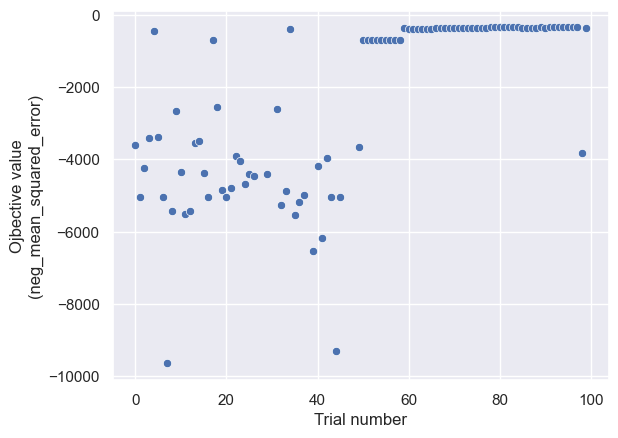

In [7]:
import seaborn as sns
sns.set_theme(style="darkgrid")
default_reg_scoring= config.settings.scoring
ax = sns.scatterplot(data=study.trials_dataframe(), x="number", y="value");
ax.set(xlabel="Trial number", ylabel=f"Ojbective value\n({default_reg_scoring})");

Sometimes it might be interesting to look at individual CV scores instead of aggregated score (mean CV score by default). Here we can plot all 3 cross validation scores (neg_mean_squared_error) for each trial (folds highlighted using different colors).

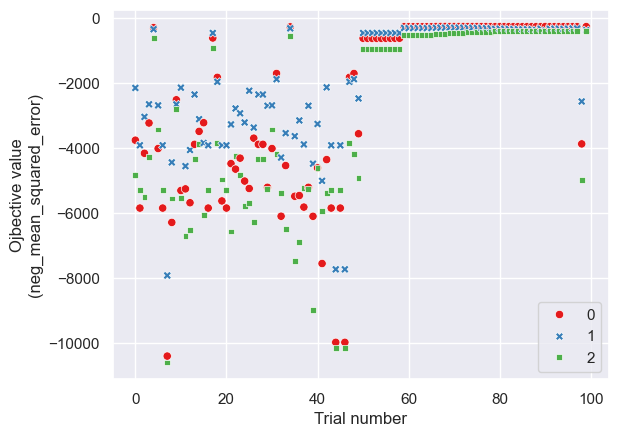

In [8]:
cv_test = study.trials_dataframe()["user_attrs_test_scores"].map(lambda d: d[default_reg_scoring])
x = []
y = []
fold = []
for i, vs in cv_test.items():
    for idx, v in enumerate(vs):
        x.append(i)
        y.append(v)
        fold.append(idx)
ax = sns.scatterplot(x=x, y=y, hue=fold, style=fold, palette='Set1')
ax.set(xlabel="Trial number", ylabel=f"Ojbective value\n({default_reg_scoring})");

### Pick the best trial and build a model for it

We pick the best trial, inspect its configuration, build the best model, and save it as a pickled file.

In [9]:
# Get the best Trial from the Study and make a Build (Training) configuration for it.
buildconfig = buildconfig_best(study)

Optional: write out JSON of the best configuration.

In [10]:
import apischema
buildconfig_as_dict = apischema.serialize(buildconfig)

import json
print(json.dumps(buildconfig_as_dict, indent=2))

{
  "data": {
    "training_dataset_file": "../tests/data/DRD2/subset-50/train.csv",
    "input_column": "canonical",
    "response_column": "molwt",
    "response_type": "regression",
    "deduplication_strategy": {
      "name": "KeepMedian"
    },
    "split_strategy": {
      "name": "NoSplitting"
    },
    "test_dataset_file": "../tests/data/DRD2/subset-50/test.csv",
    "save_intermediate_files": false,
    "log_transform": false,
    "log_transform_base": null,
    "log_transform_negative": null,
    "log_transform_unit_conversion": null,
    "probabilistic_threshold_representation": false,
    "probabilistic_threshold_representation_threshold": null,
    "probabilistic_threshold_representation_std": null
  },
  "metadata": {
    "name": "",
    "cross_validation": 3,
    "shuffle": false,
    "best_trial": 95,
    "best_value": -342.63507445779743,
    "n_trials": 100,
    "visualization": null
  },
  "descriptor": {
    "name": "ECFP_counts",
    "parameters": {
      "radius

Build (re-Train) and save the best model. This time training uses all training data, without splitting it into cross-validation folds.

In [11]:
best_build = build_best(buildconfig, "../target/best.pkl")

We can use the best (or merged) model as following

In [12]:
import pickle
with open("../target/best.pkl", "rb") as f:
    model = pickle.load(f)
model.predict_from_smiles(["CCC", "CC(=O)Nc1ccc(O)cc1"])

array([ 67.43103985, 177.99850936])

Now we can explore how good the best model performs on the test (holdout) set.

In [13]:
import pandas as pd

df = pd.read_csv(config.data.test_dataset_file)  # Load test data.

expected = df[config.data.response_column]
predicted = model.predict_from_smiles(df[config.data.input_column])

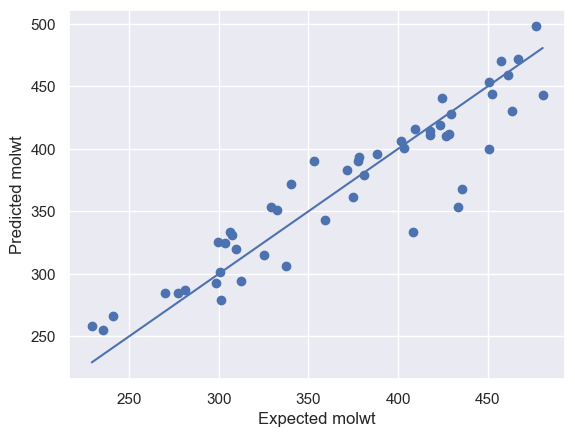

In [14]:
# Plot expected vs predicted values for the best model.
import matplotlib.pyplot as plt
ax = plt.scatter(expected, predicted)
lims = [expected.min(), expected.max()]
plt.plot(lims, lims)  # Diagonal line.
plt.xlabel(f"Expected {config.data.response_column}");
plt.ylabel(f"Predicted {config.data.response_column}");

We can also calculate custom metrics for the best model:

In [15]:
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error)
import numpy as np

# R2
r2 = r2_score(y_true=expected, y_pred=predicted)

# RMSE. sklearn 0.24 added squared=False to get RMSE, here we use np.sqrt().
rmse = np.sqrt(mean_squared_error(y_true=expected, y_pred=predicted))  

# MAE
mae = mean_absolute_error(y_true=expected, y_pred=predicted)

print(f"R2: {r2}, RMSE: {rmse}, Mean absolute error: {mae}")

R2: 0.8566354978126369, RMSE: 26.204909888075044, Mean absolute error: 19.298453946973815


If the metrics look acceptable, the model is ready for use.

### Build merged model

Now we can merge train and test data, and build (train) the model again. We will have no more holdout data to evaluate the model, but hopefully the model will be a little better by seeing a little more data.

In [16]:
# Build (Train) and save the model on the merged train+test data.
build_merged(buildconfig, "../target/merged.pkl")

## Preprocessing: splitting data into train and test sets, and removing duplicates <a class="anchor" id="preprocessing"></a>

### Splitting into train and test dataset

QSARtuna can split data into train and test (holdout) datasets. To do so, send all data in as training_dataset_file, and choose a splitting strategy. Currently QSARtuna supports three splitting strategies: random, temporal and stratified. 

Random strategy splits data randomly, taking a specified fraction of observations to be test dataset. 

Temporal strategy takes the first observations as training dataset, and the last specified fraction of observations as test dataset. The input dataset must be already sorted, from oldest in the beginning to newest and the end. This sorting can be done in any external tool (e.g. Excel). 

Stratified strategy splits data into bins first, and then takes a fraction from each bin to be the test dataset. This ensures that the distributions in the train and test data are similar. This is a better strategy if dataset is unballanced.

### Removing duplicates

All the algorithms QSARtuna supports do not work with duplicates. Duplicates can come from multiple measurements for the same compound, or from the fact that the molecular descriptors we use are all disregard stereochemistry, so even if compounds are different, descriptors make them into duplicates. QSARtuna provides several strategies to remove duplicates:
* keep median - factors experimental deviation using all replicates into one median value (robust to outliers - recommended)
* keep average - use all experimental data acorss all replicates (less robust to outliers vs. median)
* keep first / keep last - when the first or the last measurement is the trusted one
* keep max / keep min - when we want to keep the most extreme value out of many
* keep random - when we are agnostic to which replicate kept

### Configuration example

In [17]:
from optunaz.utils.preprocessing.splitter import Stratified
from optunaz.utils.preprocessing.deduplicator import KeepMedian
# Prepare hyperparameter optimization configuration.
config = OptimizationConfig(
    data=Dataset(
        input_column="canonical",
        response_column="molwt",
        training_dataset_file="../tests/data/DRD2/subset-100/train.csv",  # This will be split into train and test.
        split_strategy=Stratified(fraction=0.2),
        deduplication_strategy=KeepMedian(),
    ),
    descriptors=[
        ECFP.new(), 
        ECFP_counts.new(), 
        MACCS_keys.new(),
    ],
    algorithms=[
        SVR.new(),
        RandomForestRegressor.new(n_estimators={"low": 5, "high": 10}),
        Ridge.new(),
        Lasso.new(),
        PLSRegression.new(),
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=3,
        n_trials=100,
        n_startup_trials=50,
        direction=OptimizationDirection.MAXIMIZATION,
        track_to_mlflow=False,
    ),
) 

In [18]:
study = optimize(config, study_name="my_study_stratified_split")

[I 2024-10-02 17:18:31,184] A new study created in memory with name: my_study_stratified_split
[I 2024-10-02 17:18:31,245] A new study created in memory with name: study_name_0
[I 2024-10-02 17:18:31,429] Trial 0 finished with value: -4800.860920246363 and parameters: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 0 with value: -4800.860920246363.
[I 2024-10-02 17:18:31,464] Trial 1 finished with value: -4858.3431583833035 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 1.0006453852494528, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 0 with value: -4800.860920246363.
[I 2024-10-02 17:18:31,494] Tria

[I 2024-10-02 17:18:32,634] Trial 20 finished with value: -5151.671578155611 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.4915389100768701, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 17 with value: -395.1851441224497.
[I 2024-10-02 17:18:32,729] Trial 21 finished with value: -5177.075814440911 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 23, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 7, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 17 with value: -395.1851441224497.
[I 2024-10-02 17:18:32,759] Trial 22 finished wit

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-4800.860920246363]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-4800.860920246363]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-3749.429746437208]


[I 2024-10-02 17:18:33,135] Trial 34 finished with value: -5377.083434599547 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 29, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 6, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 17 with value: -395.1851441224497.
[I 2024-10-02 17:18:33,153] Trial 35 finished with value: -3479.5161579632318 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.31941804567565524, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 17 with value: -395.1851441224497.
[I 2024-10-02 17:18:33,221] Trial 36 finished with value: -5679.831553540497 and paramete

/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.990e+02, tolerance: 3.621e+01
  model = cd_fast.enet_coordinate_descent(
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.732e+01, tolerance: 3.624e+01
  model = cd_fast.enet_coordinate_descent(
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning

[I 2024-10-02 17:18:34,375] Trial 60 finished with value: -398.51379448396074 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.2538271702413508, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 55 with value: -363.457063392389.
[I 2024-10-02 17:18:34,425] Trial 61 finished with value: -399.23253166598073 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.25813227404797817, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 55 with value: -363.457063392389.
[I 2024-10-02 17:18:34,475] Trial 62 finished with value: -395.52936726273145 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f6096

/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.510e+01, tolerance: 3.624e+01
  model = cd_fast.enet_coordinate_descent(
[I 2024-10-02 17:18:35,906] Trial 81 finished with value: -402.4885067071505 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.11382015597797501, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 55 with value: -363.457063392389.
[I 2024-10-02 17:18:35,982] Trial 82 finished with value: -390.62810821067677 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alp

[I 2024-10-02 17:18:37,064] Trial 99 finished with value: -424.78576633112925 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.0489979631143741, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 55 with value: -363.457063392389.


## Choosing scoring function <a class="anchor" id="scoring"></a>

By default, QSARtuna uses `neg_mean_squared_error` for regression and `roc_auc` for classification. It is possible to change to other scoring functions that supported by scikit-learn (https://scikit-learn.org/stable/modules/model_evaluation.html) amongst others:

In [19]:
from optunaz import objective
list(objective.regression_scores) + list(objective.classification_scores)

['explained_variance',
 'max_error',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_median_absolute_error',
 'r2',
 'accuracy',
 'average_precision',
 'balanced_accuracy',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_weighted',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_weighted',
 'neg_brier_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_weighted',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_weighted',
 'roc_auc',
 'auc_pr_cal',
 'bedroc',
 'concordance_index']

This value can be set using `settings.scoring`:

In [20]:
config = OptimizationConfig(
    data=Dataset(
        input_column="canonical",
        response_column="molwt",
        training_dataset_file="../tests/data/DRD2/subset-100/train.csv",
    ),
    descriptors=[
        ECFP.new(), 
        ECFP_counts.new(), 
        MACCS_keys.new(),
    ],
    algorithms=[
        SVR.new(),
        RandomForestRegressor.new(n_estimators={"low": 5, "high": 10}),
        Ridge.new(),
        Lasso.new(),
        PLSRegression.new(),
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=3,
        n_trials=100,
        n_startup_trials=50,
        random_seed=42,
        scoring="r2",  # Scoring function name from scikit-learn.
        direction=OptimizationDirection.MAXIMIZATION,
        track_to_mlflow=False,
    ),
) 

In [21]:
study = optimize(config, study_name="my_study_r2")

[I 2024-10-02 17:18:40,168] A new study created in memory with name: my_study_r2
[I 2024-10-02 17:18:40,170] A new study created in memory with name: study_name_0
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/joblib/memory.py:577: JobLibCollisionWarning: Possible name collisions between functions 'calculate_from_smi' (/Users/kljk345/PycharmProjects/Public_QSARtuna/D/QSARtuna/optunaz/descriptors.py:-1) and 'calculate_from_smi' (/Users/kljk345/PycharmProjects/Public_QSARtuna/D/QSARtuna/optunaz/descriptors.py:180)
  return self._cached_call(args, kwargs, shelving=False)[0]
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/joblib/memory.py:577: JobLibCollisionWarning: Possible name collisions between functions 'calculate_from_smi' (/Users/kljk345/PycharmProjects/Public_QSARtuna/D/QSARtuna/optunaz/descriptors.py:-1) and 'calculate_from_smi' (/Users/kljk345/PycharmProjects/Public

[I 2024-10-02 17:18:43,402] Trial 16 finished with value: 0.3105263811279067 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 1.344271094811757, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 9 with value: 0.8639946428338224.
[I 2024-10-02 17:18:43,429] Trial 17 finished with value: 0.3562469062424869 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 1.670604991178476, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 9 with value: 0.8639946428338224.
[I 2024-10-02 17:18:43,514] Trial 18 finished with value: 0.04595969590698327 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'm

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [0.29355820424290757]


[I 2024-10-02 17:18:43,870] Trial 26 finished with value: 0.8198078293055633 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.5888977841391714, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 9 with value: 0.8639946428338224.
[I 2024-10-02 17:18:43,906] Trial 27 finished with value: 0.8201573964824842 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.19435298754153707, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 9 with value: 0.8639946428338224.
[I 2024-10-02 17:18:44,044] Trial 28 finished with value: 0.045959695906983344 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [0.29355820424290757]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [0.30625740785155436]


[I 2024-10-02 17:18:44,631] Trial 40 finished with value: 0.41215254857081174 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 5, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 9 with value: 0.8639946428338224.
[I 2024-10-02 17:18:44,644] Trial 41 pruned. Duplicate parameter set
[I 2024-10-02 17:18:44,768] Trial 42 finished with value: -0.004614143721600776 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 25, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 5, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3':

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [0.30393095442038176]


[I 2024-10-02 17:18:44,912] Trial 44 finished with value: -0.10220127407364976 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 22, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 9 with value: 0.8639946428338224.
[I 2024-10-02 17:18:44,944] Trial 45 finished with value: 0.3032340413058286 and parameters: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 9 with value: 0.8639946428338224.
[I 2024-10-02 17:18:44,986] Trial 46 finished with value: 0.3044553805553568 and para

/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.014e+02, tolerance: 4.977e+01
  model = cd_fast.enet_coordinate_descent(
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.243e+02, tolerance: 4.782e+01
  model = cd_fast.enet_coordinate_descent(
[I 2024-10-02 17:18:45,674] Trial 54 finished with value: 0.8624781673814641 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc942306

[I 2024-10-02 17:18:46,919] Trial 70 finished with value: 0.8648431452862716 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.20027647978240445, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 70 with value: 0.8648431452862716.
[I 2024-10-02 17:18:47,006] Trial 71 finished with value: 0.8648491459660418 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.1968919999787333, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 71 with value: 0.8648491459660418.
[I 2024-10-02 17:18:47,120] Trial 72 finished with value: 0.8650873115156988 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f60966

/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.175e+02, tolerance: 4.782e+01
  model = cd_fast.enet_coordinate_descent(
[I 2024-10-02 17:18:48,574] Trial 86 finished with value: 0.8641621818665252 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.1286796719653316, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 72 with value: 0.8650873115156988.
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective di

/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.177e+02, tolerance: 4.977e+01
  model = cd_fast.enet_coordinate_descent(
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.284e+02, tolerance: 4.782e+01
  model = cd_fast.enet_coordinate_descent(
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning

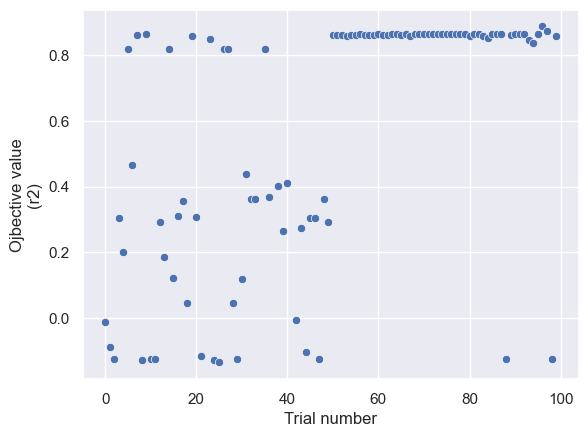

In [22]:
ax = sns.scatterplot(data=study.trials_dataframe(), x="number", y="value")
ax.set(xlabel="Trial number", ylabel="Ojbective value\n(r2)");

## Advanced functoinaility: algorithms & runs

Various algorithms are available in QSARtuna:

In [23]:
from optunaz.config.optconfig import AnyAlgorithm
AnyAlgorithm.__args__

(optunaz.config.optconfig.Lasso,
 optunaz.config.optconfig.PLSRegression,
 optunaz.config.optconfig.RandomForestRegressor,
 optunaz.config.optconfig.Ridge,
 optunaz.config.optconfig.KNeighborsRegressor,
 optunaz.config.optconfig.SVR,
 optunaz.config.optconfig.XGBRegressor,
 optunaz.config.optconfig.PRFClassifier,
 optunaz.config.optconfig.ChemPropRegressor,
 optunaz.config.optconfig.ChemPropRegressorPretrained,
 optunaz.config.optconfig.ChemPropHyperoptRegressor,
 optunaz.config.optconfig.CustomRegressionModel,
 optunaz.config.optconfig.AdaBoostClassifier,
 optunaz.config.optconfig.KNeighborsClassifier,
 optunaz.config.optconfig.LogisticRegression,
 optunaz.config.optconfig.RandomForestClassifier,
 optunaz.config.optconfig.SVC,
 optunaz.config.optconfig.ChemPropClassifier,
 optunaz.config.optconfig.ChemPropHyperoptClassifier,
 optunaz.config.optconfig.CustomClassificationModel,
 optunaz.config.optconfig.CalibratedClassifierCVWithVA,
 optunaz.config.optconfig.Mapie)

This tutorial will now look at more complex considerations that should be factored for more advanced functionaility such as the PRF and ChemProp algorithms

## Probabilistic Random Forest (PRF)

PRF is a modification of the long-established Random Forest (RF) algorithm and takes into account uncertainties in features and/or labels (though only uncertainty in labels are currently implemented in QSARtuna), which was first described in[1]. It can be seen as a probabilistic method to factor experimental uncertainty during training, and is considered a hybrid between regression and classification algorithms.

In more detail; PRF treats labels as probability distribution functions [PDFs] (denoted as `∆y`), rather than deterministic quantities. In comparison, the traditional RF uses discrete variables for activity (binary y-labels, also referred to as `y`) from the discretised bioactivity scale defining active/inactive sets. 

PTR integration was added to QSARtuna to afford this probabilistic approach towards modelling, and is particularly useful combined with the PTR (See the preprocessing notebook for details). In this combination, PRF takes as input real-valued probabilities (similar to regression), from a Probabilistic Threshold Representation (PTR). However, similar to classification algorithms, PRF outputs the probability of activity for the active class.

Note that QSARtuna runs the PRFClassifier in a regression setting, since the model only outputs class liklihood membership based on `∆y`

[1] https://iopscience.iop.org/article/10.3847/1538-3881/aaf101/meta

The following code imports the PRFClassifier and sets up a config to use the PRF with PTR:

In [24]:
from optunaz.config.optconfig import PRFClassifier

# Prepare hyperparameter optimization configuration.
config = OptimizationConfig(
    data=Dataset(
        input_column="Smiles",
        response_column="Measurement",
        training_dataset_file="../tests/data/pxc50/P24863.csv",
        probabilistic_threshold_representation=True, # This enables PTR
        probabilistic_threshold_representation_threshold=8, # This defines the activity threshold
        probabilistic_threshold_representation_std=0.6, # This captures the deviation/uncertainty in the dataset
    ),
    descriptors=[
        ECFP.new(),
        ECFP_counts.new(),
        MACCS_keys.new(),
    ],
    algorithms=[
        PRFClassifier.new(n_estimators={"low": 20, "high": 20}), #n_estimators set low for the example to run fast
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=2,
        n_trials=15,
        random_seed=42,
        direction=OptimizationDirection.MAXIMIZATION,
    ),
)

Note that QSARtuna is run in regression mode (`ModelMode.REGRESSION`), as outputs from the algorithm are always continuous values.

Next we can run the PRF/PTR study:

In [25]:
# Run the PRF/PTR Optuna Study.
study = optimize(config, study_name="my_study")

[I 2024-10-02 17:18:54,912] A new study created in memory with name: my_study
[I 2024-10-02 17:18:54,914] A new study created in memory with name: study_name_0
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/joblib/memory.py:577: JobLibCollisionWarning: Possible name collisions between functions 'calculate_from_smi' (/Users/kljk345/PycharmProjects/Public_QSARtuna/D/QSARtuna/optunaz/descriptors.py:-1) and 'calculate_from_smi' (/Users/kljk345/PycharmProjects/Public_QSARtuna/D/QSARtuna/optunaz/descriptors.py:180)
  return self._cached_call(args, kwargs, shelving=False)[0]
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/joblib/memory.py:577: JobLibCollisionWarning: Possible name collisions between functions 'calculate_from_smi' (/Users/kljk345/PycharmProjects/Public_QSARtuna/D/QSARtuna/optunaz/descriptors.py:-1) and 'calculate_from_smi' (/Users/kljk345/PycharmProjects/Public_QS

Duplicated trial: {'algorithm_name': 'PRFClassifier', 'PRFClassifier_algorithm_hash': 'efe0ba9870529a6cde0dd3ad22447cbb', 'max_depth__efe0ba9870529a6cde0dd3ad22447cbb': 20, 'n_estimators__efe0ba9870529a6cde0dd3ad22447cbb': 20, 'max_features__efe0ba9870529a6cde0dd3ad22447cbb': <PRFClassifierMaxFeatures.AUTO: 'auto'>, 'min_py_sum_leaf__efe0ba9870529a6cde0dd3ad22447cbb': 1, 'use_py_gini__efe0ba9870529a6cde0dd3ad22447cbb': 1, 'use_py_leafs__efe0ba9870529a6cde0dd3ad22447cbb': 1, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-0.0688559585497607]


[I 2024-10-02 17:19:45,347] Trial 7 finished with value: -0.06603614187252341 and parameters: {'algorithm_name': 'PRFClassifier', 'PRFClassifier_algorithm_hash': 'efe0ba9870529a6cde0dd3ad22447cbb', 'max_depth__efe0ba9870529a6cde0dd3ad22447cbb': 27, 'n_estimators__efe0ba9870529a6cde0dd3ad22447cbb': 20, 'max_features__efe0ba9870529a6cde0dd3ad22447cbb': <PRFClassifierMaxFeatures.AUTO: 'auto'>, 'min_py_sum_leaf__efe0ba9870529a6cde0dd3ad22447cbb': 2, 'use_py_gini__efe0ba9870529a6cde0dd3ad22447cbb': 1, 'use_py_leafs__efe0ba9870529a6cde0dd3ad22447cbb': 1, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 5 with value: -0.05288340414349857.
[I 2024-10-02 17:19:48,828] Trial 8 finished with value: -0.07732628284491558 and parameters: {'algorithm_name': 'PRFClassifier', 'PRFClassifier_algorithm_hash': 'efe0ba9870529a6cde0dd3ad22447cbb', 'max_depth__efe0ba9870529a6cde0dd3ad22447cbb': 5, 'n_estimators__efe0ba9870529a6cde0dd3ad2

We can now plot obtained performance across the Optuna trials.

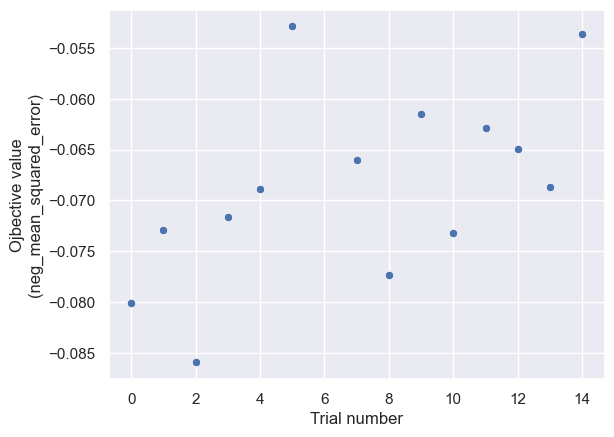

In [26]:
sns.set_theme(style="darkgrid")
default_reg_scoring = config.settings.scoring
ax = sns.scatterplot(data=study.trials_dataframe(), x="number", y="value")
ax.set(xlabel="Trial number", ylabel=f"Ojbective value\n({default_reg_scoring})");

Build the best PRF model:

In [27]:
buildconfig = buildconfig_best(study)
best_built = build_best(buildconfig, "../target/best.pkl")

with open("../target/best.pkl", "rb") as f:
    model = pickle.load(f)

Plot predictions from the merged model for the (seen) train data for demonstration purposes

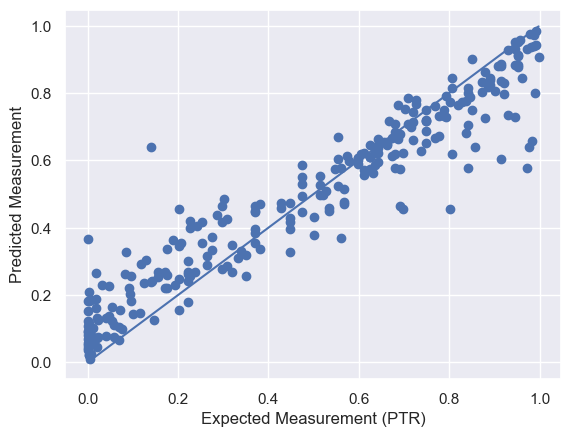

In [28]:
#predict the input from the trained model (transductive evaluation of the model)
example_smiles=config.data.get_sets()[0]
expected = config.data.get_sets()[1]
predicted = model.predict_from_smiles(example_smiles)

# Plot expected vs predicted values for the best model.
ax = plt.scatter(expected, predicted)
lims = [expected.min(), expected.max()]
plt.plot(lims, lims)  # Diagonal line.
plt.xlabel(f"Expected {config.data.response_column} (PTR)");
plt.ylabel(f"Predicted {config.data.response_column}");

### Interlude: Cautionary advice for  PRF ∆y (response column) validity

N.B It is not possible to train on response column values outside the likelihood for y-label memberships (ranging from 0-1), as expected for `∆y`. Doing so will result in the following error from QSARtuna:

In [29]:
# Prepare problematic hyperparameter optimization configuration without PTR.
config = OptimizationConfig(
    data=Dataset(
        input_column="Smiles",
        response_column="Measurement",
        training_dataset_file="../tests/data/pxc50/P24863.csv"),
    descriptors=[
        ECFP.new(),
    ],
    algorithms=[
        PRFClassifier.new(n_estimators={"low": 5, "high": 10}), #n_estimators set low for the example to run fast
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=2,
        n_trials=2,
        direction=OptimizationDirection.MAXIMIZATION,
    ),
)

try:
    study = optimize(config, study_name="my_study")
except ValueError as e:
    print(f'As expected, training the PRF on the raw pXC50 values resulted in the following error:\n\n"{e}')

[I 2024-10-02 17:20:29,205] A new study created in memory with name: my_study
[I 2024-10-02 17:20:29,248] A new study created in memory with name: study_name_0
[W 2024-10-02 17:20:29,249] Trial 0 failed with parameters: {} because of the following error: ValueError('PRFClassifier supplied but response column outside [0.0-1.0] acceptable range. Response max: 9.7, response min: 5.3 ').
Traceback (most recent call last):
  File "/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/Users/kljk345/PycharmProjects/Public_QSARtuna/D/QSARtuna/optunaz/objective.py", line 128, in __call__
    self._validate_algos()
  File "/Users/kljk345/PycharmProjects/Public_QSARtuna/D/QSARtuna/optunaz/objective.py", line 270, in _validate_algos
    raise ValueError(
ValueError: PRFClassifier supplied but response column outside [0.0-1.0] acceptable range. Response m

As expected, training the PRF on the raw pXC50 values resulted in the following error:

"PRFClassifier supplied but response column outside [0.0-1.0] acceptable range. Response max: 9.7, response min: 5.3 


To summarise:
1. PRF handles probability of `y` or `∆y` labels, which range between [`0-1`]
2. PRF is evaluated in a probabilistic setting via conventional regression metrics (e.g. `RMSE`, `R2` etc.), despite the fact that PRF can be considered a modification to the classic Random Forest classifier
3. Probabilistic output is the probability of activity at a relevant cutoff, similar to a classification algorithm
4. Ouputs reflect liklihoods for a molecular property to be above a relevant threshold, given experimental uncertainty (and arguably a more useful component for within a REINVENT MPO score)

## ChemProp

QSARtuna has the functionaility to train `ChemProp` deep learning models. These are message passing neural networks (MPNNs) based on a graph representation of training molecules. They are considered by many to offer the state-of-the-art approach for property prediction.

`ChemProp` was first described in the paper Analyzing Learned Molecular Representations for Property Prediction: https://pubs.acs.org/doi/full/10.1021/acs.jcim.9b00237

More information is available in their slides: https://docs.google.com/presentation/d/14pbd9LTXzfPSJHyXYkfLxnK8Q80LhVnjImg8a3WqCRM/edit

The `ChemProp` package expects SMILES as molecule inputs, since it calcaultes a molecule graph directly from these and so expects SMILES as descriptors. The `SmilesFromFile` and `SmilesAndSideInfoFromFile` descriptors (more about this later) are available for this purpose and are _only_ supported by the `ChemProp` algorithms:

In [30]:
from optunaz.config.optconfig import ChemPropRegressor
from optunaz.descriptors import SmilesBasedDescriptor, SmilesFromFile
print(f"Smiles based descriptors:\n{SmilesBasedDescriptor.__args__}")

Smiles based descriptors:
(<class 'optunaz.descriptors.SmilesFromFile'>, <class 'optunaz.descriptors.SmilesAndSideInfoFromFile'>)


### Simple ChemProp example

The following is an example of the most basic ChemProp run, which will train the algorithm using the recommended (sensible) defaults for the MPNN architecture:

In [31]:
config = OptimizationConfig(
    data=Dataset(
        input_column="canonical",
        response_column="molwt",
        training_dataset_file="../tests/data/DRD2/subset-50/train.csv",  # This will be split into train and test.
        split_strategy=Stratified(fraction=0.50),
        deduplication_strategy=KeepMedian(),
    ),
    descriptors=[
        SmilesFromFile.new(),
    ],
    algorithms=[
        ChemPropRegressor.new(epochs=5), #epochs=5 to ensure run finishes quickly
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=2,
        n_trials=2,
        direction=OptimizationDirection.MAXIMIZATION,
    ),
)

study = optimize(config, study_name="my_study")

[I 2024-10-02 17:20:29,311] A new study created in memory with name: my_study
[I 2024-10-02 17:20:29,313] A new study created in memory with name: study_name_0
INFO:root:Enqueued ChemProp manual trial with sensible defaults: {'activation__668a7428ff5cdb271b01c0925e8fea45': 'ReLU', 'aggregation__668a7428ff5cdb271b01c0925e8fea45': 'mean', 'aggregation_norm__668a7428ff5cdb271b01c0925e8fea45': 100, 'batch_size__668a7428ff5cdb271b01c0925e8fea45': 50, 'depth__668a7428ff5cdb271b01c0925e8fea45': 3, 'dropout__668a7428ff5cdb271b01c0925e8fea45': 0.0, 'features_generator__668a7428ff5cdb271b01c0925e8fea45': 'none', 'ffn_hidden_size__668a7428ff5cdb271b01c0925e8fea45': 300, 'ffn_num_layers__668a7428ff5cdb271b01c0925e8fea45': 2, 'final_lr_ratio_exp__668a7428ff5cdb271b01c0925e8fea45': -4, 'hidden_size__668a7428ff5cdb271b01c0925e8fea45': 300, 'init_lr_ratio_exp__668a7428ff5cdb271b01c0925e8fea45': -4, 'max_lr_exp__668a7428ff5cdb271b01c0925e8fea45': -3, 'warmup_epochs_ratio__668a7428ff5cdb271b01c0925e8fea

You may safely ignore `ChemProp` warnings such as `Model 0 provided with no test set, no metric evaluation will be performed`, `"rmse = nan"` and `1-fold cross validation`, as they are information prompts printed from `ChemProp` due to some (deactivated) CV functionaility (ChemProp can perform it's own cross validation - details for this are still printed despite its deactivation within `QSARtuna`).

NB: QSARtuna will first trial the sensible defaults for the MPNN architecture (where possible given the user config). This is communicated to the user, e.g. see the output which advises:

`A new study created in memory with name: study_name_0
INFO:root:Enqueued ChemProp manual trial with sensible defaults: {'activation': 'ReLU', 'aggregation': 'mean', 'aggregation_norm': 100, 'batch_size': 50, 'depth': 3, 'dropout': 0.0, 'features_generator': 'none', 'ffn_hidden_size': 300, 'ffn_num_layers': 3, 'final_lr_ratio_exp': -1, 'hidden_size': 300, 'init_lr_ratio_exp': -1, 'max_lr_exp': -3, 'warmup_epochs_ratio': 0.1, 'algorithm_name': 'ChemPropRegressor'}`.

Enqueuing custom parameters ensures sampling from a sensible hyperparameter space to begin with, and to facilitate further optimisation from this point. Additional trials will not have any further preset enqueing and use Bayesian optimization for trial suggestion.

### ChemProp optimization separate from shallow methods (default behavior)

By default, `QSARtuna` separates `ChemProp` from the other shallow methods using the `split_chemprop` flag. When this setting is set, the user must specify the number of `ChemProp` trials using the `n_chemprop_trials` flag if more than 1 (default) trial is desired:

In [32]:
from optunaz.config.optconfig import ChemPropClassifier, RandomForestClassifier

config = OptimizationConfig(
    data=Dataset(
        input_column="canonical",
        response_column="molwt_gt_330",
        training_dataset_file="../tests/data/DRD2/subset-50/train.csv",
        split_strategy=Stratified(fraction=0.75),
        deduplication_strategy=KeepMedian(),
    ),
    descriptors=[
        ECFP.new(),
        SmilesFromFile.new(),
    ],
    algorithms=[
        ChemPropClassifier.new(epochs=4),
        RandomForestClassifier.new(n_estimators={"low": 5, "high": 5}),
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.CLASSIFICATION,
        cross_validation=2,
        n_trials=1, # run only one random forest classifier trial
        n_chemprop_trials=2, # run one enqueued chemprop trial and 1 undirected trial
        split_chemprop=True, # this is set to true by default (shown here for illustration)
        direction=OptimizationDirection.MAXIMIZATION,
    ),
)

### Turn on Hyperopt within trials (advanced functionaility & very large computational cost)

QSARtuna optimises all aspects of the ChemProp architecture when using ChemPropRegressor or ChemPropClassifier, however, users can activate the [original hyperparameter-optimization implementation](https://github.com/chemprop/chemprop#hyperparameter-optimization) in the `ChemProp` package, which performs automated Bayesian hyperparameter optimization using the `Hyperopt` package within each trial, at large computational cost.

NB: The principal way for users to expand and perform more advanced runs is to extend the available non-network hyperparameters, such as the `features_generator` option or e.g. to trial differnt side information weighting (if side information is available).

NB: Please note that when `num_iters`=1 (default behavior), any optimisation of the MPNN architecture (done by Hyperopt) is deactivated - the sensible defaults as specified by the ChemProp authors are applied. i.e. optimisation of the MPNN is only possible when `num_iters`>=2, like so:

In [33]:
from optunaz.config.optconfig import ChemPropHyperoptRegressor, ChemPropHyperoptClassifier

config = OptimizationConfig(
    data=Dataset(
        input_column="canonical",
        response_column="molwt",
        training_dataset_file="../tests/data/DRD2/subset-50/train.csv",
        split_strategy=Stratified(fraction=0.5),
        deduplication_strategy=KeepMedian(),
    ),
    descriptors=[
        SmilesFromFile.new(),
    ],
    algorithms=[
        ChemPropHyperoptRegressor.new(epochs=5, num_iters=2), #num_iters>2: enable hyperopt within ChemProp trials
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=2,
        n_trials=1, #just optimise one ChemProp model for this example
        direction=OptimizationDirection.MAXIMIZATION,
    ),
)

NB: Remember that parameter tuning of the MPNN network is performed _within_ each trial.

#### A note on MPNN Hyperopt search space

`ChemProp` models trained using Hyperopt use the [original implementation](https://chemprop.readthedocs.io/en/latest/hyperopt.html), but one key difference is the `search_parameter_level` setting created for `QSARtuna`; Instead of using pre-defined search spaces as in the original package, `QSARtuna` can (and will by the default since `search_parameter_level`=`auto` unless changed) alter the space depending on the characteristics of user input data. For example, no. training set compounds, hyperparameter trials (`num_iters`) & epochs (`epochs`) are used by the `auto` setting to ensure search spaces are not too large for limited data/epochs, and _vice-versa_, an extensive search space is trailed when applicable.

N.B: Users can also manually define `Hyperopt` search spaces by altering `search_parameter_level` from `auto` to a different level between `[0-8]`, representing the increasing search space size (see the [QSARtuna documentation](https://molecularai.github.io/QSARtuna/optunaz.config.html#optunaz.config.optconfig.ChemPropSearch_Parameter_Level) for details).

### Side information and multi-task learning (MTL) <a class="anchor" id="sideinfo"></a>

_“Even if you are only optimizing one loss as is the typical case, chances are there is an auxiliary task that will help you improve upon your main task”_ [Caruana, 1998]

`QSARtuna` typically optimizes for one particular metric for a given molecule property. While we can generally achieve acceptable performance this way, these single task (ST) models ignore information that may improve the prediction of main task of intent. See option `a.` in the figure below.

Signals from relevant related tasks (aka "auxiliary tasks" or "side information") could come from the training signals of other molecular properties and by sharing representations between related tasks, we can enable a neural network to generalize better on our original task of intent. This approach is called Multi-Task Learning (MTL) See option `b.` in the figure below.

<img src="../docs/images/st_mt.png" alt="Difference between ST and MTL" style="width: 400px;"/>

_(above) Differences between optimizing one vs. more than one loss function.  a.) Single-task (ST): one model trained to predict one task one model optimised until performance no longer increases b.) Multi-task (MT/MTL): training one model to predict multiple tasks one model optimising more than one loss function at once enables representations to be shared between trained tasks training signals of related tasks shared between all tasks._


`ChemProp` performs MTL by using the knowledge learnt during training one task to reduce the loss of other tasks included in training. In order to use this function in `QSARtuna`, a user should provide side information in a separate file, and it should have the same ordering and length as the input/response columns (i.e. length of y should = length of side information for y).

E.g: consider the DRD2 example input from earlier:

In [34]:
!head  ../tests/data/DRD2/subset-50/train.csv

canonical,activity,molwt,molwt_gt_330
Cc1cc(NC(=O)c2cccc(COc3ccc(Br)cc3)c2)no1,0,387.233,True
O=C(Nc1ccc(F)cc1F)Nc1sccc1-c1nc2ccccc2s1,0,387.4360000000001,True
COC(=O)c1ccccc1NC(=O)c1cc([N+](=O)[O-])nn1Cc1ccccc1,0,380.36000000000007,True
CCOC(=O)C(C)Sc1nc(-c2ccccc2)ccc1C#N,0,312.39400000000006,False
CCC(CC)NC(=O)c1nn(Cc2ccccc2)c(=O)c2ccccc12,0,349.4340000000001,True
Brc1ccccc1OCCCOc1cccc2cccnc12,0,358.235,True
CCCCn1c(COc2cccc(OC)c2)nc2ccccc21,0,310.39700000000005,False
CCOc1cccc(NC(=O)c2sc3nc(-c4ccc(F)cc4)ccc3c2N)c1,0,407.4700000000001,True
COc1ccc(S(=O)(=O)N(CC(=O)Nc2ccc(C)cc2)c2ccc(C)cc2)cc1OC,0,454.54800000000023,True


There is an accompying example of side information/auxiliary data inputs (calculated PhysChem properties ) as provided in `train_side_info.csv` within the tests data folder:

In [35]:
!head  ../tests/data/DRD2/subset-50/train_side_info.csv

canonical,cLogP,cLogS,H-Acceptors,H-Donors,Total Surface Area,Relative PSA,H-Acceptors-gt-string
Cc1cc(NC(=O)c2cccc(COc3ccc(Br)cc3)c2)no1,4.04,-5.293,5,1,265.09,0.22475,Many
O=C(Nc1ccc(F)cc1F)Nc1sccc1-c1nc2ccccc2s1,4.8088,-5.883,4,2,271.39,0.32297,Few
COC(=O)c1ccccc1NC(=O)c1cc([N+](=O)[O-])nn1Cc1ccccc1,1.6237,-3.835,9,1,287.39,0.33334,Many
CCOC(=O)C(C)Sc1nc(-c2ccccc2)ccc1C#N,3.2804,-4.314,4,0,249.51,0.26075,Few
CCC(CC)NC(=O)c1nn(Cc2ccccc2)c(=O)c2ccccc12,3.2533,-4.498,5,1,278.05,0.18917,Many
Brc1ccccc1OCCCOc1cccc2cccnc12,4.5102,-4.694,3,0,246.29,0.12575,Few
CCCCn1c(COc2cccc(OC)c2)nc2ccccc21,3.7244,-2.678,4,0,255.14,0.14831,Few
CCOc1cccc(NC(=O)c2sc3nc(-c4ccc(F)cc4)ccc3c2N)c1,4.4338,-6.895,5,2,302.18,0.26838,Many
COc1ccc(S(=O)(=O)N(CC(=O)Nc2ccc(C)cc2)c2ccc(C)cc2)cc1OC,3.2041,-5.057,7,1,343.67,0.22298,Many


I.e. the first column (Smiles) should match between the two files, and any columns after the SMILES within the `train_side_info.csv` side information file will be used as y-label side information in the training of the network.

N.B: that calculated PhysChem properties are only one example of side information, and that side information may come from any related property that improves the main task of intent.

A classification example can also be found here:

In [36]:
!head  ../tests/data/DRD2/subset-50/train_side_info_cls.csv

canonical,cLogP_Gt2.5,cLogS_Gt-3.5,H-Acceptors_Gt5,H-Donors_Gt0,Total Surface Area_Gt250,Relative PSA_Lt0.25,H-Acceptors-gt-string
!Cc1cc(NC(=O)c2cccc(COc3ccc(Br)cc3)c2)no1,1,0,0,1,1,1,Many
O=C(Nc1ccc(F)cc1F)Nc1sccc1-c1nc2ccccc2s1,1,0,0,1,1,0,Few
COC(=O)c1ccccc1NC(=O)c1cc([N+](=O)[O-])nn1Cc1ccccc1,0,0,1,1,1,0,Few
CCOC(=O)C(C)Sc1nc(-c2ccccc2)ccc1C#N,1,0,0,0,0,0,Few
CCC(CC)NC(=O)c1nn(Cc2ccccc2)c(=O)c2ccccc12,1,0,0,1,1,1,Many
Brc1ccccc1OCCCOc1cccc2cccnc12,1,0,0,0,0,1,Many
CCCCn1c(COc2cccc(OC)c2)nc2ccccc21,1,1,0,0,1,1,Many
CCOc1cccc(NC(=O)c2sc3nc(-c4ccc(F)cc4)ccc3c2N)c1,1,0,0,1,1,0,Few
COc1ccc(S(=O)(=O)N(CC(=O)Nc2ccc(C)cc2)c2ccc(C)cc2)cc1OC,1,0,1,1,1,1,Many


The contribution or _weight_ of all side information tasks in their contribution to the loss function during training a network is a parameter that can be optimised within QSARtuna, e.g:

In [37]:
from optunaz.descriptors import SmilesAndSideInfoFromFile

config = OptimizationConfig(
    data=Dataset(
        input_column="canonical",
        response_column="molwt",
        training_dataset_file="../tests/data/DRD2/subset-50/train.csv",
        test_dataset_file="../tests/data/DRD2/subset-50/test.csv"),  # Hidden during optimization.
    descriptors=[
        SmilesAndSideInfoFromFile.new(file='../tests/data/DRD2/subset-50/train_side_info.csv',\
                                     input_column='canonical',
                                     aux_weight_pc={"low": 0, "high": 100, "q": 10}) #try different aux weights
    ],
    algorithms=[
        ChemPropHyperoptRegressor.new(epochs=4), #epochs=4 to ensure run finishes quickly
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=1,
        n_trials=8,
        n_startup_trials=0,
        random_seed=42,
        direction=OptimizationDirection.MAXIMIZATION,
    ),
)

study = optimize(config, study_name="my_study")

[I 2024-10-02 17:22:37,977] A new study created in memory with name: my_study
[I 2024-10-02 17:22:37,986] A new study created in memory with name: study_name_0
[I 2024-10-02 17:22:42,900] Trial 0 finished with value: -5492.460529549569 and parameters: {'algorithm_name': 'ChemPropHyperoptRegressor', 'ChemPropHyperoptRegressor_algorithm_hash': 'db9e60f9b8f0a43eff4b41917b6293d9', 'ensemble_size__db9e60f9b8f0a43eff4b41917b6293d9': 1, 'epochs__db9e60f9b8f0a43eff4b41917b6293d9': 4, 'features_generator__db9e60f9b8f0a43eff4b41917b6293d9': <ChemPropFeatures_Generator.NONE: 'none'>, 'num_iters__db9e60f9b8f0a43eff4b41917b6293d9': 1, 'search_parameter_level__db9e60f9b8f0a43eff4b41917b6293d9': <ChemPropSearch_Parameter_Level.AUTO: 'auto'>, 'descriptor': '{"name": "SmilesAndSideInfoFromFile", "parameters": {"file": "../tests/data/DRD2/subset-50/train_side_info.csv", "input_column": "canonical", "aux_weight_pc": {"low": 0, "high": 100, "q": 10}}}', 'aux_weight_pc__db9e60f9b8f0a43eff4b41917b6293d9': 5

Duplicated trial: {'algorithm_name': 'ChemPropHyperoptRegressor', 'ChemPropHyperoptRegressor_algorithm_hash': 'db9e60f9b8f0a43eff4b41917b6293d9', 'ensemble_size__db9e60f9b8f0a43eff4b41917b6293d9': 1, 'epochs__db9e60f9b8f0a43eff4b41917b6293d9': 4, 'features_generator__db9e60f9b8f0a43eff4b41917b6293d9': <ChemPropFeatures_Generator.NONE: 'none'>, 'num_iters__db9e60f9b8f0a43eff4b41917b6293d9': 1, 'search_parameter_level__db9e60f9b8f0a43eff4b41917b6293d9': <ChemPropSearch_Parameter_Level.AUTO: 'auto'>, 'descriptor': '{"name": "SmilesAndSideInfoFromFile", "parameters": {"file": "../tests/data/DRD2/subset-50/train_side_info.csv", "input_column": "canonical", "aux_weight_pc": {"low": 0, "high": 100, "q": 10}}}', 'aux_weight_pc__db9e60f9b8f0a43eff4b41917b6293d9': 50}, return [-5492.460529549569]


[I 2024-10-02 17:22:45,348] Trial 2 finished with value: -5488.71615646329 and parameters: {'algorithm_name': 'ChemPropHyperoptRegressor', 'ChemPropHyperoptRegressor_algorithm_hash': 'db9e60f9b8f0a43eff4b41917b6293d9', 'ensemble_size__db9e60f9b8f0a43eff4b41917b6293d9': 1, 'epochs__db9e60f9b8f0a43eff4b41917b6293d9': 4, 'features_generator__db9e60f9b8f0a43eff4b41917b6293d9': <ChemPropFeatures_Generator.NONE: 'none'>, 'num_iters__db9e60f9b8f0a43eff4b41917b6293d9': 1, 'search_parameter_level__db9e60f9b8f0a43eff4b41917b6293d9': <ChemPropSearch_Parameter_Level.AUTO: 'auto'>, 'descriptor': '{"name": "SmilesAndSideInfoFromFile", "parameters": {"file": "../tests/data/DRD2/subset-50/train_side_info.csv", "input_column": "canonical", "aux_weight_pc": {"low": 0, "high": 100, "q": 10}}}', 'aux_weight_pc__db9e60f9b8f0a43eff4b41917b6293d9': 80}. Best is trial 2 with value: -5488.71615646329.
[I 2024-10-02 17:22:47,076] Trial 3 finished with value: -5488.166537608711 and parameters: {'algorithm_name':

Duplicated trial: {'algorithm_name': 'ChemPropHyperoptRegressor', 'ChemPropHyperoptRegressor_algorithm_hash': 'db9e60f9b8f0a43eff4b41917b6293d9', 'ensemble_size__db9e60f9b8f0a43eff4b41917b6293d9': 1, 'epochs__db9e60f9b8f0a43eff4b41917b6293d9': 4, 'features_generator__db9e60f9b8f0a43eff4b41917b6293d9': <ChemPropFeatures_Generator.NONE: 'none'>, 'num_iters__db9e60f9b8f0a43eff4b41917b6293d9': 1, 'search_parameter_level__db9e60f9b8f0a43eff4b41917b6293d9': <ChemPropSearch_Parameter_Level.AUTO: 'auto'>, 'descriptor': '{"name": "SmilesAndSideInfoFromFile", "parameters": {"file": "../tests/data/DRD2/subset-50/train_side_info.csv", "input_column": "canonical", "aux_weight_pc": {"low": 0, "high": 100, "q": 10}}}', 'aux_weight_pc__db9e60f9b8f0a43eff4b41917b6293d9': 100}, return [-5488.166537608711]


[I 2024-10-02 17:22:48,746] Trial 5 finished with value: -5590.6396754537145 and parameters: {'algorithm_name': 'ChemPropHyperoptRegressor', 'ChemPropHyperoptRegressor_algorithm_hash': 'db9e60f9b8f0a43eff4b41917b6293d9', 'ensemble_size__db9e60f9b8f0a43eff4b41917b6293d9': 1, 'epochs__db9e60f9b8f0a43eff4b41917b6293d9': 4, 'features_generator__db9e60f9b8f0a43eff4b41917b6293d9': <ChemPropFeatures_Generator.NONE: 'none'>, 'num_iters__db9e60f9b8f0a43eff4b41917b6293d9': 1, 'search_parameter_level__db9e60f9b8f0a43eff4b41917b6293d9': <ChemPropSearch_Parameter_Level.AUTO: 'auto'>, 'descriptor': '{"name": "SmilesAndSideInfoFromFile", "parameters": {"file": "../tests/data/DRD2/subset-50/train_side_info.csv", "input_column": "canonical", "aux_weight_pc": {"low": 0, "high": 100, "q": 10}}}', 'aux_weight_pc__db9e60f9b8f0a43eff4b41917b6293d9': 0}. Best is trial 3 with value: -5488.166537608711.
[I 2024-10-02 17:22:48,772] Trial 6 pruned. Duplicate parameter set


Duplicated trial: {'algorithm_name': 'ChemPropHyperoptRegressor', 'ChemPropHyperoptRegressor_algorithm_hash': 'db9e60f9b8f0a43eff4b41917b6293d9', 'ensemble_size__db9e60f9b8f0a43eff4b41917b6293d9': 1, 'epochs__db9e60f9b8f0a43eff4b41917b6293d9': 4, 'features_generator__db9e60f9b8f0a43eff4b41917b6293d9': <ChemPropFeatures_Generator.NONE: 'none'>, 'num_iters__db9e60f9b8f0a43eff4b41917b6293d9': 1, 'search_parameter_level__db9e60f9b8f0a43eff4b41917b6293d9': <ChemPropSearch_Parameter_Level.AUTO: 'auto'>, 'descriptor': '{"name": "SmilesAndSideInfoFromFile", "parameters": {"file": "../tests/data/DRD2/subset-50/train_side_info.csv", "input_column": "canonical", "aux_weight_pc": {"low": 0, "high": 100, "q": 10}}}', 'aux_weight_pc__db9e60f9b8f0a43eff4b41917b6293d9': 100}, return [-5488.166537608711]


[I 2024-10-02 17:22:52,105] Trial 7 finished with value: -5527.605545861933 and parameters: {'algorithm_name': 'ChemPropHyperoptRegressor', 'ChemPropHyperoptRegressor_algorithm_hash': 'db9e60f9b8f0a43eff4b41917b6293d9', 'ensemble_size__db9e60f9b8f0a43eff4b41917b6293d9': 1, 'epochs__db9e60f9b8f0a43eff4b41917b6293d9': 4, 'features_generator__db9e60f9b8f0a43eff4b41917b6293d9': <ChemPropFeatures_Generator.NONE: 'none'>, 'num_iters__db9e60f9b8f0a43eff4b41917b6293d9': 1, 'search_parameter_level__db9e60f9b8f0a43eff4b41917b6293d9': <ChemPropSearch_Parameter_Level.AUTO: 'auto'>, 'descriptor': '{"name": "SmilesAndSideInfoFromFile", "parameters": {"file": "../tests/data/DRD2/subset-50/train_side_info.csv", "input_column": "canonical", "aux_weight_pc": {"low": 0, "high": 100, "q": 10}}}', 'aux_weight_pc__db9e60f9b8f0a43eff4b41917b6293d9': 10}. Best is trial 3 with value: -5488.166537608711.


In the toy example above, the `ChemPropRegressor` has been trialed with a variety of auxiliary weights ranging from 0-100%, using the SmilesAndSideInfoFromFile setting `aux_weight_pc={"low": 0, "high": 100}`.

The inlfuence of the weighting of side information on model performance next hence be explored via a scatterplot of the auxiliary weight percent as a product of the objective value:

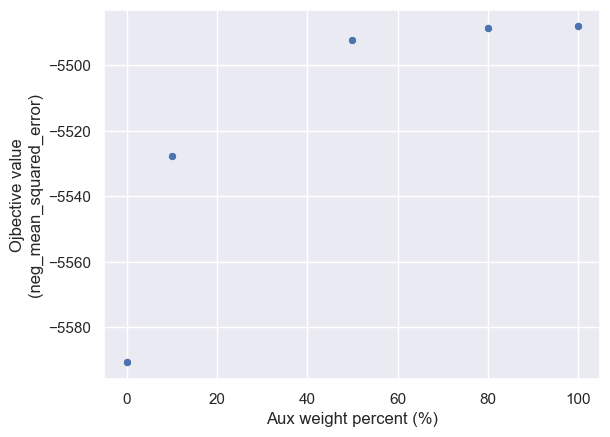

In [38]:
data = study.trials_dataframe().query('user_attrs_trial_ran==True') #drop any pruned/erroneous trials
data.columns = [i.split('__')[0] for i in data.columns] # remove algorithm hash from columns
ax = sns.scatterplot(data=data, x="params_aux_weight_pc", y="value")
ax.set(xlabel="Aux weight percent (%)", ylabel=f"Ojbective value\n({default_reg_scoring})");

Hence we can conclude that 100% weighting of the side information produces the most performant `ChemProp` model

### Combining ChemProp & shallow models (only recommended for large no. trials & long run times)

Above described how ChemProp is by default split from shallow methods. Users can override this using the advanced functionaility when `split_chemprop`=False. In this situation `QSARtuna` will optimise `ChemProp` with the other shallow methods:

In [39]:
config = OptimizationConfig(
    data=Dataset(
        input_column="canonical",
        response_column="molwt_gt_330",
        training_dataset_file="../tests/data/DRD2/subset-50/train.csv",  # This will be split into train and test.
        split_strategy=Stratified(fraction=0.75),
        deduplication_strategy=KeepMedian(),
    ),
    descriptors=[
        ECFP.new(),
        SmilesFromFile.new(),
    ],
    algorithms=[
        ChemPropClassifier.new(epochs=4),
        RandomForestClassifier.new(n_estimators={"low": 5, "high": 5}),
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.CLASSIFICATION,
        cross_validation=2,
        random_seed=42,
        n_trials=10, # run one random forest classifier trial
        split_chemprop=False, # set to false to run ChemProp along side other algorithms
        direction=OptimizationDirection.MAXIMIZATION,
    ),
)

Combining ChemProp and traditional methods in this way means the potential search possible in `QSARtuna` comprises some incompatible sub-spaces; for example, `ChemProp` is only compatible with SMILES-based descriptors, whilst traditional methods are incompatible with SMILES. In the following examples, we consider the following search space: <img src="../docs/images/subspace.png" alt="Valid subspaces in green" style="width: 400px;"/>

Pruning is an effective method to handle such incompatible algorithm-desciptor pairs (grey) to skip any incompatible tials that use non-SMILES descriptors with `ChemProp` and _vice-versa_, when any SMILES-based descriptors are trialed with non-`ChemProp` algorithms. 

This is only recommended for advanced users, when the no. trials is >100, since the optimiser has to learn which descriptors and methods are compatible at the same time as optimising for the most performative pairs.

_What is pruning?_

Pruning is an `Optuna` feature [originally designed](https://optuna.readthedocs.io/en/v2.0.0/tutorial/pruning.html) to automatically stop unpromising trials early in training.

_How/why is pruning implemented in QSARtuna?_

Instead of the original intention of pruning _unpromising trials_ due to poor performance, `QSARtuna` ensures `Optuna` prunes _incompatible algorithm-desciptor pairs_, so the sampler will not trial incomptaible settings again. Duplicated trials are also pruned, to avoid repeatedly suggesting the same hyerparameters. Pruning the trial (instead of  returning a cached result) explicitly tasks the sampler to avoid identical parameters.

Now let us consider the following run:

In [40]:
config = OptimizationConfig(
    data=Dataset(
        input_column="canonical",
        response_column="molwt",
        training_dataset_file="../tests/data/DRD2/subset-50/train.csv",
        test_dataset_file="../tests/data/DRD2/subset-50/test.csv"
    ),
    descriptors=[
        ECFP.new(), # NB: The first 2 descriptors are incompatible with ChemProp 
        MACCS_keys.new(),
        SmilesAndSideInfoFromFile.new(file='../tests/data/DRD2/subset-50/train_side_info.csv',\
                                     input_column='canonical',
                                      aux_weight_pc={"low": 0, "high": 40, "q": 10}
                                     ), # NB: This is only compatible only with ChemProp
    ],
    algorithms=[
        SVR.new(), # NB: The first 6 regressors are incompatible with SMILES descriptors 
        RandomForestRegressor.new(n_estimators={"low": 5, "high": 10}),
        Ridge.new(),
        Lasso.new(),
        PLSRegression.new(),
        ChemPropHyperoptRegressor.new(epochs=4) # NB: ChemProp only compatible with SMILES
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=3,
        n_trials=15,
        random_seed=4,  # seed 4 ensures sampling of incompatible subspace for this example
        n_startup_trials=10,
        split_chemprop=False,
        direction=OptimizationDirection.MAXIMIZATION,
    ),
)

study = optimize(config, study_name="my_study")

[I 2024-10-02 17:22:52,649] A new study created in memory with name: my_study
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/joblib/memory.py:577: JobLibCollisionWarning: Possible name collisions between functions 'calculate_from_smi' (/Users/kljk345/PycharmProjects/Public_QSARtuna/D/QSARtuna/optunaz/descriptors.py:-1) and 'calculate_from_smi' (/Users/kljk345/PycharmProjects/Public_QSARtuna/D/QSARtuna/optunaz/descriptors.py:958)
  return self._cached_call(args, kwargs, shelving=False)[0]
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/joblib/memory.py:577: JobLibCollisionWarning: Possible name collisions between functions 'calculate_from_smi' (/Users/kljk345/PycharmProjects/Public_QSARtuna/D/QSARtuna/optunaz/descriptors.py:-1) and 'calculate_from_smi' (/Users/kljk345/PycharmProjects/Public_QSARtuna/D/QSARtuna/optunaz/descriptors.py:958)
  return self._cached_call(args, kwa

Duplicated trial: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 17, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 7, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-4396.722635068717]


[I 2024-10-02 17:22:54,717] Trial 12 finished with value: -4030.45773791647 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 30, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 12 with value: -4030.45773791647.
[I 2024-10-02 17:22:54,728] Trial 13 pruned. Duplicate parameter set
[I 2024-10-02 17:22:54,876] Trial 14 finished with value: -4030.4577379164707 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 26, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descripto

Duplicated trial: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 30, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-4030.45773791647]


Consulting the `QSARtuna` output, we observe cases of e.g. "`Trial 3 pruned. Incompatible subspace`", which indicates an instance when the sampler has sampled an incompitble algo-descriptor pair. 

"`Trial 13 pruned. Duplicate parameter set`" is an example of pruning a duplicated trial parameter suggestion.

N.B: "`Trial 0 finished with value: -inf`" can occur when the very first `Optuna` trial comprises incompitble algo-descriptor pairs (`-inf` is assigned instead of pruning, since `Optuna` does not allow pruning first trials).

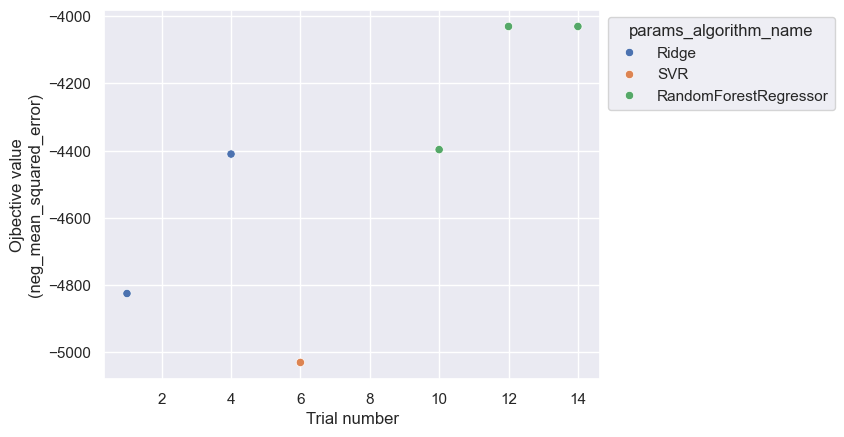

In [41]:
data = study.trials_dataframe().query('user_attrs_trial_ran==True') #drop any pruned/erroneous trials
ax = sns.scatterplot(data=data, x="number", y="value",hue='params_algorithm_name')
ax.set(xlabel="Trial number", ylabel=f"Ojbective value\n({default_reg_scoring})")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

As shown in the overview graph, `Optuna` never successfully samples/trials `ChemProp` with a compatible descriptor, as seen from it's absence in the generated plot. The pruned 8th trial is also missing due to the pruning. This highlights a limitation of combining `ChemProp` (and the associated descriptors) with other algorithms - it makes optimisation more complex, and not all combinations may be suggested. Aside from splitting ChemProp into separate trials, another mitigation strategy is to reduce the complexity of the search space, by removing some incompatible descriptors/traditional methods, to ensure ChemProp has more sampling success. Overall, this serves as a cautionary argument to split `ChemProp` trials (using `split_chemprop`=True).

### Pre-training and adapting ChemProp models (Transfer Learning)

Transfer learning (TL) to adapt pre-trained models on a specific (wider) dataset to a specific dataset of interest in a similar manner to [this publication](https://pubs.acs.org/doi/10.1021/acs.molpharmaceut.3c01124) can be performed in QSARtuna. This option is available for ChemProp models and employs the [original ChemProp package implementation](https://chemprop.readthedocs.io/en/latest/tutorial.html#pretraining).
For example, a user can perform optimisation to pre-train a model using the following:

In [42]:
from optunaz.descriptors import SmilesFromFile
from optunaz.config.optconfig import ChemPropRegressor
config = OptimizationConfig(
    data=Dataset(
        input_column="canonical",
        response_column="molwt",
        training_dataset_file="../tests/data/DRD2/subset-50/train.csv",  # This will be split into train and test.
    ),
    descriptors=[SmilesFromFile.new()],
    algorithms=[
        ChemPropRegressor.new(epochs=4),
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=2,
        n_trials=1,
        direction=OptimizationDirection.MAXIMIZATION,
    ),
)

study = optimize(config, study_name="my_study")
_ = build_best(buildconfig_best(study), "../target/pretrained.pkl")

[I 2024-10-02 17:22:55,736] A new study created in memory with name: my_study
[I 2024-10-02 17:22:55,738] A new study created in memory with name: study_name_0
INFO:root:Enqueued ChemProp manual trial with sensible defaults: {'activation__e0d3a442222d4b38f3aa1434851320db': 'ReLU', 'aggregation__e0d3a442222d4b38f3aa1434851320db': 'mean', 'aggregation_norm__e0d3a442222d4b38f3aa1434851320db': 100, 'batch_size__e0d3a442222d4b38f3aa1434851320db': 50, 'depth__e0d3a442222d4b38f3aa1434851320db': 3, 'dropout__e0d3a442222d4b38f3aa1434851320db': 0.0, 'features_generator__e0d3a442222d4b38f3aa1434851320db': 'none', 'ffn_hidden_size__e0d3a442222d4b38f3aa1434851320db': 300, 'ffn_num_layers__e0d3a442222d4b38f3aa1434851320db': 2, 'final_lr_ratio_exp__e0d3a442222d4b38f3aa1434851320db': -4, 'hidden_size__e0d3a442222d4b38f3aa1434851320db': 300, 'init_lr_ratio_exp__e0d3a442222d4b38f3aa1434851320db': -4, 'max_lr_exp__e0d3a442222d4b38f3aa1434851320db': -3, 'warmup_epochs_ratio__e0d3a442222d4b38f3aa1434851320

The pretrained model saved to `../target/pretrained.pkl` can now be supplied as an input for the `ChemPropRegressorPretrained` algorithm. This model can be retrained with (or adapted to) a new dataset (`../tests/data/DRD2/subset-50/test.csv`) like so:

In [43]:
from optunaz.config.optconfig import ChemPropRegressorPretrained

config = OptimizationConfig(
    data=Dataset(
        input_column="canonical",
        response_column="molwt",
        training_dataset_file="../tests/data/DRD2/subset-50/test.csv",
    ),
    descriptors=[SmilesFromFile.new()],
    algorithms=[
        ChemPropRegressorPretrained.new(
            pretrained_model='../target/pretrained.pkl',
            epochs=ChemPropRegressorPretrained.Parameters.ChemPropParametersEpochs(low=4,high=4))
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=2,
        n_trials=1,
        direction=OptimizationDirection.MAXIMIZATION,
    ),
)

study = optimize(config, study_name="my_study")

[I 2024-10-02 17:24:08,172] A new study created in memory with name: my_study
[I 2024-10-02 17:24:08,222] A new study created in memory with name: study_name_0
[I 2024-10-02 17:25:11,638] Trial 0 finished with value: -5114.7131239123555 and parameters: {'algorithm_name': 'ChemPropRegressorPretrained', 'ChemPropRegressorPretrained_algorithm_hash': 'dfc518a76317f23d95e5aa5a3eac77f0', 'frzn__dfc518a76317f23d95e5aa5a3eac77f0': <ChemPropFrzn.NONE: 'none'>, 'epochs__dfc518a76317f23d95e5aa5a3eac77f0': 4, 'descriptor': '{"name": "SmilesFromFile", "parameters": {}}'}. Best is trial 0 with value: -5114.7131239123555.


Now we have the basics covered, we can now provide an example of how QSARtuna can compare the performance of local, adapted and global (no epochs for transfer learning) models within a single optimisation job in the following example:

In [44]:
config = OptimizationConfig(
    data=Dataset(
        input_column="canonical",
        response_column="molwt",
        training_dataset_file="../tests/data/DRD2/subset-50/train.csv", #  test.csv supplied for fair comparison
        test_dataset_file="../tests/data/DRD2/subset-50/test.csv", #  test.csv supplied for fair comparison
    ),
    descriptors=[SmilesFromFile.new()],
    algorithms=[
        ChemPropRegressor.new(epochs=4), # local
        ChemPropRegressorPretrained.new(
            pretrained_model='../target/pretrained.pkl',
            epochs=ChemPropRegressorPretrained.Parameters.ChemPropParametersEpochs(low=0,high=0)) # global
    ,        
        ChemPropRegressorPretrained.new(
            pretrained_model='../target/pretrained.pkl',
            epochs=ChemPropRegressorPretrained.Parameters.ChemPropParametersEpochs(low=4,high=4)) #adapted
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=1,
        n_trials=5,
        n_startup_trials=0,
        random_seed=0, # ensure all model types trialed
        direction=OptimizationDirection.MAXIMIZATION,
    ),
)
tl_study = optimize(config, study_name="my_study").trials_dataframe()

tl_study['epochs'] = tl_study.loc[:,tl_study.columns.str.contains('params_epochs'
            )].fillna(''
            ).astype(str
            ).agg(''.join, axis=1).astype(float) # merge epochs into one column

tl_study.loc[~tl_study['params_ChemPropRegressor_algorithm_hash'].isna(),
             "Model type"]='Local' # Annotate the local model

tl_study.loc[tl_study['params_ChemPropRegressor_algorithm_hash'].isna() 
             & (tl_study['epochs'] == 4), "Model type"] = 'Adapted' # Annotate the adapted model (TL to new data)

tl_study.loc[tl_study['params_ChemPropRegressor_algorithm_hash'].isna() 
             & (tl_study['epochs'] == 0), "Model type"] = 'Global' # Annotate the global model (no TL)

[I 2024-10-02 17:25:11,764] A new study created in memory with name: my_study
[I 2024-10-02 17:25:11,766] A new study created in memory with name: study_name_0
INFO:root:Enqueued ChemProp manual trial with sensible defaults: {'activation__e0d3a442222d4b38f3aa1434851320db': 'ReLU', 'aggregation__e0d3a442222d4b38f3aa1434851320db': 'mean', 'aggregation_norm__e0d3a442222d4b38f3aa1434851320db': 100, 'batch_size__e0d3a442222d4b38f3aa1434851320db': 50, 'depth__e0d3a442222d4b38f3aa1434851320db': 3, 'dropout__e0d3a442222d4b38f3aa1434851320db': 0.0, 'features_generator__e0d3a442222d4b38f3aa1434851320db': 'none', 'ffn_hidden_size__e0d3a442222d4b38f3aa1434851320db': 300, 'ffn_num_layers__e0d3a442222d4b38f3aa1434851320db': 2, 'final_lr_ratio_exp__e0d3a442222d4b38f3aa1434851320db': -4, 'hidden_size__e0d3a442222d4b38f3aa1434851320db': 300, 'init_lr_ratio_exp__e0d3a442222d4b38f3aa1434851320db': -4, 'max_lr_exp__e0d3a442222d4b38f3aa1434851320db': -3, 'warmup_epochs_ratio__e0d3a442222d4b38f3aa1434851320

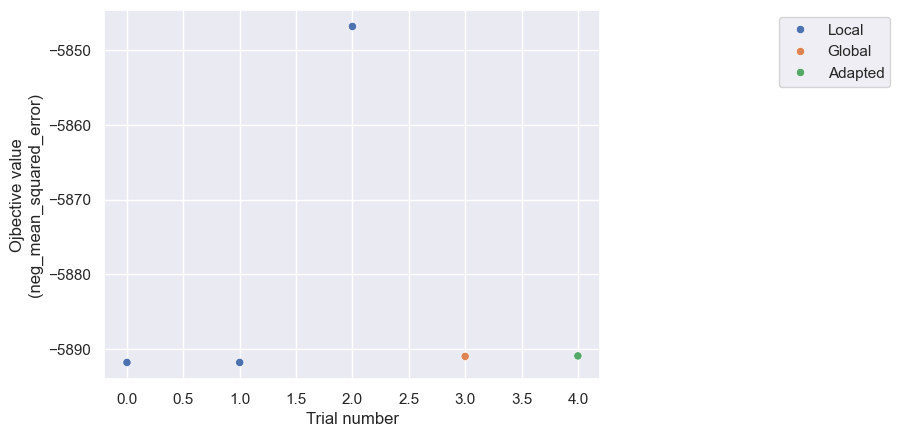

In [45]:
sns.set_theme(style="darkgrid")
default_reg_scoring= config.settings.scoring
ax = sns.scatterplot(data=tl_study, x="number", y="value",hue='Model type')
ax.set(xlabel="Trial number",ylabel=f"Ojbective value\n({default_reg_scoring})")
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.6, 1), ncol=1, title="")

For this toy example we do not observe a large difference between the adapted and global model types, but in a real world setting a user can build the best model from the three model types evaluated.

### ChemProp fingerprints (encode latent representation as descriptors)

It is possible for ChemProp to provide generate outputs in the form intended for use as a fingerprint using the [original package implementation](https://github.com/chemprop/chemprop/tree/master?tab=readme-ov-file#encode-fingerprint-latent-representation). Fingerprints are derived from the latent representation from the MPNN or penultimate FFN output layer, which can be used as a form of learned descriptor or fingerprint.

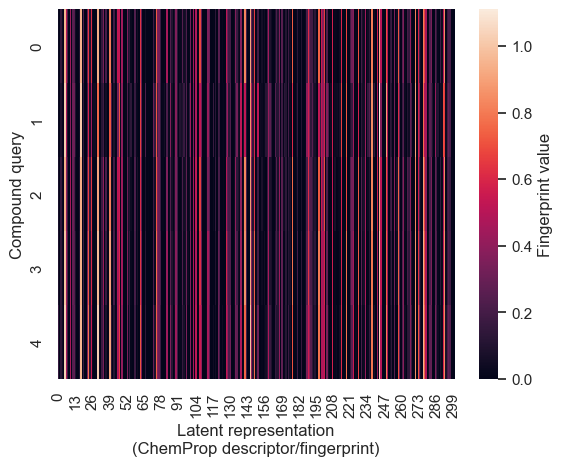

In [46]:
with open("../target/pretrained.pkl", "rb") as f:
    chemprop_model = pickle.load(f)

ax = sns.heatmap(
    chemprop_model.predictor.chemprop_fingerprint(
    df[config.data.input_column].head(5),
    fingerprint_type="MPN",
    ), # MPN specified for illustration purposes - this is the default method in QSARtuna
    cbar_kws={'label': 'Fingerprint value'}
)
ax.set(ylabel="Compound query", xlabel=f"Latent representation\n(ChemProp descriptor/fingerprint)");

The output is n compounds as the input query in the rows by n latent representation features from the MPN in the columns. This output can then be used for any semi-supervise learning approach outside of QSARtuna, as required. Alternatively the last layer of the FFN can be used as so:

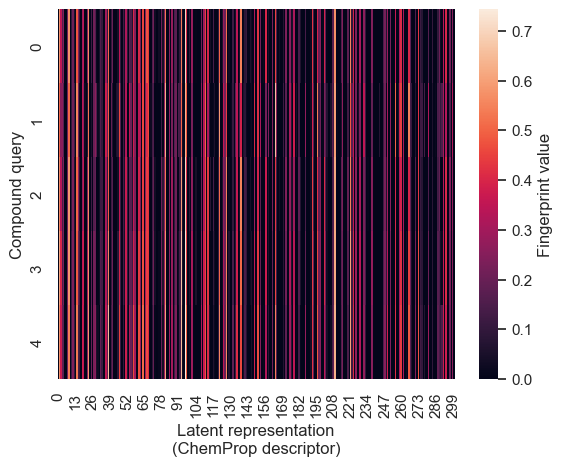

In [47]:
ax = sns.heatmap(
    chemprop_model.predictor.chemprop_fingerprint(
    df[config.data.input_column].head(5),
    fingerprint_type="last_FFN"), # Last FFN
    cbar_kws={'label': 'Fingerprint value'}
)
ax.set(ylabel="Compound query", xlabel=f"Latent representation\n(ChemProp descriptor)");

The 5 compounds in the user query are also represented by the rows, howeever the 300 features are now derived from the last output layer of the FFN

## Probability calibration (classification)

When performing classification you often want not only to predict the class label, but also obtain a probability of the respective label. This probability gives you some kind of confidence on the prediction. Some models can give you poor estimates of the class probabilities. The `CalibratedClassifierCV` QSARtuna models allow better calibration for the probabilities of a given model.

First, we should understand that well calibrated classifiers are probabilistic classifiers for which the output of the predict_proba method can be directly interpreted as a confidence level. For instance, a well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a predict_proba value close to 0.8, approximately 80% actually belong to the positive class.

See the [Scikit-learn documentation](https://scikit-learn.org/stable/modules/calibration.html#calibration) on the topic for more details.

The available methods are `Sigmoid`, `Isotonic regression` and `VennABERS`, and a review of those calibration methods for QSAR has been performed [here](https://pubs.acs.org/doi/10.1021/acs.jcim.0c00476).

we can review the effect of e.g. `sigmoid` calibration on the Random Forest algorithm by doing a calibrated run:

In [48]:
from optunaz.config.optconfig import CalibratedClassifierCVWithVA, RandomForestClassifier
from sklearn.calibration import calibration_curve
import seaborn as sns

from collections import defaultdict

import pandas as pd

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    brier_score_loss,
    log_loss,
    roc_auc_score,
)

config = OptimizationConfig(
    data=Dataset(
        input_column="canonical",
        response_column="molwt_gt_330",
        training_dataset_file="../tests/data/DRD2/subset-100/train.csv"),
    descriptors=[ECFP.new()],
    algorithms=[ # the CalibratedClassifierCVWithVA is used here
        CalibratedClassifierCVWithVA.new(
            estimator=RandomForestClassifier.new(
                n_estimators=RandomForestClassifier.Parameters.RandomForestClassifierParametersNEstimators(
                    low=100, high=100
                )
            ),
            n_folds=5,
            ensemble="True",
            method="sigmoid", 
        )
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.CLASSIFICATION,
        cross_validation=2,
        n_trials=1,
        n_startup_trials=0,
        n_jobs=-1,
        direction=OptimizationDirection.MAXIMIZATION,
        random_seed=42,
    ),
)

study = optimize(config, study_name="calibrated_rf")
build_best(buildconfig_best(study), "../target/best.pkl")
with open("../target/best.pkl", "rb") as f:
    calibrated_model = pickle.load(f)

[I 2024-10-02 17:28:34,653] A new study created in memory with name: calibrated_rf
[I 2024-10-02 17:28:34,656] A new study created in memory with name: study_name_0
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/Users/kljk345/Library

followed by an uncalibrated run:

In [49]:
config = OptimizationConfig(
    data=Dataset(
        input_column="canonical",
        response_column="molwt_gt_330",
        training_dataset_file="../tests/data/DRD2/subset-100/train.csv"),
    descriptors=[ECFP.new()],
    algorithms=[ # an uncalibrated RandomForestClassifier is used here
        RandomForestClassifier.new(
                n_estimators=RandomForestClassifier.Parameters.RandomForestClassifierParametersNEstimators(
                    low=100, high=100
                )
        )
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.CLASSIFICATION,
        cross_validation=2,
        n_trials=1,
        n_startup_trials=0,
        n_jobs=-1,
        direction=OptimizationDirection.MAXIMIZATION,
        random_seed=42,
    ),
)

study = optimize(config, study_name="uncalibrated_rf")
build_best(buildconfig_best(study), "../target/best.pkl")
with open("../target/best.pkl", "rb") as f:
    uncalibrated_model = pickle.load(f)

[I 2024-10-02 17:28:37,168] A new study created in memory with name: uncalibrated_rf
[I 2024-10-02 17:28:37,228] A new study created in memory with name: study_name_0
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/Users/kljk345/Libra

Sigmoid calibration assigns more conservative probability estimates compared to the default RF, as shown by the lower median:

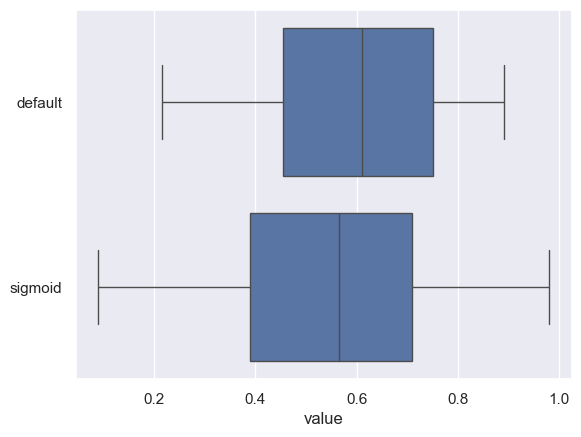

In [50]:
df = pd.read_csv(
    '../tests/data/DRD2/subset-1000/train.csv'
    ).sample(500, random_state=123)  # Load and sample test data.
expected = df[config.data.response_column]
input_column = df[config.data.input_column]
calibrated_predicted = uncalibrated_model.predict_from_smiles(input_column)
uncalibrated_predicted = calibrated_model.predict_from_smiles(input_column)

cal_df=pd.DataFrame(data={"default":uncalibrated_predicted,"sigmoid":calibrated_predicted})
sns.boxplot(data=cal_df.melt(),x='value',y='variable').set_ylabel('');

Plotting the (sigmoid) calibrated predictions as a function of uncalibrated (default) values further highlights the behaviour of the probability calibration scaling:

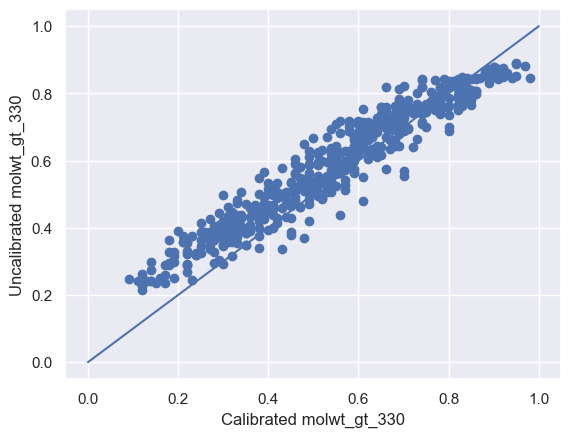

In [51]:
# Plot expected vs predicted values for the best model.
import matplotlib.pyplot as plt
ax = plt.scatter(calibrated_predicted, uncalibrated_predicted)
lims = [expected.min(), expected.max()]
plt.plot(lims, lims)  # Diagonal line.
plt.xlabel(f"Calibrated {config.data.response_column}");
plt.ylabel(f"Uncalibrated {config.data.response_column}");

We can now visualize how well calibrated the predicted probabilities are using calibration curves. A calibration curve, also known as a reliability diagram, uses inputs from a binary classifier and plots the average predicted probability for each bin against the fraction of positive classes, on the y-axis. See [here](https://scikit-learn.org/stable/modules/calibration.html) for more info.

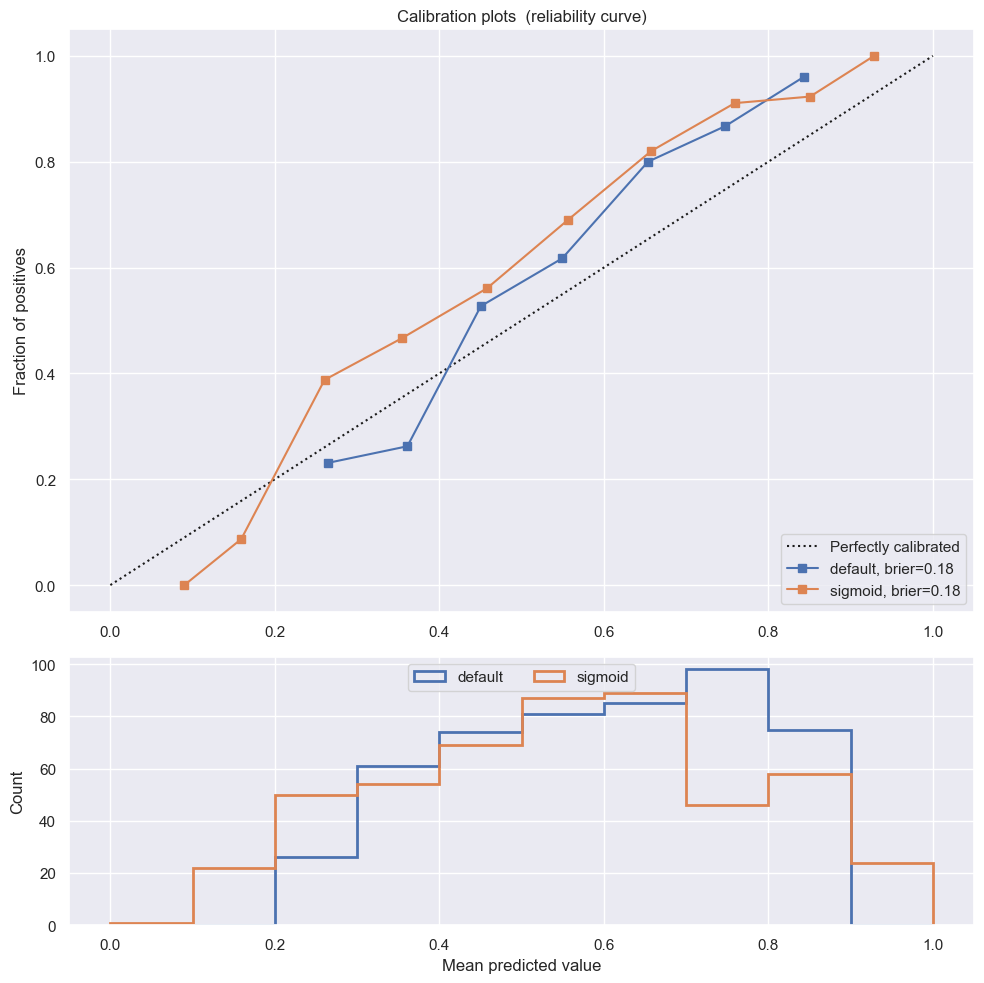

In [52]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for pred, name in [(uncalibrated_predicted, 'default'),
                  (calibrated_predicted, 'sigmoid')]:

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(expected, pred, n_bins=10)
    
    brier=brier_score_loss(expected,pred)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s, brier=%.2f" % (name, brier))

    ax2.hist(pred, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

The diagonal line on the calibration (scatter) plot indicates the situation when a classifier is perfectly calibrationed, when the proportion of active instances annotated by the model are perfectly captured by the probability generated by the model. Deviation above this line indicates when a classifier is under-confident, since the proportion of actives obtaining that score is higher than the score itself, and vice-versa, lines below indicate over-confident estimators, when the proportion of actives obtaining a given score is lower.

Brier score loss (a metric composed of calibration term and refinement term) is one way to capture calibration calibration improvement (this is recorded in the legend above). Notice that this metric does not significantly alter the prediction accuracy measures (precision, recall and F1 score) as shown in the cell below. This is because calibration should not significantly change prediction probabilities at the location of the decision threshold (at x = 0.5 on the graph). Calibration should however, make the predicted probabilities more accurate and thus more useful for making allocation decisions under uncertainty.

In [53]:
from collections import defaultdict

import pandas as pd

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    brier_score_loss,
    log_loss,
    roc_auc_score,
)

scores = defaultdict(list)
for i, (name, y_prob) in enumerate([('yes',calibrated_predicted), ('no',uncalibrated_predicted)]):
    
    y_pred = y_prob > 0.5
    scores["calibration"].append(name)

    for metric in [brier_score_loss, log_loss]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(expected, y_prob))

    for metric in [precision_score, recall_score, f1_score, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(expected, y_pred))

    score_df = pd.DataFrame(scores).set_index("calibration")
    score_df.round(decimals=3)

score_df

Brier  loss  Log loss  Precision    Recall        F1   Roc auc 
calibration                                                                 
yes             0.184705  0.547129    0.830565  0.744048  0.784929  0.716536
no              0.175297  0.529474    0.811209  0.818452  0.814815  0.714104

## Uncertainty estimation

QSARtuna offers three different ways to calculate uncertainty estimates and they are returned along with the normal predictions in the format `[[predictions], [uncertainties]]`. The currently implemented methods are:

1. VennABERS calibration (a probability calibration covered in the section above).
2. Ensemble uncertainty (ChemProp models trained with random initialisations).
3. MAPIE (uncertainty for regression)



### VennABERS uncertainty

VennABERS (VA) uncertainty is implemented as in the section "Uses for the Multipoint Probabilities from the VA Predictors" from https://pubs.acs.org/doi/10.1021/acs.jcim.0c00476. This is based on the margin between the upper (p1) and lower (p0) probability bounary, output by the VennABERS algorithm. More details on this can be found in [this](https://cml.rhul.ac.uk/people/ptocca/HomePage/Toccaceli_CP___Venn_Tutorial.pdf) tutorial

In [54]:
from optunaz.config.optconfig import CalibratedClassifierCVWithVA, RandomForestClassifier
from sklearn.calibration import calibration_curve
import seaborn as sns

from collections import defaultdict

import pandas as pd

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    brier_score_loss,
    log_loss,
    roc_auc_score,
)

config = OptimizationConfig(
    data=Dataset(
        input_column="canonical",
        response_column="molwt_gt_330",
        training_dataset_file="../tests/data/DRD2/subset-100/train.csv"),
    descriptors=[ECFP.new()],
    algorithms=[ # the CalibratedClassifierCVWithVA is used here
        CalibratedClassifierCVWithVA.new(
            estimator=RandomForestClassifier.new(
                n_estimators=RandomForestClassifier.Parameters.RandomForestClassifierParametersNEstimators(
                    low=100, high=100
                )
            ),
            n_folds=5,
            ensemble="True",
            method="vennabers", 
        )
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.CLASSIFICATION,
        cross_validation=2,
        n_trials=1,
        n_startup_trials=0,
        n_jobs=-1,
        direction=OptimizationDirection.MAXIMIZATION,
        random_seed=42,
    ),
)

study = optimize(config, study_name="calibrated_rf")
build_best(buildconfig_best(study), "../target/best.pkl")
with open("../target/best.pkl", "rb") as f:
    calibrated_model = pickle.load(f)

[I 2024-10-02 17:28:39,211] A new study created in memory with name: calibrated_rf
[I 2024-10-02 17:28:39,260] A new study created in memory with name: study_name_0
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/Users/kljk345/Library

VennABERS uncertainty can now be obtained by running inference and supplying `uncert=True`.

In [55]:
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit import RDConfig
from rdkit import DataStructs

# get training data, mols & fingerprints
train_df = pd.read_csv('../tests/data/DRD2/subset-100/train.csv')  # Load test data.
PandasTools.AddMoleculeColumnToFrame(train_df,'canonical','molecule',includeFingerprints=True)
train_df["fp"]=train_df["molecule"].apply(lambda x: AllChem.GetMorganFingerprint(x,2 ))

# get test data, mols & fingerprints and calculate the nn to training set
df = pd.read_csv('../tests/data/DRD2/subset-1000/train.csv')  # Load test data.
PandasTools.AddMoleculeColumnToFrame(df,'canonical','molecule',includeFingerprints=True)
df["fp"]=df["molecule"].apply(lambda x: AllChem.GetMorganFingerprint(x,2 ))
df['nn']=df["fp"].apply(lambda x: max(DataStructs.BulkTanimotoSimilarity(x,[i for i in train_df["fp"]])))

# add uncertainty & prediction to the df 
df['va_pred'], df['va_uncert'] = calibrated_model.predict_from_smiles(df[config.data.input_column], uncert=True)

It is possible to relate the uncertainty to the nearest neighbor (nn) to look for distance-to-model (DTM) effect and to the probabilistic output from the RF model scaled by VA:

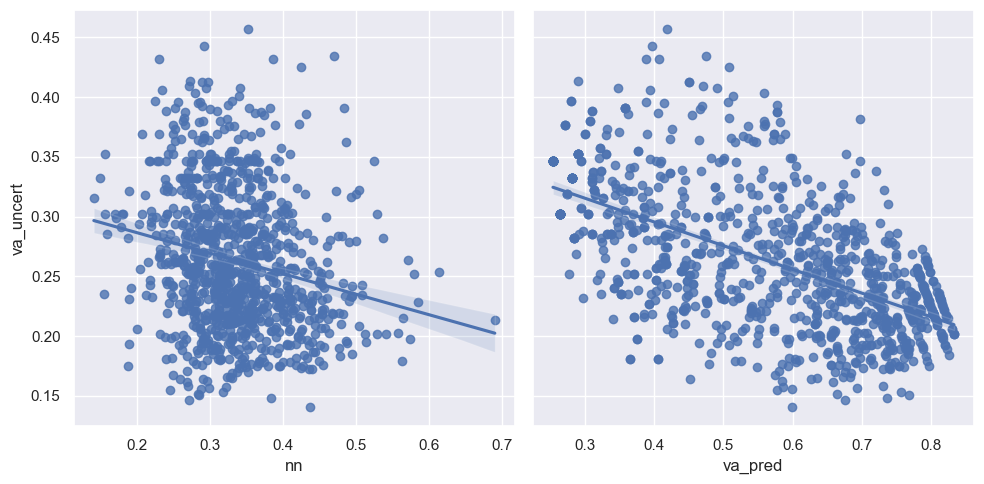

In [56]:
# Plot uncertainty as a function of nn or true label in a trellis for overview.
fig, ax =plt.subplots(1,2, figsize=(10, 5), sharey=True)
sns.regplot(data=df,y='va_uncert',x='nn', ax=ax[0])
sns.regplot(data=df,y='va_uncert',x='va_pred', ax=ax[1]).set_ylabel("")
fig.tight_layout()

Similar to the findings in the referenced scaling evaluation paper above, the lower and upper probability boundary intervals are shown to produce large discordance for test set molecules that are neither very similar nor very dissimilar to the active training set, which were hence difficult to predict.

### Ensemble uncertainty (ChemProp Only)

Training a ChemProp model with `ensemble_size` >1 will enable uncertainty estimation based on the implementation in the original ChemProp package, using the deviation of predictions from the ensemble of models trained with different random initialisation of the weights. This can be done like so:

In [57]:
# Start with the imports.
import sklearn
from optunaz.three_step_opt_build_merge import (
    optimize,
    buildconfig_best,
    build_best,
    build_merged,
)
from optunaz.config import ModelMode, OptimizationDirection
from optunaz.config.optconfig import (
    OptimizationConfig,
    ChemPropHyperoptRegressor,
    ChemPropHyperoptClassifier
)
from optunaz.datareader import Dataset
from optunaz.descriptors import SmilesFromFile
config = OptimizationConfig(
    data=Dataset(
        input_column="canonical",
        response_column="molwt_gt_330",
        training_dataset_file="../tests/data/DRD2/subset-50/train.csv",  # This will be split into train and test.
    ),
    descriptors=[
        SmilesFromFile.new(),
    ],
    algorithms=[
        ChemPropClassifier.new(epochs=4, ensemble_size=5), #epochs=4 to ensure run finishes quickly
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.CLASSIFICATION,
        cross_validation=2,
        n_trials=1,
        direction=OptimizationDirection.MAXIMIZATION,
    ),
)

study = optimize(config, study_name="my_study")

build_best(buildconfig_best(study), "../target/best.pkl")
with open("../target/best.pkl", "rb") as f:
    chemprop_model = pickle.load(f)

# add chemprop uncertainty & prediction to the df 
df["cp_pred_ensemble"], df["cp_uncert_ensemble"] = chemprop_model.predict_from_smiles(df[config.data.input_column], uncert=True)

[I 2024-10-02 17:28:43,031] A new study created in memory with name: my_study
[I 2024-10-02 17:28:43,079] A new study created in memory with name: study_name_0
INFO:root:Enqueued ChemProp manual trial with sensible defaults: {'activation__fd833c2dde0b7147e6516ea5eebb2657': 'ReLU', 'aggregation__fd833c2dde0b7147e6516ea5eebb2657': 'mean', 'aggregation_norm__fd833c2dde0b7147e6516ea5eebb2657': 100, 'batch_size__fd833c2dde0b7147e6516ea5eebb2657': 50, 'depth__fd833c2dde0b7147e6516ea5eebb2657': 3, 'dropout__fd833c2dde0b7147e6516ea5eebb2657': 0.0, 'features_generator__fd833c2dde0b7147e6516ea5eebb2657': 'none', 'ffn_hidden_size__fd833c2dde0b7147e6516ea5eebb2657': 300, 'ffn_num_layers__fd833c2dde0b7147e6516ea5eebb2657': 2, 'final_lr_ratio_exp__fd833c2dde0b7147e6516ea5eebb2657': -4, 'hidden_size__fd833c2dde0b7147e6516ea5eebb2657': 300, 'init_lr_ratio_exp__fd833c2dde0b7147e6516ea5eebb2657': -4, 'max_lr_exp__fd833c2dde0b7147e6516ea5eebb2657': -3, 'warmup_epochs_ratio__fd833c2dde0b7147e6516ea5eebb26

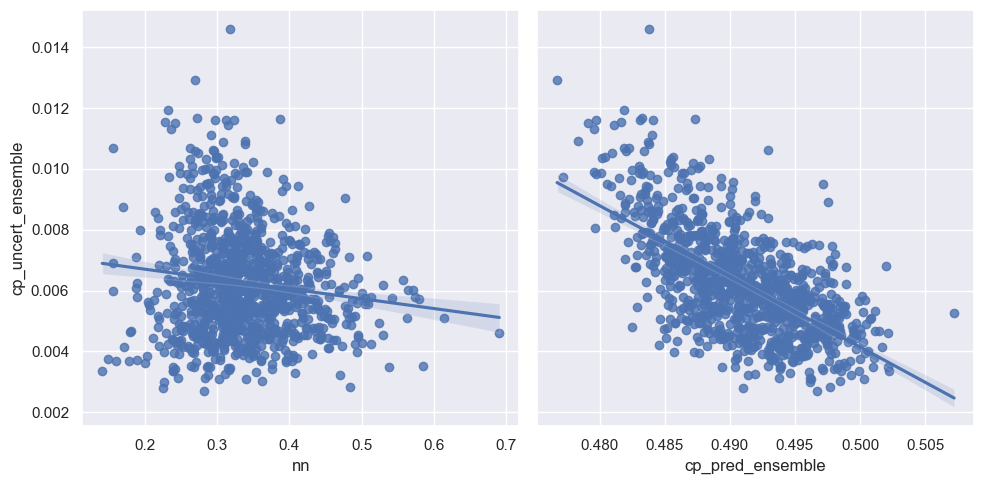

In [58]:
# Plot uncertainty as a function of nn or true label in a trellis for overview.
fig, ax =plt.subplots(1,2, figsize=(10, 5), sharey=True)
sns.regplot(data=df,y='cp_uncert_ensemble',x='nn', ax=ax[0])
sns.regplot(data=df,y='cp_uncert_ensemble',x='cp_pred_ensemble', ax=ax[1]).set(ylabel='')
fig.tight_layout()

Similar to the VA uncertainty, the largest ensemble uncertainty is observed for test set molecules that are neither very similar nor very dissimilar to the active training set, which are hence difficult to predict. Larger uncertainty is also seen toward the midpoint of the ChemProp predictions, for cases when the probabilistic output from models is also neither very high nor very low.

### ChemProp dropout uncertainty

ChemProp uncertainty based on dropout is available for single model and not an ensemble (i.e. when ChemProp is provided with `ensemble_size=1`. It is based on the implementation in the [original ChemProp package](https://github.com/chemprop/chemprop#uncertainty-estimation)

The method uses Monte Carlo dropout to generate a virtual ensemble of models and reports the ensemble variance of the predictions.

Note that this dropout is distinct from dropout regularization used during training, which is not active during predictions.


In [59]:
config = OptimizationConfig(
    data=Dataset(
        input_column="canonical",
        response_column="molwt_gt_330",
        training_dataset_file="../tests/data/DRD2/subset-50/train.csv",  # This will be split into train and test.
    ),
    descriptors=[
        SmilesFromFile.new(),
    ],
    algorithms=[
        ChemPropClassifier.new(epochs=5), #ensemble_size not supplied (defaults back to 1) 
                                                  #to ensure uncertainty will be based on dropout
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.CLASSIFICATION,
        cross_validation=2,
        n_trials=1,
        direction=OptimizationDirection.MAXIMIZATION,
    ),
)

study = optimize(config, study_name="my_study")
build_best(buildconfig_best(study), "../target/best.pkl")
with open("../target/best.pkl", "rb") as f:
    chemprop_model = pickle.load(f)

[I 2024-10-02 17:53:06,941] A new study created in memory with name: my_study
[I 2024-10-02 17:53:07,009] A new study created in memory with name: study_name_0
INFO:root:Enqueued ChemProp manual trial with sensible defaults: {'activation__c73885c5d5a4182168b8b002d321965a': 'ReLU', 'aggregation__c73885c5d5a4182168b8b002d321965a': 'mean', 'aggregation_norm__c73885c5d5a4182168b8b002d321965a': 100, 'batch_size__c73885c5d5a4182168b8b002d321965a': 50, 'depth__c73885c5d5a4182168b8b002d321965a': 3, 'dropout__c73885c5d5a4182168b8b002d321965a': 0.0, 'features_generator__c73885c5d5a4182168b8b002d321965a': 'none', 'ffn_hidden_size__c73885c5d5a4182168b8b002d321965a': 300, 'ffn_num_layers__c73885c5d5a4182168b8b002d321965a': 2, 'final_lr_ratio_exp__c73885c5d5a4182168b8b002d321965a': -4, 'hidden_size__c73885c5d5a4182168b8b002d321965a': 300, 'init_lr_ratio_exp__c73885c5d5a4182168b8b002d321965a': -4, 'max_lr_exp__c73885c5d5a4182168b8b002d321965a': -3, 'warmup_epochs_ratio__c73885c5d5a4182168b8b002d32196

In [60]:
# add chemprop uncertainty & prediction to the df 
df["cp_pred_dropout"], df["cp_uncert_dropout"] = chemprop_model.predict_from_smiles(df[config.data.input_column], uncert=True)

Similar to previous findings using ensembling, the dropout approach toward uncertainty shows largest uncertainty for marginal cases neither similar not dissimilar to training, and with proabilities toward the midpoint (0.5):

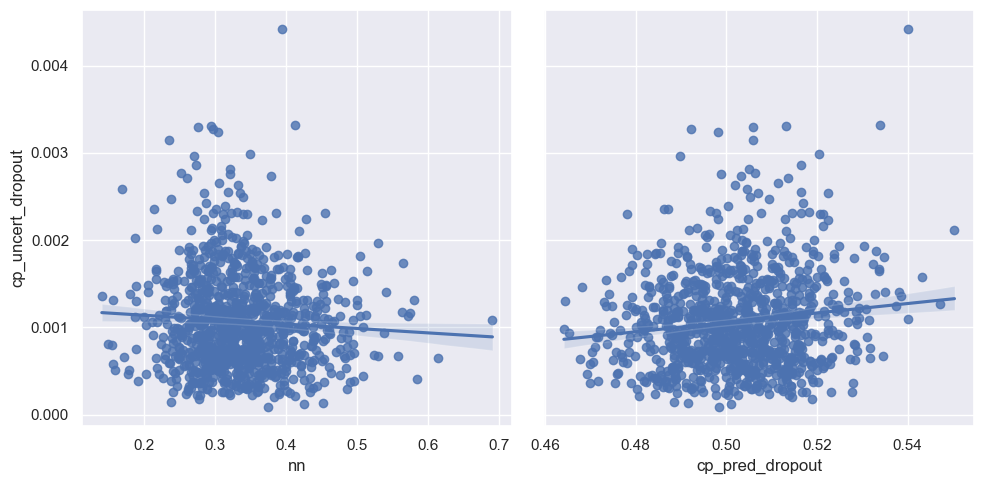

In [61]:
# Plot uncertainty as a function of nn or true label in a trellis for overview.
fig, ax =plt.subplots(1,2, figsize=(10, 5), sharey=True)
sns.regplot(data=df,y='cp_uncert_dropout',x='nn', ax=ax[0])
sns.regplot(data=df,y='cp_uncert_dropout',x='cp_pred_dropout', ax=ax[1]).set(ylabel='')
fig.tight_layout()

Comparison of dropout vs. ensemble uncertainties can be performed as follows:

R2 correlation between drouput and ensemble uncertatinties:-96.38


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


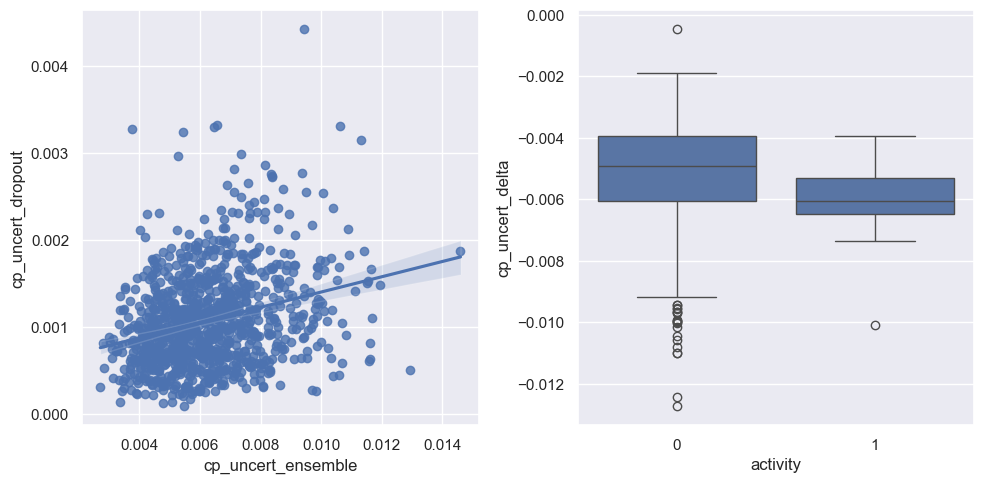

In [62]:
# Plot uncertainty as a function of va_prediction and true label in a trellis for overview.
r2 = r2_score(y_true=df['cp_uncert_dropout'], y_pred=df['cp_uncert_ensemble'])
print(f"R2 correlation between drouput and ensemble uncertatinties:{r2:.2f}")

fig, ax =plt.subplots(1,2, figsize=(10, 5))
df['cp_uncert_delta']=df['cp_uncert_dropout']-df['cp_uncert_ensemble']
sns.regplot(data=df,y='cp_uncert_dropout',x='cp_uncert_ensemble', ax=ax[0])
sns.boxplot(data=df,y='cp_uncert_delta',x='activity', ax=ax[1])
fig.tight_layout()

Findings show that a limited correlation between dropout and ensemble uncertainty for the toy example (real world examples with more epochs/more predictive models will be different)

### MAPIE (regression uncertainty)

For regression uncertainty, the MAPIE package is available within QSARtuna for regression algorithms, and is selected like so:

In [63]:
from optunaz.config.optconfig import Mapie
    
config = OptimizationConfig(
    data=Dataset(
        input_column="canonical",
        response_column="molwt",
        training_dataset_file="../tests/data/DRD2/subset-300/train.csv",  # This will be split into train and test.
    ),
    descriptors=[
        ECFP.new(),
    ],
    algorithms=[Mapie.new( # mapie 'wraps' around a regressor of choice
                estimator=RandomForestRegressor.new(n_estimators={"low": 50, "high": 50})
    )
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=2,
        n_trials=1,
        direction=OptimizationDirection.MAXIMIZATION,
    ),
)

study = optimize(config, study_name="my_study")
build_best(buildconfig_best(study), "../target/best.pkl")
with open("../target/best.pkl", "rb") as f:
    mapie = pickle.load(f)

[I 2024-10-02 18:15:04,953] A new study created in memory with name: my_study
[I 2024-10-02 18:15:05,007] A new study created in memory with name: study_name_0
[I 2024-10-02 18:15:07,190] Trial 0 finished with value: -4497.021799854763 and parameters: {'algorithm_name': 'Mapie', 'Mapie_algorithm_hash': '976d211e4ac64e5568d369bcddd3aeb1', 'mapie_alpha__976d211e4ac64e5568d369bcddd3aeb1': 0.05, 'max_depth__976d211e4ac64e5568d369bcddd3aeb1': 8, 'n_estimators__976d211e4ac64e5568d369bcddd3aeb1': 50, 'max_features__976d211e4ac64e5568d369bcddd3aeb1': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 0 with value: -4497.021799854763.


Analysis of the nn's and behaviour of uncertainty vs. predicted values can be perfomed like so:

In [64]:
# get training data, mols & fingerprints
train_df = pd.read_csv('../tests/data/DRD2/subset-300/train.csv')  # Load test data.
PandasTools.AddMoleculeColumnToFrame(train_df,'canonical','molecule',includeFingerprints=True)
train_df["fp"]=train_df["molecule"].apply(lambda x: AllChem.GetMorganFingerprint(x,2 ))

# get test data, mols & fingerprints and calculate the nn to training set
df = pd.read_csv('../tests/data/DRD2/subset-50/train.csv')  # Load test data.
PandasTools.AddMoleculeColumnToFrame(df,'canonical','molecule',includeFingerprints=True)
df["fp"]=df["molecule"].apply(lambda x: AllChem.GetMorganFingerprint(x,2 ))
df['nn']=df["fp"].apply(lambda x: max(DataStructs.BulkTanimotoSimilarity(x,[i for i in train_df["fp"]])))

mapie.predictor.mapie_alpha=0.99 # it is possible to alter the alpha of mapie post-train using this approach

# add uncertainty & prediction to the df 
df['mapie_pred'], df['mapie_unc'] = mapie.predict_from_smiles(df[config.data.input_column], uncert=True)

Plotting mapie uncertainty as a product of the nearest neighbors/mapie predictions is performed here:

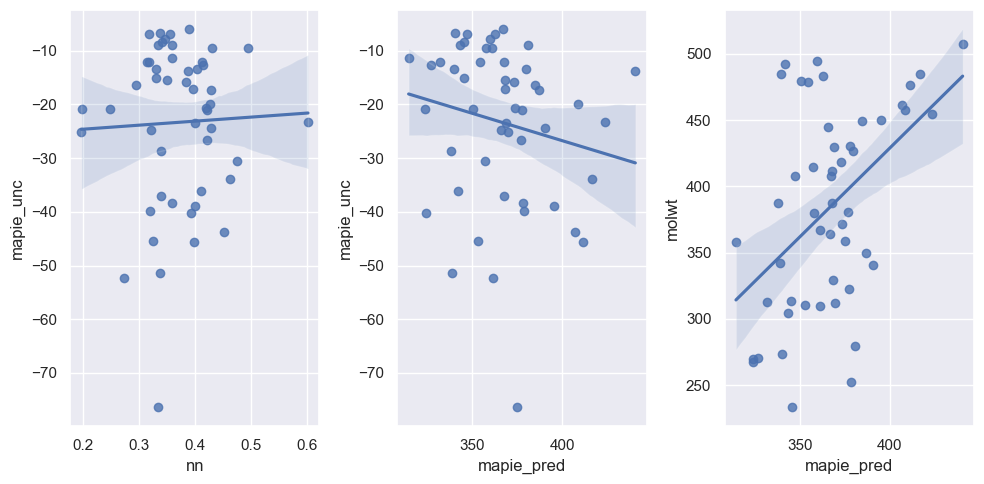

In [65]:
# Plot uncertainty as a function of nn or true label in a trellis for overview.
fig, ax =plt.subplots(1,3, figsize=(10, 5))
sns.regplot(data=df,y='mapie_unc',x='nn', ax=ax[0])
sns.regplot(data=df,y='mapie_unc',x='mapie_pred', ax=ax[1])
sns.regplot(data=df,y=df[config.data.response_column],x='mapie_pred', ax=ax[2])
fig.tight_layout()

Further analysis of the uncertainty using error bars is shown here:

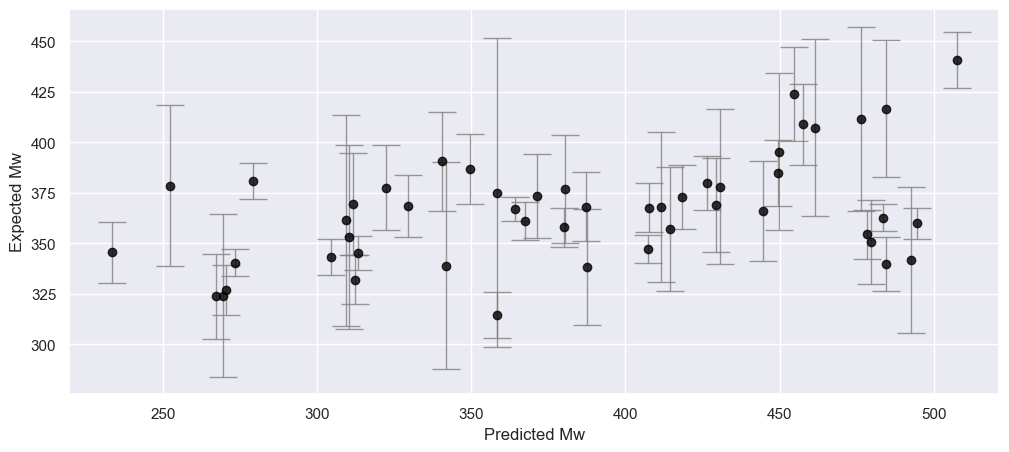

In [66]:
# Plot true value as a function of predicted value, with MAPIE uncertainty error bars for visualisation.
plt.figure(figsize=(12,5))
plt.errorbar(df[config.data.response_column], df['mapie_pred'], yerr=df['mapie_unc'].abs(), fmt='o',color='black', alpha=.8, ecolor='gray', elinewidth=1, capsize=10);
plt.xlabel('Predicted Mw');
plt.ylabel('Expected Mw');

where more certain predictions have smaller error bars.

The same analysis can be performed by plotting similarity to nn's (increasing similarity to the training set moving from left to right on the x-axis):

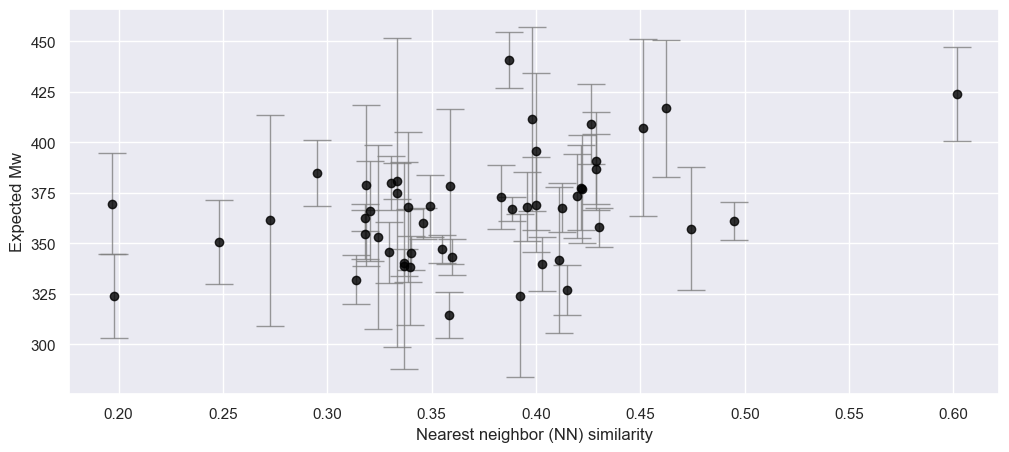

In [67]:
# Plot true value as a function of predicted value, with MAPIE uncertainty error bars for visualisation.
plt.figure(figsize=(12,5))
plt.errorbar(df['nn'], df['mapie_pred'], yerr=df['mapie_unc'].abs(), fmt='o',color='black', alpha=.8, ecolor='gray', elinewidth=1, capsize=10);
plt.xlabel('Nearest neighbor (NN) similarity');
plt.ylabel('Expected Mw');

The MAPIE package uses the `alpha` parameter to set the uncertainty of the confidence interval, see here for details. It is possible to alter the uncertainty of the confidence interval by setting the `mapie_alpha` parameter of the QSARtuna model predictor. Here lower alpha produce larger (more conservative) prediction intervals. N.B: `alpha` is set to 0.05 by default and will hence provide more conservative predictions if not changed.

The alpha settings as a function of uncertainty (over all point predictions) can be analysed for our toy example using the following (error bars denote deviations across all point predictions which have been extended by two standard error widths):

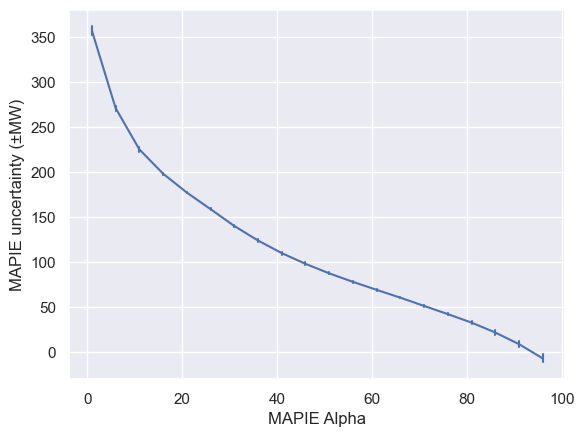

In [68]:
alpha_impact=[]
for ma in range(1,100,5):
    mapie.predictor.mapie_alpha=ma/100
    preds = mapie.predict_from_smiles(df[config.data.input_column], uncert=True)
    unc_df = pd.DataFrame(
    data={
        "pred": preds[0],
        "unc": preds[1],
        "alpha": ma,
        }
    )
    alpha_impact.append(unc_df.reset_index())
alpha_impact=pd.concat(alpha_impact).reset_index(drop=True)

sns.lineplot(data=alpha_impact[alpha_impact['index']<=20],x='alpha',y='unc',err_style="bars", errorbar=("se", 2))
plt.xlabel('MAPIE Alpha');
plt.ylabel('MAPIE uncertainty (±MW)');

As expected larger alpha values produce smaller (less conservative) prediction intervals.

## Explainability

Model explainability is incorporated into QSARtuna using two different approaches, depending on the algorithm chosen:
1. **SHAP:** 
    Any shallow algorithm is compatible with the SHAP package (even traditionally unsupported packages use the `KernelExplainer`)
2. **ChemProp interpret:**
    This explainability approach is based on the interpret function in the original ChemProp package

### SHAP

[SHAP](https://proceedings.neurips.cc/paper_files/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html) (SHapley Additive exPlanations) are available in `QSARtuna` based on the implementation available at https://github.com/slundberg/shap. The method uses a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions (see [here](https://shap.readthedocs.io/en/latest/index.html) for more details on the published tool and [here](https://github.com/slundberg/shap#methods-unified-by-shap) for papers using the approach).

In the following example, a `RIDGE` regressor is trained using the a comopsite descriptor based on the `ECFP`, `MACCS` keys and `PhysChem` descriptors:

In [69]:
from optunaz.descriptors import CompositeDescriptor, UnscaledPhyschemDescriptors, UnscaledJazzyDescriptors
    
config = OptimizationConfig(
    data=Dataset(
        input_column="canonical",
        response_column="molwt",
        training_dataset_file="../tests/data/DRD2/subset-50/train.csv",  # This will be split into train and test.
    ),
    descriptors=[
        CompositeDescriptor.new(
            descriptors=[
                ECFP.new(),
                MACCS_keys.new(),
                UnscaledJazzyDescriptors.new(),
                UnscaledPhyschemDescriptors.new(),
            ]
        )
    ],
    algorithms=[
        Ridge.new(),
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=2,
        n_trials=1,
        direction=OptimizationDirection.MAXIMIZATION,
    ),
)

study = optimize(config, study_name="my_study")
build_best(buildconfig_best(study), "../target/best.pkl")
with open("../target/best.pkl", "rb") as f:
    ridge = pickle.load(f)

[I 2024-10-02 18:15:13,266] A new study created in memory with name: my_study
[I 2024-10-02 18:15:13,311] A new study created in memory with name: study_name_0
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
[I 2024-10-02 18:15:15,004] Trial 0 finished with value: -0.3655099730804518 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 1.1404851303400703, 'descriptor': '{"parameters": {"descriptors": [{"name": "ECFP", "parameters": {"radius": 3, "nBi

Predictions from the algorithms can be explained like so:

In [70]:
ridge.predict_from_smiles(df[config.data.input_column], explain=True).query('shap_value > 0')

shap_value                   descriptor     bit  \
2227  2.042840e+01  UnscaledPhyschemDescriptors     7.0   
2229  2.025345e+01  UnscaledPhyschemDescriptors     9.0   
2228  1.804976e+01  UnscaledPhyschemDescriptors     8.0   
2267  2.370409e+00  UnscaledPhyschemDescriptors    47.0   
2230  2.106017e+00  UnscaledPhyschemDescriptors    10.0   
...            ...                          ...     ...   
845   4.243703e-07                         ECFP   846.0   
804   4.243703e-07                         ECFP   805.0   
423   4.243703e-07                         ECFP   424.0   
995   4.243703e-07                         ECFP   996.0   
1375  4.243703e-07                         ECFP  1376.0   

                           info  
2227                      MolWt  
2229                 ExactMolWt  
2228             HeavyAtomMolWt  
2267                  LabuteASA  
2230        NumValenceElectrons  
...                         ...  
845               c(c(c)C)c(O)c  
804      N(S(N)(=O)=O)(C)C(C)=C  
423         N(=C(c)C)S(=O)(=O)N  
995          C(C(N)=C)(=O)N(C)C  
1375  S1(=O)(=O)N=C(c)C=C(C)N1C  

[1570 rows x 4 columns]

Outputs are ordered by shap_value (higher is more important). We see that the `UnscaledPhyschemDescriptors` bits corresponding to e.g. `MolWt`, `ExactMolWt`, `HeavyAtomMolWt` and `NumValenceElectrons`. We can hence interpret these as the most important features contrinubting to predicting the MolWt for the DRD2 datset. `UnscaledPhyschemJazzy` descriptors are also ranked relatively high in the list.

Other descriptor types in the composite descriptor such as the ECFP fingerprints are also shown in the output. ECFP bits are translated to the atom environments for which the bit was turned on within the training set. 

Other descriptors are less interpretable as no additional information is available in the `info` column.

### ChemProp interpret

ChemProp explainability is based on the `interpret` in the [original package](https://chemprop.readthedocs.io/en/latest/interpret.html#interpretation).

The follow example shows the usage:

In [71]:
config = OptimizationConfig(
    data=Dataset(
        input_column="canonical",
        response_column="molwt",
        training_dataset_file="../tests/data/DRD2/subset-50/train.csv",  # This will be split into train and test.
    ),
    descriptors=[SmilesFromFile.new()],
    algorithms=[
        ChemPropRegressor.new(epochs=4),
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=2,
        n_trials=1,
        direction=OptimizationDirection.MAXIMIZATION,
    ),
)

study = optimize(config, study_name="my_study")
build_best(buildconfig_best(study), "../target/best.pkl")
with open("../target/best.pkl", "rb") as f:
    chemprop = pickle.load(f)

[I 2024-10-02 18:15:20,410] A new study created in memory with name: my_study
[I 2024-10-02 18:15:20,658] A new study created in memory with name: study_name_0
INFO:root:Enqueued ChemProp manual trial with sensible defaults: {'activation__e0d3a442222d4b38f3aa1434851320db': 'ReLU', 'aggregation__e0d3a442222d4b38f3aa1434851320db': 'mean', 'aggregation_norm__e0d3a442222d4b38f3aa1434851320db': 100, 'batch_size__e0d3a442222d4b38f3aa1434851320db': 50, 'depth__e0d3a442222d4b38f3aa1434851320db': 3, 'dropout__e0d3a442222d4b38f3aa1434851320db': 0.0, 'features_generator__e0d3a442222d4b38f3aa1434851320db': 'none', 'ffn_hidden_size__e0d3a442222d4b38f3aa1434851320db': 300, 'ffn_num_layers__e0d3a442222d4b38f3aa1434851320db': 2, 'final_lr_ratio_exp__e0d3a442222d4b38f3aa1434851320db': -4, 'hidden_size__e0d3a442222d4b38f3aa1434851320db': 300, 'init_lr_ratio_exp__e0d3a442222d4b38f3aa1434851320db': -4, 'max_lr_exp__e0d3a442222d4b38f3aa1434851320db': -3, 'warmup_epochs_ratio__e0d3a442222d4b38f3aa1434851320

Similar to SHAP, ChemProp explainability inference is called using the `explain` flag from the `predict_from_smiles`

In [72]:
chemprop.predict_from_smiles(df[config.data.input_column].head(5), explain=True)

[18:16:26] Can't kekulize mol.  Unkekulized atoms: 8 9 18 19 20 21 22 23 24
[18:16:26] Can't kekulize mol.  Unkekulized atoms: 6 7 16 17 18 19 20 21 22
[18:16:26] Can't kekulize mol.  Unkekulized atoms: 6 7 16 17 18 19 20 21 22
[18:16:26] Can't kekulize mol.  Unkekulized atoms: 5 6 15 16 17 18 19 20 21
[18:16:26] Can't kekulize mol.  Unkekulized atoms: 4 5 14 15 16 17 18 19 20
[18:16:26] Can't kekulize mol.  Unkekulized atoms: 2 3 12 13 14 15 16 17 18
[18:16:26] Can't kekulize mol.  Unkekulized atoms: 2 3 12 13 14 15 16 17 18
[18:16:26] Can't kekulize mol.  Unkekulized atoms: 6 7 9 10 11 12 13 14 15
[18:16:26] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[18:16:26] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 11
[18:16:26] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 10
[18:16:26] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[18:16:26] Can't kekulize mol.  Unkekulized atoms: 7 8 17 18 19 20 21 22 23
[18:16:26] Can't kekulize mol.  Unkekulize

[18:16:27] Can't kekulize mol.  Unkekulized atoms: 2 3 6 7 8
[18:16:27] Can't kekulize mol.  Unkekulized atoms: 6 7 13 14 15 16 17 18 19
[18:16:27] Can't kekulize mol.  Unkekulized atoms: 6 7 12 13 14
[18:16:27] Can't kekulize mol.  Unkekulized atoms: 2 3 4 7 8
[18:16:27] Can't kekulize mol.  Unkekulized atoms: 0 1 4 5 6
[18:16:27] Can't kekulize mol.  Unkekulized atoms: 8 9 13 14 15
[18:16:27] Can't kekulize mol.  Unkekulized atoms: 8 9 10 13 14
[18:16:27] Can't kekulize mol.  Unkekulized atoms: 8 9 12 13 14
[18:16:27] Can't kekulize mol.  Unkekulized atoms: 7 8 9 12 13
[18:16:27] Can't kekulize mol.  Unkekulized atoms: 7 8 11 12 13
[18:16:27] Can't kekulize mol.  Unkekulized atoms: 6 7 11 12 13 14 15 16 17
[18:16:27] Can't kekulize mol.  Unkekulized atoms: 9 10 11 13 14
[18:16:27] Can't kekulize mol.  Unkekulized atoms: 5 6 9 10 11 12 13 14 15
[18:16:27] Can't kekulize mol.  Unkekulized atoms: 5 6 7 10 11
[18:16:27] Can't kekulize mol.  Unkekulized atoms: 10 11 12 15 16
[18:16:27] Ca

smiles    score  \
0           Cc1cc(NC(=O)c2cccc(COc3ccc(Br)cc3)c2)no1  386.097   
0           O=C(Nc1ccc(F)cc1F)Nc1sccc1-c1nc2ccccc2s1  389.485   
0  COC(=O)c1ccccc1NC(=O)c1cc([N+](=O)[O-])nn1Cc1c...  384.720   
0                CCOC(=O)C(C)Sc1nc(-c2ccccc2)ccc1C#N  387.110   
0         CCC(CC)NC(=O)c1nn(Cc2ccccc2)c(=O)c2ccccc12  388.997   

                                      rationale rationale_score  
0                      c1cc(CO[CH3:1])c[cH:1]c1         389.151  
0             c1c[cH:1]c[cH:1]c1N[CH2:1][NH2:1]         388.565  
0                        CO[CH2:1]c1cccc[cH:1]1         389.151  
0           c1c[cH:1]c(S[CH2:1][CH3:1])n[cH:1]1         388.871  
0  n1c([CH2:1]N[CH3:1])[cH:1][cH:1][cH:1][n:1]1         387.854

The output contians the following:

* The first column is a molecule and second column is its predicted property (in this dummy case MolWt).

* The third column is the smallest substructure that made this molecule obtain that MolWt prediction (called rationale).

* The fourth column is the predicted MolWt of that substructure.

## Log transformation

QSARtuna can be used to transform input labels so that log-scaled or irregularly distributed data can be transformed to a normal distribution as required for most Machine Learning inputs. The following example shows how XC50 values can be scaled to pXC50 values by using the -Log10 to the 6th unit conversion, like so:

In [73]:
from optunaz.utils.preprocessing.transform import (
    LogBase,
    LogNegative,
    ModelDataTransform
)

config = OptimizationConfig(
        data=Dataset(
        input_column="Smiles",
        response_column="Measurement",
        response_type="regression",
        training_dataset_file="../tests/data/sdf/example.sdf",
        split_strategy=Stratified(fraction=0.4),
        deduplication_strategy=KeepMedian(),
        log_transform=True, # Set to True to perform
        log_transform_base=LogBase.LOG10, # Log10 base will be used
        log_transform_negative=LogNegative.TRUE, # Negated transform for the pXC50 calculation
        log_transform_unit_conversion=6, # 6 units used for pXC50 conversion
    ),
    descriptors=[
        ECFP.new(), 
        ECFP_counts.new(), 
        MACCS_keys.new(),
    ],
    algorithms=[
        SVR.new(),
        RandomForestRegressor.new(n_estimators={"low": 5, "high": 10}),
        Ridge.new(),
        Lasso.new(),
        PLSRegression.new(),
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=3,
        n_trials=100,
        n_startup_trials=50,
        direction=OptimizationDirection.MAXIMIZATION,
        track_to_mlflow=False,
        random_seed=42,
    ),
) 

transformed_study = optimize(config, study_name="transform_example")

[I 2024-10-02 18:16:29,451] A new study created in memory with name: transform_example
[I 2024-10-02 18:16:29,498] A new study created in memory with name: study_name_0
[I 2024-10-02 18:16:29,601] Trial 0 finished with value: -0.5959493772536109 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 6, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 5, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 0 with value: -0.5959493772536109.
[I 2024-10-02 18:16:29,851] Trial 1 finished with value: -0.6571993250300608 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 7, 'n_estimator

[I 2024-10-02 18:16:31,948] Trial 19 finished with value: -0.7974925066137679 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.5158832554303112, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 14 with value: -0.2721824844856162.
[I 2024-10-02 18:16:31,967] Trial 20 finished with value: -1.2183952264663362 and parameters: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 14 with value: -0.2721824844856162.
[I 2024-10-02 18:16:31,987] Trial 21 finished with value: -1.1474226942497083 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 0.000932765091952

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-0.5410418750776741]


[I 2024-10-02 18:16:32,274] Trial 28 finished with value: -1.3169218304262786 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 13, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 6, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 27 with value: -0.2710284516876423.
[I 2024-10-02 18:16:32,303] Trial 29 finished with value: -3.6273152492418945 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 1.6285506249643193, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 0.35441495011256785, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 27 with value: -0.2710284516876423.
[I 2024-10-02 18:16:32,396] Tri

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-0.5410418750776741]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-1.2183952264663362]


[I 2024-10-02 18:16:32,723] Trial 40 finished with value: -0.4127882135896648 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 5, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 35 with value: -0.2709423025014604.
[I 2024-10-02 18:16:32,736] Trial 41 pruned. Duplicate parameter set
[I 2024-10-02 18:16:32,819] Trial 42 finished with value: -0.5959493772536109 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 25, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 5, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3':

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-1.248706331711276]


[I 2024-10-02 18:16:32,974] Trial 45 finished with value: -1.107536316777608 and parameters: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 35 with value: -0.2709423025014604.
[I 2024-10-02 18:16:33,000] Trial 46 finished with value: -2.194926264155893 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 1.6437201185807124, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 35 with value: -0.2709423025014604.
[I 2024-10-02 18:16:33,024] Trial 47 finished with value: -4.054360360588395 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 82.41502276709562, 'C__ea7

[I 2024-10-02 18:16:33,652] Trial 66 finished with value: -0.27087301924224993 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.007985924302396141, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 60 with value: -0.27086925247190047.
[I 2024-10-02 18:16:33,683] Trial 67 finished with value: -0.2708685399954944 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.00249856291483601, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 67 with value: -0.2708685399954944.
[I 2024-10-02 18:16:33,713] Trial 68 finished with value: -0.27121879554836553 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__

[I 2024-10-02 18:16:34,440] Trial 87 finished with value: -0.27249853374634975 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 1.702026434077893, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 71 with value: -0.2708682582859318.
[I 2024-10-02 18:16:34,470] Trial 88 finished with value: -0.27095660957755363 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.10916094511173127, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 71 with value: -0.2708682582859318.
[I 2024-10-02 18:16:34,520] Trial 89 finished with value: -0.27102160995407715 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa

In comparison, QSARtuna does not normally transform the data:

In [74]:
config = OptimizationConfig(
        data=Dataset(
        input_column="Smiles",
        response_column="Measurement",
        response_type="regression",
        training_dataset_file="../tests/data/sdf/example.sdf",
        split_strategy=Stratified(fraction=0.4),
        deduplication_strategy=KeepMedian(),
        log_transform=False, # Shown for illustration: Log transform defaults to False
        log_transform_base=None, # Shown for illustration: Log10 base is None/ignored if not log scaled
        log_transform_negative=None, # Shown for illustration: negation is None/ignored if not log scaled
        log_transform_unit_conversion=None, # Shown for illustration: conversion is None/ignored if not log scaled
    ),
    descriptors=[
        ECFP.new(), 
        ECFP_counts.new(), 
        MACCS_keys.new(),
    ],
    algorithms=[
        SVR.new(),
        RandomForestRegressor.new(n_estimators={"low": 5, "high": 10}),
        Ridge.new(),
        Lasso.new(),
        PLSRegression.new(),
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=3,
        n_trials=100,
        n_startup_trials=50,
        direction=OptimizationDirection.MAXIMIZATION,
        track_to_mlflow=False,
        random_seed=42,
    ),
) 

default_study = optimize(config, study_name="non-transform_example")

[I 2024-10-02 18:16:38,216] A new study created in memory with name: non-transform_example
[I 2024-10-02 18:16:38,218] A new study created in memory with name: study_name_0
[I 2024-10-02 18:16:38,320] Trial 0 finished with value: -3501.942111261296 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 6, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 5, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 0 with value: -3501.942111261296.
[I 2024-10-02 18:16:38,389] Trial 1 finished with value: -5451.207265576796 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 7, 'n_estimato

[I 2024-10-02 18:16:38,944] Trial 18 finished with value: -8873.669262669626 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 22, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 6, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 11 with value: -208.1049192609138.
[I 2024-10-02 18:16:38,970] Trial 19 finished with value: -21387.63697424318 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.5158832554303112, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 11 with value: -208.1049192609138.
[I 2024-10-02 18:16:38,989] Trial 20 finished with value: -9958.573006910125 and para

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-3630.727680937561]


[I 2024-10-02 18:16:39,224] Trial 29 finished with value: -203.93637462922368 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 1.6285506249643193, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 0.35441495011256785, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 25 with value: -150.3435882510586.
[I 2024-10-02 18:16:39,289] Trial 30 finished with value: -5964.65935954044 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 10, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 8, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 25 with value: -150.3435882510586.
[I 2024-10-02 18:16:39,308] Trial 3

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-3630.727680937561]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-9958.573006910125]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-9964.541364058234]


[I 2024-10-02 18:16:39,623] Trial 42 finished with value: -3501.888460860864 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 25, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 5, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 25 with value: -150.3435882510586.
[I 2024-10-02 18:16:39,643] Trial 43 finished with value: -8414.932694243476 and parameters: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 2, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 25 with value: -150.3435882510586.
[I 2024-10-02 18:16:39,710] Trial 44 finished with value: -2270.5407991891466 and par

[I 2024-10-02 18:16:40,122] Trial 61 finished with value: -157.87939164358104 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 28.32187661108304, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 7.660320437878754, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 25 with value: -150.3435882510586.
[I 2024-10-02 18:16:40,150] Trial 62 finished with value: -157.01705178481896 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 38.61397716361812, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 8.603665957830847, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 25 with value: -150.3435882510586.
[I 2024-10-02 18:16:40,178] Trial 63 finished with value: -155.73257312230092 and parameters: {'algorith

[I 2024-10-02 18:16:40,776] Trial 80 finished with value: -78.68420472011734 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 0.0032474576673554513, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 98.35551178979624, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 80 with value: -78.68420472011734.
[I 2024-10-02 18:16:40,822] Trial 81 finished with value: -80.85985201823172 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 0.003187930738019005, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 89.29431603544847, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 80 with value: -78.68420472011734.
[I 2024-10-02 18:16:40,860] Trial 82 finished with value: -80.21583898009355 and parameters: {'algo

[I 2024-10-02 18:16:41,555] Trial 99 finished with value: -166.85570350846885 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 0.0016948043699497222, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 5.455627755557016, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 93 with value: -76.44100655116532.


The importance of scaling can be analysed by directly contrasting the two different studies with and without log transformation:

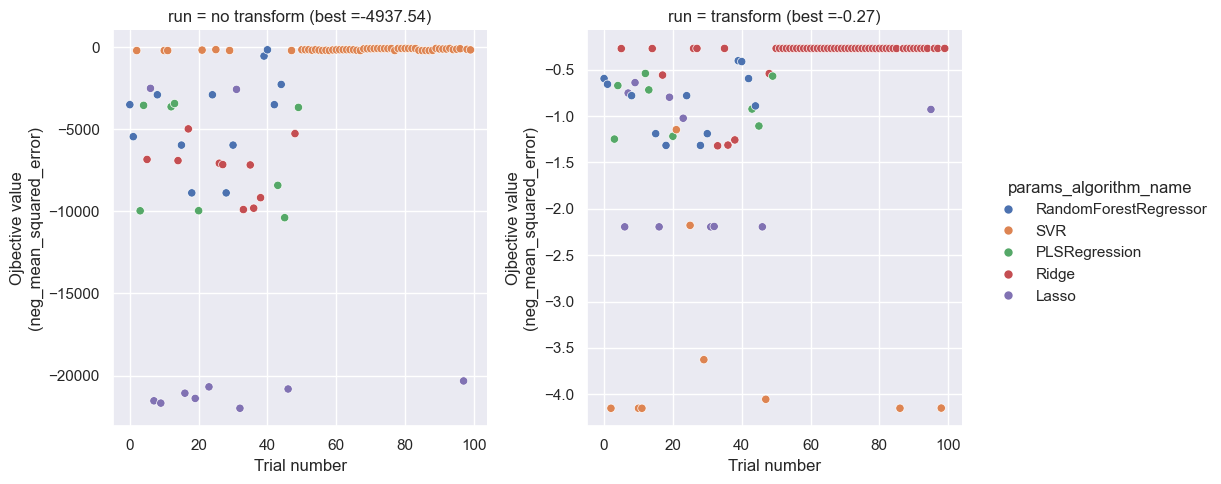

In [75]:
import seaborn as sns

comparison = pd.concat((default_study.trials_dataframe().assign(run=f'no transform (best ={study.best_value:.2f})'),
            transformed_study.trials_dataframe().assign(run=f'transform (best ={transformed_study.best_value:.2f})')))

default_reg_scoring= config.settings.scoring
ax = sns.relplot(data=comparison, x="number", y="value", 
                 col='run',hue='params_algorithm_name', 
                 facet_kws={"sharey":False})
ax.set(xlabel="Trial number",ylabel=f"Ojbective value\n({default_reg_scoring})")
ax.tight_layout()

This example shows the influence of scaling the pXC50 values to the log scale. The non-noramlised distribution of the unlogged data yields very large (negative) model evaluation scores, since evaluation metrics such as MSE are relative, and the scale of the error is reported in performance values.

Users generate predictions for a model trained on log transformed data in the same way as the normal models, like so:

In [76]:
# Get the best Trial from the log transformed study and build the model.
buildconfig = buildconfig_best(transformed_study)
best_build = build_best(buildconfig, "../target/best.pkl")

# generate predictions
import pickle
with open("../target/best.pkl", "rb") as f:
    model = pickle.load(f)
model.predict_from_smiles(["CCC", "CC(=O)Nc1ccc(O)cc1"])

array([1126.56968721,  120.20237903])

NB: Please note that outputs have automatically been reversed transformed at inference, back onto the original XC50 scale, as shown by large values outside the log pXC50.

This is the default behaviour of QSARtuna; reverse transform is performed at inference when log transformation was applied, so that users can action on prediction the original input data scale. Importantly, a user can easily override this behaviour by providing the transform parameter as `None`:

In [77]:
model.predict_from_smiles(["CCC", "CC(=O)Nc1ccc(O)cc1"], transform=None)

array([2.94824194, 3.92008694])

This will instruct QSARtuna to avoid the reverse transform on the predictions. This transform parameter is ignored if no transformation was applied in the user config.

Log transformation can also be combined with the PTR transform. In this situation, all user inputs are expected to be on the untransformed scale. For example, if a user wishes to create a PTR model, trained on pXC50 data and a cut-off for pXC50 values of 5 (10um), the following config can be used:

In [78]:
ptr_config_log_transform = OptimizationConfig(
        data=Dataset(
        input_column="Smiles",
        response_column="Measurement",
        response_type="regression",
        training_dataset_file="../tests/data/sdf/example.sdf",
        split_strategy=Stratified(fraction=0.4),
        deduplication_strategy=KeepMedian(),
        log_transform=True, # Set to True to perform
        log_transform_base=LogBase.LOG10, # Log10 base will be used
        log_transform_negative=LogNegative.TRUE, # Negated transform for the pXC50 calculation
        log_transform_unit_conversion=6, # 6 units used for pXC50 conversion
        probabilistic_threshold_representation=True, # This enables PTR
        probabilistic_threshold_representation_threshold=5, # This defines the activity threshold for 10um
        probabilistic_threshold_representation_std=0.6, # This captures the deviation/uncertainty in the dataset

    ),
    descriptors=[
        ECFP.new(), 
        ECFP_counts.new(), 
        MACCS_keys.new(),
    ],
    algorithms=[
        SVR.new(),
        RandomForestRegressor.new(n_estimators={"low": 5, "high": 10}),
        Ridge.new(),
        Lasso.new(),
        PLSRegression.new(),
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=3,
        n_trials=100,
        n_startup_trials=50,
        direction=OptimizationDirection.MAXIMIZATION,
        track_to_mlflow=False,
        random_seed=42,
    ),
) 

ptr_transformed_study = optimize(ptr_config_log_transform, study_name="ptr_and_transform_example")

[I 2024-10-02 18:16:47,381] A new study created in memory with name: ptr_and_transform_example
[I 2024-10-02 18:16:47,424] A new study created in memory with name: study_name_0
[I 2024-10-02 18:16:47,523] Trial 0 finished with value: -0.002341918451736245 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 6, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 5, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 0 with value: -0.002341918451736245.
[I 2024-10-02 18:16:47,589] Trial 1 finished with value: -0.0024908979029632686 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 

[I 2024-10-02 18:16:48,098] Trial 19 finished with value: -0.008706109201510277 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.5158832554303112, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 14 with value: -0.0010855652626111146.
[I 2024-10-02 18:16:48,117] Trial 20 finished with value: -0.004846526544994462 and parameters: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 14 with value: -0.0010855652626111146.
[I 2024-10-02 18:16:48,136] Trial 21 finished with value: -0.006964668794465202 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 0.000

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-0.0021653695362066753]


[I 2024-10-02 18:16:48,341] Trial 28 finished with value: -0.006105985607235417 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 13, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 6, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 27 with value: -0.0010807084256204563.
[I 2024-10-02 18:16:48,360] Trial 29 finished with value: -0.008384326901042542 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 1.6285506249643193, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 0.35441495011256785, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 27 with value: -0.0010807084256204563.
[I 2024-10-02 18:16:4

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-0.0021653695362066753]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-0.004846526544994462]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-0.00496231674623194]


[I 2024-10-02 18:16:48,683] Trial 41 pruned. Duplicate parameter set
[I 2024-10-02 18:16:48,750] Trial 42 finished with value: -0.002341918451736245 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 25, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 5, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 35 with value: -0.0010803393728928605.
[I 2024-10-02 18:16:48,771] Trial 43 finished with value: -0.00368328296527152 and parameters: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 2, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 35 with value: -0.0010803393728928605.
[I 

[I 2024-10-02 18:16:49,255] Trial 62 finished with value: -0.001080037482216557 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.006806773659187283, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 60 with value: -0.0010800254136811547.
[I 2024-10-02 18:16:49,280] Trial 63 finished with value: -0.0010801015705851358 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.025009489814943348, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 60 with value: -0.0010800254136811547.
[I 2024-10-02 18:16:49,305] Trial 64 finished with value: -0.0010812122378841013 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7e

[I 2024-10-02 18:16:49,787] Trial 83 finished with value: -0.0010820922958715991 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.5626643670396761, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 71 with value: -0.0010800211339555509.
[I 2024-10-02 18:16:49,816] Trial 84 finished with value: -0.0010805094397523254 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.1394077979875128, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 71 with value: -0.0010800211339555509.
[I 2024-10-02 18:16:49,846] Trial 85 finished with value: -0.0010841993753324146 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee',

Analysis of the study is performed in the same manner as above:

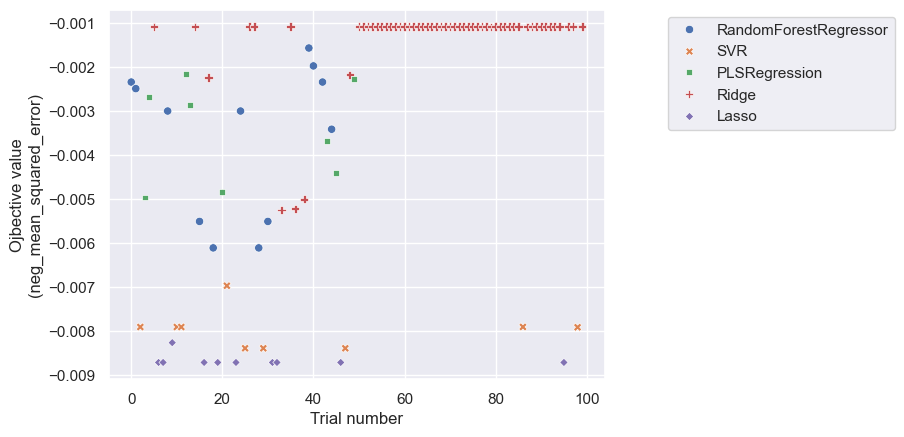

In [79]:
sns.set_theme(style="darkgrid")
default_reg_scoring= config.settings.scoring
ax = sns.scatterplot(data=ptr_transformed_study.trials_dataframe(), x="number", 
                     y="value",style='params_algorithm_name',hue='params_algorithm_name')
ax.set(xlabel="Trial number",ylabel=f"Ojbective value\n({default_reg_scoring})")
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.6, 1), ncol=1, title="")

Similar to log scaled models trained without the PRF transform, log-transformed models trained with PTR functions will reverse both the probabilistic class membership likelihoods from the PTR function and reverse the subsequent log transform from any log scaling, scaling predictions back inline with original data: 

In [80]:
# Get the best Trial from the log transformed study and build the model.
buildconfig = buildconfig_best(ptr_transformed_study)
best_build = build_best(buildconfig, "../target/best.pkl")

# generate predictions
import pickle
with open("../target/best.pkl", "rb") as f:
    model = pickle.load(f)
model.predict_from_smiles(["CCC"], transform=None)

array([0.3506154])

## Covariate modelling

### Modelling one simple covariate, e.g. dose or time point

A covariate, such as dose or timepoint, can be used as an auxiliary descriptor to account for the effect of this parameter in predictions. In this situation, a compound can be represented more than once across n distinct covariate measurements. Each of the covariate response values can now be used in training an algorithm in this approach. Replicates across each compound-covariate pair may be deduplicated using the standard deduplication approaches.

To activate this function in QSARtuna, the `aux_column` setting can be used according to the column denoting the covariate to be modelled, like so:

In [81]:
aux_col_config = OptimizationConfig(
        data=Dataset(
        input_column="canonical",
        response_column="molwt",
        response_type="regression",
        training_dataset_file="../tests/data/aux_descriptors_datasets/train_with_conc.csv",
        aux_column="aux1" # use column aux1 as a co-variate in modelling
    ),
    descriptors=[
        ECFP.new(), 
        ECFP_counts.new(), 
        MACCS_keys.new(),
    ],
    algorithms=[
        SVR.new(),
        RandomForestRegressor.new(n_estimators={"low": 5, "high": 10}),
        Ridge.new(),
        Lasso.new(),
        PLSRegression.new(),
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=2,
        n_trials=10,
        random_seed=42,
        direction=OptimizationDirection.MAXIMIZATION,
    ),
) 

aux_col_study = optimize(aux_col_config, study_name="covariate_example")
build_best(buildconfig_best(aux_col_study), "../target/aux1_model.pkl")
with open("../target/aux1_model.pkl", "rb") as f:
    aux1_model = pickle.load(f)

[I 2024-10-02 18:16:53,613] A new study created in memory with name: covariate_example
[I 2024-10-02 18:16:53,676] A new study created in memory with name: study_name_0
[I 2024-10-02 18:16:53,882] Trial 0 finished with value: -5186.767663956718 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 6, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 5, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 0 with value: -5186.767663956718.
[I 2024-10-02 18:16:53,982] Trial 1 finished with value: -4679.740824270968 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 7, 'n_estimators__

Predictions from a covariate-trained model can now be generated like so:

In [82]:
aux1_model.predict_from_smiles(["CCC", "CCC"], aux=[10,5])

array([52.45281013, 52.45281013])

where the `aux` parameter of `predict_from_smiles` is used (and required) to generate predictions for a an input covariate auxiliary query, and the shape of the `aux` query must be the same shape as the SMILES input query, otherwise a ValueError will be thrown.

So, for this toy example query the predicitons are for the SMILES `CCC` and two separate auxiliary covariate queries of `10` and `5`.


N.B: For this particular toy training example, the molecular weight response column (`molwt`) is the same regardless of the modelled covariate value, and so the predictions are the same regardless the `aux` query, as expected.

###  Transformation of co-variates: Proteochemometric (PCM) modelling + more

#### VectorFromSmiles

In order to utilise more than one type of covariate value at a time, an auxiliary transformation must be applied to process co-variates in a manner expected for the algorithms.

Pre-computed covariates (in a similar manner to pre-computed descriptors), can be processed using the `VectorFromColumn`. Similar to pre-computed descriptors, the VectorFromColumn will split covariates on `,` or comma seperations like so: 

In [83]:
from optunaz.utils.preprocessing.transform import VectorFromColumn

vector_covariate_config = OptimizationConfig(
        data=Dataset(
        input_column="canonical",
        response_column="molwt",
        response_type="regression",
        training_dataset_file="../tests/data/precomputed_descriptor/train_with_fp.csv",
        aux_column="fp", # use a comma separated co-variate vector in column `fp`
        aux_transform=VectorFromColumn.new(), # split the comma separated values into a vector
        split_strategy=Stratified(fraction=0.2),
    ),
    descriptors=[
        ECFP.new(), 
        ECFP_counts.new(), 
        MACCS_keys.new(),
    ],
    algorithms=[
        SVR.new(),
        RandomForestRegressor.new(n_estimators={"low": 5, "high": 10}),
        Ridge.new(),
        Lasso.new(),
        PLSRegression.new(),
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=3,
        n_trials=10,
        n_startup_trials=0,
        direction=OptimizationDirection.MAXIMIZATION,
        track_to_mlflow=False,
        random_seed=42,
    ),
) 

vector_covariate_study = optimize(vector_covariate_config, study_name="vector_aux_example")
build_best(buildconfig_best(vector_covariate_study), "../target/vector_covariate_model.pkl")
with open("../target/vector_covariate_model.pkl", "rb") as f:
    vector_covariate_model = pickle.load(f)

[I 2024-10-02 18:16:54,988] A new study created in memory with name: vector_aux_example
[I 2024-10-02 18:16:55,037] A new study created in memory with name: study_name_0
[I 2024-10-02 18:16:55,141] Trial 0 finished with value: -3043.4473106576693 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.011994365911634164, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 0 with value: -3043.4473106576693.
[I 2024-10-02 18:16:55,229] Trial 1 finished with value: -3043.39919100435 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.029071783512897825, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 1 with value: -3043.39919100435.
[I 2024-10-02 18:16:55,344] Trial 2 finished with value: -4621.489703141113 and parameters: {'algorithm_name': 'SVR', 'SVR_alg

We can inspect the input query for the auxiliary co-variates used in the modelling like so:

In [84]:
train_smiles, train_y, train_aux, test_smiles, test_y, test_aux = vector_covariate_config.data.get_sets()

train_aux, train_aux.shape

(array([[0., 1., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 0., 0., ..., 1., 0., 1.],
        ...,
        [0., 1., 0., ..., 0., 0., 1.],
        [0., 1., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 (40, 512))

For this toy example, the co-variate descriptors 512 in legth for the 40 training instances are used in training. Inference for the model can be performed on the test like so:

In [85]:
vector_covariate_model.predict_from_smiles(test_smiles, aux=test_aux)

array([494.24615136, 343.57199899, 243.66555938, 499.15698703,
       444.45019502, 340.58194786, 463.055959  , 350.78471292,
       412.86726453, 376.11106444])

#### Z-Scales (for PCM)

Proteochemometric modelling (PCM) is the term used for the approach of training protein-descriptors as a distinct input space alongside the chemical ones. This can be performed in QSARtuna by providing Z-Scales as an auxiliary transformation to a user input column containing sequence information. Protein sequence is  transformed to Z-Scales based on [this publication](https://pubs.acs.org/doi/10.1021/jm9700575) using the `Peptides` Python package.

N:B. Note that Z-Scales as covariates are a distinct method separate to `ZScales` descriptors, since the former treats Z-Scales as a distinct input parameter (for PCM modelling), whereas the latter treates them as a descriptor trial that may or may not be selected during optimisation (e.g. for Protein-peptide interaction modelling). In other words, Z-scales will always be an input descriptor parameter when applied as a covariate and duplicates are treated on a compound-`ZScale` pair basis).

Now let us consider the following toy data set file:

In [86]:
!head -n 5 ../tests/data/peptide/toxinpred3/train.csv

Peptide,Class,Smiles
MDLITITWASVMVAFTFSLSLVVWGRSGL,0,N[C@@H](CCSC)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H]([C@H](CC)C)C(=O)N[C@@H]([C@@H](C)O)C(=O)N[C@@H]([C@H](CC)C)C(=O)N[C@@H]([C@@H](C)O)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](C)C(=O)N[C@@H](CO)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](CCSC)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](C)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H]([C@@H](C)O)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CO)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CO)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)NCC(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CO)C(=O)NCC(=O)N[C@@H](CC(C)C)C(=O)O
ARRGGVLNFGQFGLQALECGFVTNR,0,N[C@@H](C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)NCC(=O)NCC(=O)N[C@@H](C(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(=O)N)C(=O)N[C@@H](Cc1ccccc1)C(=O)NCC(=O)N[C@@H](CCC(=O)N)C(=O)N[C@@H](Cc1ccccc1)C(=O)NCC(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCC(=O)N)C(=O)N[C@@H](C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CS)C(=O)NCC(=O)N[C

The following example demponstrates how Z-Scales may be utilised for PCM by specifying the `ZScales` data transform on the "Peptide" column containing our peptide sequence, like so: 

In [87]:
from optunaz.utils.preprocessing.transform import ZScales
from optunaz.config.optconfig import KNeighborsClassifier

zscale_covariate_config = OptimizationConfig(
        data=Dataset(
        input_column="Smiles",
        response_column="Class",
        response_type="classification",
        training_dataset_file="../tests/data/peptide/toxinpred3/train.csv",
        aux_column="Peptide", # Name of the column containing peptide/protein amino acid sequence
        aux_transform=ZScales.new(), # Zscales transform is used to transform sequence into a Z-scales vector
        split_strategy=Stratified(fraction=0.2),
    ),
    descriptors=[
        ECFP.new(nBits=128), 
    ],
    algorithms=[
        KNeighborsClassifier.new(),
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.CLASSIFICATION,
        cross_validation=2,
        n_trials=1,
        n_startup_trials=0,
        direction=OptimizationDirection.MAXIMIZATION,
        track_to_mlflow=False,
        random_seed=42,
    ),
) 

zscale_covariate_study = optimize(zscale_covariate_config, study_name="zscale_aux_example")
build_best(buildconfig_best(zscale_covariate_study), "../target/zscale_covariate_model.pkl")
with open("../target/zscale_covariate_model.pkl", "rb") as f:
    zscale_covariate_model = pickle.load(f)

[I 2024-10-02 18:17:00,612] A new study created in memory with name: zscale_aux_example
[I 2024-10-02 18:17:00,666] A new study created in memory with name: study_name_0
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/Users/kljk345/Li

N:B. Unlike the `ZScale` descriptor (which works on SMILES level of a peptide/protein), the `ZScale` data transform expects amino acid sequence as inputs.

We can inspect the input query for the auxiliary co-variates used in the modelling like so:

In [88]:
train_smiles, train_y, train_aux, test_smiles, test_y, test_aux = zscale_covariate_config.data.get_sets()

train_aux, train_aux.shape

(array([[ 1.31176471,  0.08058824, -0.27176471,  0.56470588, -0.62529412],
        [-0.99521739, -0.59826087, -0.34695652, -0.03086957,  0.13391304],
        [ 0.08083333, -0.6125    ,  0.82916667, -0.05083333, -0.56083333],
        ...,
        [ 0.93357143, -0.02785714, -0.04214286, -0.36      , -0.02785714],
        [ 0.30461538, -0.55307692,  0.31307692, -0.11076923,  0.00846154],
        [-0.1232    , -0.3364    ,  0.2328    , -0.1368    ,  0.2304    ]]),
 (7060, 5))

For this toy example, the Z-scale co-variate descriptors 7062 with the expected length of 5 Z-Scale descriptors  used in training. Inference for the model can be performed on the test by providing the auxiliary co-variate Z-Scales like so:

In [89]:
zscale_covariate_model.predict_from_smiles(test_smiles, aux=test_aux)

array([0.2, 0. , 0.8, ..., 0.2, 0.2, 0. ])

We may also inspect the X-matrix (descriptor) used to train the toy model like so:

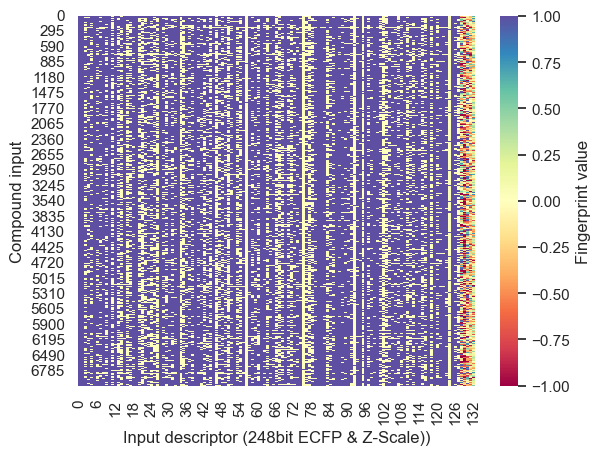

In [90]:
ax = sns.heatmap(zscale_covariate_model.predictor.X_,
            vmin=-1, vmax=1, cmap='Spectral',
            cbar_kws={'label': 'Fingerprint value'})
ax.set(ylabel="Compound input", xlabel=f"Input descriptor (248bit ECFP & Z-Scale))");

Note that the (continuous) Z-scales covariates can be seen in the final columns (129-132) after the 128bit ECFP fingerprints used in this example  


## Advanced options for QSARtuna runs

### Multi-objective prioritization of performance and standard deviation

QSARtuna can optimize for the minimzation of the standard deviation of performance across the folds. This should in theory prioritize hyperparameters that are consistently performative across different splits of the data, and so should be more generalizable/performative in production. This can be performed with the `minimize_std_dev` in the example below:

In [91]:
config = OptimizationConfig(
        data=Dataset(
        input_column="Smiles",
        response_column="pXC50",
        response_type="regression",
        training_dataset_file="../tests/data/sdf/example.sdf",
    ),
    descriptors=[
        ECFP.new(), 
        ECFP_counts.new(), 
        MACCS_keys.new(),
        SmilesFromFile.new(),
    ],
    algorithms=[
        SVR.new(),
        RandomForestRegressor.new(n_estimators={"low": 5, "high": 10}),
        Ridge.new(),
        Lasso.new(),
        PLSRegression.new(),
        ChemPropRegressor.new(epochs=5),
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=3,
        n_trials=25,
        n_startup_trials=25,
        direction=OptimizationDirection.MAXIMIZATION,
        track_to_mlflow=False,
        random_seed=42,
        n_chemprop_trials=3,
        minimise_std_dev=True # Multi-objective optimization for performance and std. dev.
    ),
) 

study = optimize(config, study_name="example_multi-parameter_analysis")
default_reg_scoring= config.settings.scoring
study.set_metric_names([default_reg_scoring.value,'Standard deviation']) # Set the names of the multi-parameters

[I 2024-10-02 18:18:17,078] A new study created in memory with name: example_multi-parameter_analysis
[I 2024-10-02 18:18:17,122] A new study created in memory with name: study_name_0
[I 2024-10-02 18:18:17,259] Trial 0 finished with values: [-1.4008740644240856, 0.9876203329634794] and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 6, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 5, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. 
[I 2024-10-02 18:18:17,326] Trial 1 finished with values: [-1.3561484909673422, 0.9875061220991905] and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 7,

[I 2024-10-02 18:18:17,876] Trial 20 finished with values: [-0.8604898820838102, 0.7086875504668665] and parameters: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. 
[I 2024-10-02 18:18:17,895] Trial 21 finished with values: [-0.5919869916997383, 0.2367498627927979] and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 0.0009327650919528738, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 6.062479210472502, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. 
[I 2024-10-02 18:18:17,900] Trial 22 pruned. Duplicate parameter set
[I 2024-10-02 18:18:17,918] Trial 23 finished with values: [-1.2497762395862362, 0.10124660026536195] and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': 

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-0.6101359993004856, 0.3011280543457062]


[I 2024-10-02 18:19:54,957] Trial 0 finished with values: [-2.0621601907738047, 0.2749020946925899] and parameters: {'algorithm_name': 'ChemPropRegressor', 'ChemPropRegressor_algorithm_hash': '668a7428ff5cdb271b01c0925e8fea45', 'activation__668a7428ff5cdb271b01c0925e8fea45': <ChemPropActivation.RELU: 'ReLU'>, 'aggregation__668a7428ff5cdb271b01c0925e8fea45': <ChemPropAggregation.MEAN: 'mean'>, 'aggregation_norm__668a7428ff5cdb271b01c0925e8fea45': 100.0, 'batch_size__668a7428ff5cdb271b01c0925e8fea45': 50.0, 'depth__668a7428ff5cdb271b01c0925e8fea45': 3.0, 'dropout__668a7428ff5cdb271b01c0925e8fea45': 0.0, 'ensemble_size__668a7428ff5cdb271b01c0925e8fea45': 1, 'epochs__668a7428ff5cdb271b01c0925e8fea45': 5, 'features_generator__668a7428ff5cdb271b01c0925e8fea45': <ChemPropFeatures_Generator.NONE: 'none'>, 'ffn_hidden_size__668a7428ff5cdb271b01c0925e8fea45': 300.0, 'ffn_num_layers__668a7428ff5cdb271b01c0925e8fea45': 2.0, 'final_lr_ratio_exp__668a7428ff5cdb271b01c0925e8fea45': -4, 'hidden_size__

Note the multi-parameter performance reported for each trial, e.g. ` Trial 1 finished with values: [XXX, XXX]`, which correspond to negated MSE and deviation of negated MSE performance across the 3-folds, respectively. The two objectives may be plot as a function of trial number, as follows:

Text(0, 0.5, 'Standard Deviation across folds')

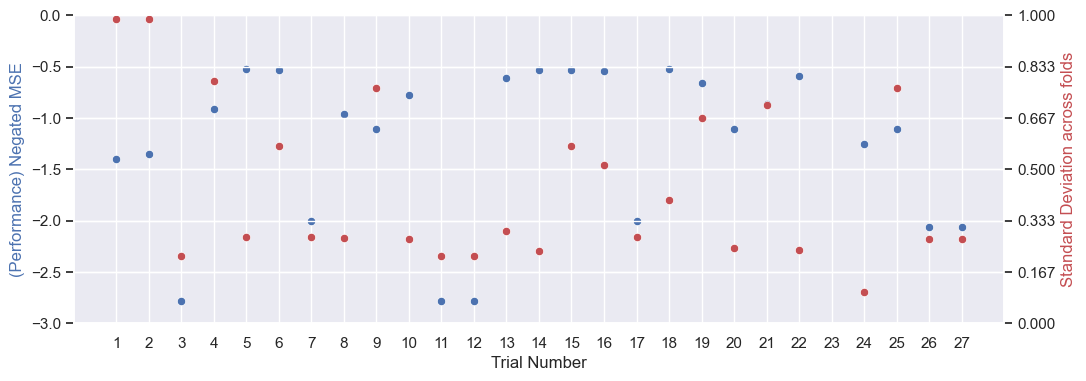

In [92]:
df = study.trials_dataframe()
df.number = df.number+1
fig=plt.figure(figsize=(12,4))
ax = sns.scatterplot(data=df, x="number", y="values_neg_mean_squared_error",
                     legend=False, color="b")
ax2 = sns.scatterplot(data=df, x="number", y="values_Standard deviation",
                      ax=ax.axes.twinx(), legend=False, color="r")

a = df['values_neg_mean_squared_error'].apply(np.floor).min()
b = df['values_neg_mean_squared_error'].apply(np.ceil).max()
c = df['values_Standard deviation'].apply(np.floor).min()
d = df['values_Standard deviation'].apply(np.ceil).max()

# Align both axes
ax.set_ylim(a,b);
ax.set_yticks(np.linspace(a,b, 7));
ax2.set_ylim(c,d);
ax2.set_yticks(np.linspace(c,d, 7));
ax.set_xticks(df.number);

# Set the colors of labels
ax.set_xlabel('Trial Number')
ax.set_ylabel('(Performance) Negated MSE', color='b')
ax2.set_ylabel('Standard Deviation across folds', color='r')

We may plot the Pareto front of this multi-objective study using the Optuna plotting functionaility directly:

In [93]:
from optuna.visualization import plot_pareto_front

plot_pareto_front(study)

### Further visualization of QSARtuna runs

It is possible to evaluate the parameter importances on regression metric performance across descriptor vs. algorithm choice, based on the completed trials in our study:

In [94]:
from optuna.visualization import plot_param_importances

plot_param_importances(study, target=lambda t: t.values[0])

Parameter importances are represented by non-negative floating point numbers, where higher values mean that the parameters are more important. The returned dictionary is of type collections.OrderedDict and is ordered by its values in a descending order (the sum of the importance values are normalized to 1.0). Hence we can conclude that choice of algortihm is more important than choice of descriptor for our current study.

It is also possible to analyse the importance of these hyperparameter choices on the impact on trial duration:

In [95]:
plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

Optuna also allows us to plot the parameter relationships for our study, like so:

In [96]:
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study,
                         params=["algorithm_name", "descriptor"],
                         target=lambda t: t.values[0]) # First performance value taken

The same can be done for the relationships for the standard deviation of performance:

In [97]:
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study,
                         params=["algorithm_name", "descriptor"],
                         target=lambda t: t.values[1]) # Second standard deviation value taken

### Precomputed descriptors from a file example

Precomputed descriptors can be supplied to models using the "PrecomputedDescriptorFromFile" descriptor, and supplying the `input_column` and `response_column` like so:

In [98]:
from optunaz.descriptors import PrecomputedDescriptorFromFile

descriptor=PrecomputedDescriptorFromFile.new(
            file="../tests/data/precomputed_descriptor/train_with_fp.csv",
            input_column="canonical", # Name of the identifier for the compound
            response_column="fp") # Name of the column with the pretrained (comma separated) descriptors

descriptor.calculate_from_smi("Cc1cc(NC(=O)c2cccc(COc3ccc(Br)cc3)c2)no1").shape

(512,)

In this toy example there are 512 precomputed bit descriptor vectors, and a model can be trained with precomputed descriptors from a file (in a composite descriptor with ECFP), like so:

In [99]:
precomputed_config = OptimizationConfig(
        data=Dataset(
        input_column="canonical",
        response_column="molwt",
        response_type="regression",
        training_dataset_file="../tests/data/precomputed_descriptor/train_with_fp.csv",
        split_strategy=Stratified(fraction=0.2),
    ),
    descriptors=[
        CompositeDescriptor.new(
            descriptors=[
                PrecomputedDescriptorFromFile.new(file="../tests/data/precomputed_descriptor/train_with_fp.csv",
                                                 input_column="canonical", response_column="fp"),
                ECFP.new()])
    ],
    algorithms=[
        RandomForestRegressor.new(n_estimators={"low": 5, "high": 10}),
        Ridge.new(),
        Lasso.new(),
        PLSRegression.new(),
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=2,
        n_trials=4,
        n_startup_trials=0,
        direction=OptimizationDirection.MAXIMIZATION,
        track_to_mlflow=False,
        random_seed=42,
    ),
) 

precomputed_study = optimize(precomputed_config, study_name="precomputed_example")
build_best(buildconfig_best(precomputed_study), "../target/precomputed_model.pkl")
with open("../target/precomputed_model.pkl", "rb") as f:
    precomputed_model = pickle.load(f)

[I 2024-10-02 18:21:26,393] A new study created in memory with name: precomputed_example
[I 2024-10-02 18:21:26,395] A new study created in memory with name: study_name_0
[I 2024-10-02 18:21:26,506] Trial 0 finished with value: -3704.729132396259 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.011994365911634164, 'descriptor': '{"parameters": {"descriptors": [{"name": "PrecomputedDescriptorFromFile", "parameters": {"file": "../tests/data/precomputed_descriptor/train_with_fp.csv", "input_column": "canonical", "response_column": "fp"}}, {"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}]}, "name": "CompositeDescriptor"}'}. Best is trial 0 with value: -3704.729132396259.
[I 2024-10-02 18:21:26,547] Trial 1 finished with value: -3704.801507216346 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cf

N.B: The `qsartuna-predict` CLI command for QSARtuna contains the options `--input-precomputed-file`, `input-precomputed-input-column` and `--input-precomputed-response-column` for generating predictions at inference time. However this is not available within python notebooks and calling predict on a new set of unseen molecules will cause "Could not find descriptor errors" like so:

In [100]:
new_molecules = ["CCC", "CC(=O)Nc1ccc(O)cc1"]

precomputed_model.predict_from_smiles(new_molecules)

Could not find descriptor for CCC in file ../tests/data/precomputed_descriptor/train_with_fp.csv.
Could not find descriptor for CC(=O)Nc1ccc(O)cc1 in file ../tests/data/precomputed_descriptor/train_with_fp.csv.


array([nan, nan])

A precomputed desciptors from a file should be provided, and the `inference_parameters` function called, like so:

In [101]:
import tempfile # For this example we use a temp file to store a temporary inference dataset

# extract precomputed descriptor (i.e the 1st descriptor in the composite descriptor for this example)
precomputed_descriptor = precomputed_model.descriptor.parameters.descriptors[0]

# example fp with 0's for illustration purposes
example_fp = str([0] * 512)[1:-1]

with tempfile.NamedTemporaryFile() as temp_file:
    # write the query data to a new file
    X = pd.DataFrame(
        data={"canonical": new_molecules,
              "fp": [example_fp for i in range(len(new_molecules))]})
    X.to_csv(temp_file.name)
    
    # set precomputed descriptor to the new file
    precomputed_descriptor.inference_parameters(temp_file.name, "canonical", "fp")
    preds = precomputed_model.predict_from_smiles(["CCC", "CC(=O)Nc1ccc(O)cc1"])

preds

array([335.0447, 335.3502])

## Preexisting models: Convert scikit-learn(-like) models to QSARtuna models

It is possible to convert existing scikit-learn or scikit-learn like models (which support the relevant `fit`, `predict`, `predict_proba` functions) to QSARtuna models for use with external tools expecting QSARtuna objects (e.g. REINVENT) or for reuse as a preexisting model into new Optimisation runs.

### Simple QSARtuna conversion example

The CLI tool `qsartuna-convert` is available for converting preexisting models, like so:

In [102]:
from optunaz import convert
from unittest.mock import patch
import sys

convert_args = [
    "prog",
    "-h",
]
with patch.object(sys, "argv", convert_args):
    try:
        convert.main()
    except SystemExit:
        pass

usage: prog [-h] --input-model-file INPUT_MODEL_FILE --input-model-mode
            INPUT_MODEL_MODE --output-model-path OUTPUT_MODEL_PATH
            [--input-json-descriptor-file INPUT_JSON_DESCRIPTOR_FILE]
            [--wrap-for-uncertainty]

Convert an existing sklearn(-like) model into a QSARtuna model

options:
  -h, --help            show this help message and exit
  --input-json-descriptor-file INPUT_JSON_DESCRIPTOR_FILE
                        Name of input JSON file with descriptor configuration.
                        Defaults to PrecomputedDescriptorFromFile
  --wrap-for-uncertainty
                        Whether to wrap regression in MAPIE or classification
                        in VennAbers Calibrated Classifiers for uncertainty
                        support

required named arguments:
  --input-model-file INPUT_MODEL_FILE
                        Model file name.
  --input-model-mode INPUT_MODEL_MODE
                        Classification or regression mode for the 

The CLI helper function expects an `input-model-file`, the `input-model-mode` (classification or regression) and an `output-model-path` for the new QSARtuna model. In the following example, we convert a toy regression (which returns the sum of the input descriptors as a prediction) as a QSARtuna model:

In [103]:
from optunaz.model_writer import Predictor

# This is a simple custom predict model, 
# which is used for demonstration purposes
class RegModel(Predictor):
    def predict(self, xs):
        return np.sum(xs, axis=1)

    def fit(self, X, y):
        pass


with open(str("../target/regmodel_convert_example.pkl"), "wb") as model_f:
    pickle.dump(RegModel(), model_f)
    
convert_args = [
    "prog",
    "--input-model-file",
    "../target/regmodel_convert_example.pkl",
    "--input-model-mode",
    "regression",
    "--output-model-path",
    "../target/regmodel_convert_example_converted.pkl",
]

with patch.object(sys, "argv", convert_args):
    convert.main()

2024-10-02 18:21:27,199.199 WARNING convert - convert: input-json-descriptor-file not provided, default (PrecomputedDescriptorFromFile) will be used


2024-10-02 18:21:27,199.199 WARNING convert - convert: input-json-descriptor-file not provided, default (PrecomputedDescriptorFromFile) will be used


From the logs we see `input-json-descriptor-file not provided, default (PrecomputedDescriptorFromFile) will be used` reported.

Since no descriptor JSON configuration was provided, the default behaviour is for converted model to require preompcuted descriptors (as we presume that the descriptors used to train the preexisting model are not implemented in QSARtuna).

It is possible to also provide a JSON containing the details of a descriptor to wrap with the model, if this is a QSARtuna compatible descriptor already implemented in QSARtuna, like so:

In [104]:
# create a JSON with the default ECFP configuration for --input-json-descriptor-file
with open("../target/ecfp.json", "wt") as ecfp_f:
    json.dump(apischema.serialize(ECFP.new()), ecfp_f)

convert_args = [
    "prog",
    "--input-model-file",
    "../target/regmodel_convert_example.pkl",
    "--input-model-mode",
    "regression",
    "--input-json-descriptor-file",
    "../target/ecfp.json",   # the default ECFP configuration is provided to qsartuna-convert 
    "--output-model-path",
    "../target/ecfp_convert_example.pkl",
]

with patch.object(sys, "argv", convert_args):
    convert.main()

2024-10-02 18:21:27,232.232 INFO convert - convert: Descriptor ECFP(name='ECFP', parameters=ECFP.Parameters(radius=3, nBits=2048, returnRdkit=False)) will be used from provided JSON


Now we have a QSARtuna model which will return the sum of ECFP bits turned on as a prediction

### Add uncertainty estimation to preexisting and QSARtuna models

It is possible to add uncertainty estimation to models by 'wrapping' preexisitng models (so long as they have the X/y labels stored in self.X_ and self.y_) with compatible uncertainty quantification methods using the `----wrap-for-uncertainty` flag.

In this scenario MAPIE (for regression) or VennAbers calibrated classifiers (for classification) will be used to retrain the custom model.

It even possible to add uncertainty estimation to preexisting QSARtuna models, where the descriptor JSON is not required since the QSARtuna descriptor coming with the model will simply be used. For example, we may convert the previous model we generated from the covariate section above at `../target/vector_covariate_model` like so:

In [105]:
convert_args = [
    "prog",
    "--input-model-file",
    "../target/vector_covariate_model.pkl",
    "--input-model-mode",
    "regression",
    "--output-model-path",
    str("../target/qsartuna_add_uncertainty.pkl"),
]

with patch.object(sys, "argv", convert_args):
    convert.main()

## Preexisting models: Using prexisting models as custom models for Optimisation or Build

`CustomRegressionModel` and `CustromClassifiationModel` are available to use existing `.pkl` files in at Optimisation and Build time. Custom models can also be prexisting QSARtuna models (including converted QSARtuna models as per the previous section).

These methods require the location of a preexisting model pkl file (`preexisting_model`) and whether you would like the custom estimator to be refit during Optimisation or Build (N.B: most sklearn models will refit to a brand new estimator by default, so any previous fitting data would be lost if this is set to `1`).

This function can be used like so:

In [106]:
from optunaz.config.optconfig import CustomRegressionModel


custom_config = OptimizationConfig(
        data=Dataset(
        input_column="canonical",
        response_column="molwt",
        response_type="regression",
        training_dataset_file="../tests/data/DRD2/subset-50/train.csv",
    ),
    descriptors=[
        ECFP.new()
    ],
    algorithms=[
        CustomRegressionModel.new(preexisting_model="../target/regmodel_convert_example.pkl",
                                 refit_model=0    # example parameter, showing how to prevent the 
                                                  #retraining of the model during optimisation
                                 )
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=2,
        n_trials=1,
        direction=OptimizationDirection.MAXIMIZATION,
    ),
) 

custom_study = optimize(custom_config, study_name="custom_example")
build_best(buildconfig_best(custom_study), "../target/custom_model.pkl") # Build the optimal custom model
with open("../target/custom_model.pkl", "rb") as f:
    custom_model = pickle.load(f)

[I 2024-10-02 18:21:27,307] A new study created in memory with name: custom_example
[I 2024-10-02 18:21:27,351] A new study created in memory with name: study_name_0
[I 2024-10-02 18:21:30,025] Trial 0 finished with value: -104472.28996365008 and parameters: {'algorithm_name': 'CustomRegressionModel', 'CustomRegressionModel_algorithm_hash': '28a16a59398d185b3254cc83cdaf7ca8', 'preexisting_model__28a16a59398d185b3254cc83cdaf7ca8': '../target/regmodel_convert_example.pkl', 'refit_model__28a16a59398d185b3254cc83cdaf7ca8': 0, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 0 with value: -104472.28996365008.


It is possible to combine the above configuration with other algorithms and descriptors to trial custom models with the default QSARtuna options, like so:

[I 2024-10-02 18:21:30,324] A new study created in memory with name: custom_mixed_example
[I 2024-10-02 18:21:30,383] A new study created in memory with name: study_name_0
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/joblib/memory.py:577: JobLibCollisionWarning: Possible name collisions between functions 'calculate_from_smi' (/Users/kljk345/PycharmProjects/Public_QSARtuna/D/QSARtuna/optunaz/descriptors.py:-1) and 'calculate_from_smi' (/Users/kljk345/PycharmProjects/Public_QSARtuna/D/QSARtuna/optunaz/descriptors.py:180)
  return self._cached_call(args, kwargs, shelving=False)[0]
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qsartuna-9ZyW8GtC-py3.10/lib/python3.10/site-packages/joblib/memory.py:577: JobLibCollisionWarning: Possible name collisions between functions 'calculate_from_smi' (/Users/kljk345/PycharmProjects/Public_QSARtuna/D/QSARtuna/optunaz/descriptors.py:-1) and 'calculate_from_smi' (/Users/kljk345/PycharmProjec

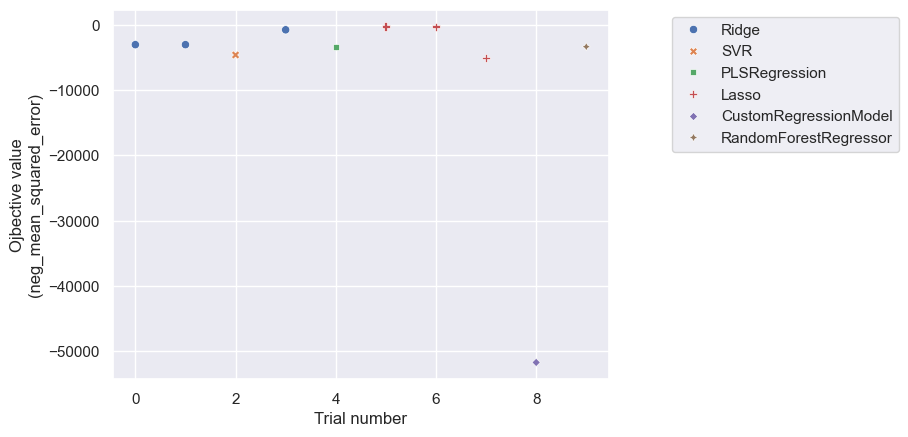

In [107]:
from optunaz.utils.preprocessing.transform import VectorFromColumn

custom_mixed_config = OptimizationConfig(
        data=Dataset(
        input_column="canonical",
        response_column="molwt",
        response_type="regression",
        training_dataset_file="../tests/data/precomputed_descriptor/train_with_fp.csv",
        aux_column="fp", # use a comma separated co-variate vector in column `fp`
        aux_transform=VectorFromColumn.new(), # split the comma separated values into a vector
        split_strategy=Stratified(fraction=0.2),
    ),
    descriptors=[
        ECFP.new(), 
        ECFP_counts.new(), 
        MACCS_keys.new(),
    ],
    algorithms=[
        SVR.new(),
        RandomForestRegressor.new(n_estimators={"low": 5, "high": 10}),
        Ridge.new(),
        Lasso.new(),
        PLSRegression.new(),
        CustomRegressionModel.new(preexisting_model="../target/regmodel_convert_example.pkl", refit_model=0)
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=3,
        n_trials=10,
        n_startup_trials=0,
        direction=OptimizationDirection.MAXIMIZATION,
        track_to_mlflow=False,
        random_seed=42,
    ),
)
custom_study = optimize(custom_mixed_config, study_name="custom_mixed_example")

sns.set_theme(style="darkgrid")
ax = sns.scatterplot(data=custom_study.trials_dataframe(), x="number", 
                     y="value",style='params_algorithm_name',hue='params_algorithm_name')
ax.set(xlabel="Trial number",ylabel=f"Ojbective value\n({default_reg_scoring})")
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.6, 1), ncol=1, title="")

# AutoML (Automated model retraining)

## Overview

The AutoML daemon functionaility in QSARtuna automates the process of preparing data for model training, including data cleaning, feature extraction, and data formatting, streamlining the data preprocessing stage. The main aspects of this workflow are the following:

* __Automated Data Preparation__: Automated process of preparing data for model training, including cleaning, feature extraction, formatting and quorum checks, streamlining data preprocessing

* __Model Training with SLURM__: Integration with SLURM to dispatch tasks, leveraging distributed computing resources for efficient and scalable model training

* __Scalable and Efficient with Dynamic Resource Allocation__: Workflow designed to handle large datasets (with multiple prediction tasks) and dynamically utilize CPU/GPU/memory HPC resources

* __Customizable SLURM and QSARtuna Templates__: SLURM templates can be tailored for different use cases. Both initial training and retraining QSARtuna JSON configurations are used, allowing users customise which algorithms and descriptors should be trialed. The default configuration will for e.g. train an initial ChemProp model, and subsequent models will automatically trial Transfer Learning (TL) from previous models for new data, when appropriate

* __Metadata, Prediction and Model Tracking__: The code includes functionality for tracking temporal performance, raw test predictions, active learning predictions and exported QSARtuna models, aiding monitoring and evaluating pseudo-prospective model performance over time

* __Automatic Job Resubmission__: In case of SLURM job failures, the code provides functionality to automatically resubmit failed jobs with modified resource allocations, enhancing the robustness of the model training process

* __Parallel Task Processing__: Supports for parallel processing training tasks, allowing for efficient handling of multiple retraining tasks simultaneously, reducing overall processing time

* __Dry Run Mode__: Dry run mode option enables users to simulate the process without actually submitting jobs, useful for verifying configurations and testing the workflow

The following is an example from the QSARtuna unit tests:

In [108]:
from optunaz import automl
import sys

aml_args = [
    "prog",
    "-h",
]
with patch.object(sys, "argv", aml_args):
    try:
        automl.main()
    except SystemExit:
        pass

usage: prog [-h] --output-path OUTPUT_PATH --email EMAIL --user_name USER_NAME
            --input-data INPUT_DATA --input-smiles-csv-column
            INPUT_SMILES_CSV_COLUMN --input-activity-csv-column
            INPUT_ACTIVITY_CSV_COLUMN --input-task-csv-column
            INPUT_TASK_CSV_COLUMN --input-initial-template
            INPUT_INITIAL_TEMPLATE --input-retrain-template
            INPUT_RETRAIN_TEMPLATE --input-slurm-template INPUT_SLURM_TEMPLATE
            [--quorum QUORUM] [--n-cores N_CORES] [--dry-run] [-v]
            [--slurm-req-cores SLURM_REQ_CORES]
            [--slurm-req-mem SLURM_REQ_MEM] --slurm-req-partition
            SLURM_REQ_PARTITION --slurm-al-pool SLURM_AL_POOL
            --slurm-al-smiles-csv-column SLURM_AL_SMILES_CSV_COLUMN
            --slurm-job-prefix SLURM_JOB_PREFIX
            [--slurm-failure-cores-increment SLURM_FAILURE_CORES_INCREMENT]
            [--slurm-failure-mem-increment SLURM_FAILURE_MEM_INCREMENT]
            [--slurm-failure

## Note on High-Performance Computing (HPC) Setup

This workflow is designed for use with one particular SLURM setup used in-house. If you intend to functionilaity with a different job scheduling system, significant modifications to the SLURM-specific components are necessary. Please ensure thorough understanding and necessary adaptations. 

## Data extraction options

QSARtuna AutoML expects temporal data (`--input-data`) to have been exported from warehouses/databases in a flat file structure in CSV format (which can also be gz compressed), containing  SMILES, activity and task (which denotes each distinct property to be modelled) CSV columns. 

Exports are expected to be temporal in nature, with the naming convention `%Y-%m-%d` (see [here](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) for details). Data can be exported in two ways:

* 1.) __Multiple files__: Each extraction date gets an distinct/unique file with `%Y-%m-%d` format within the filename, which denotes that point in temporal train time, like so:

In [109]:
ls -lrth ../tests/data/automl/

total 128
-rw-r--r--@ 1 kljk345  staff   9.2K Aug 27 12:08 2024-01-01.csv
-rw-r--r--@ 1 kljk345  staff    12K Aug 27 12:08 2024-02-01.csv
-rw-r--r--@ 1 kljk345  staff    12K Aug 27 12:08 2024-03-01.csv
-rw-r--r--@ 1 kljk345  staff    12K Aug 27 12:08 2024-04-01.csv
-rw-r--r--@ 1 kljk345  staff   438B Aug 27 12:08 2024-05-01.csv


* 2.) __Single file__: Data extraction is written to a single file (with any naming convention). The last modified date of the file is compared to the most recent round of AutoML training. If the file has undergone an update, then a new model building procedure is triggered.

## Walkthough running an AutoML pipeline

The main files that should be configured by users are the following:

* `--input-initial-template` dictates the first optimisation configuration for a property
* `--input-retrain-template` defines any further optimisation configurations, which e.g. could be configured to perform transfer learning on a compatible model from the `--input-initial-template`
* `--input-slurm-template` is the bash script to orchestrate model [re]-training. The default provided in `../examples/slurm-scripts/automl.template` is setup to use singularity commands, and for easy configuration within our current HPC setup (e.g. different partitions/memory allocations can be easily modified)

Let us consider the following AutoML setup:

* Training data is located in `../tests/data/automl/`
* The config for an initial round of model training is in `../examples/automl/config.initial.template`
* A config for any subsequent models is in `../examples/automl/config.retrain.template`
* Our slurm template is in `../examples/slurm-scripts/automl.template`
* HPC environment dictates our maximum requested resources should not exceed 50G of memory and 26 cpu
* We would like to retain all previous models
* A pool of compounds that could be added tested and added to a future model is in `../tests/data/DRD2/subset-1000/train.csv `

Then our configuration would be:

```
qsartuna-automl 
   --input-data "../tests/data/automl/*"  \
   --email <example>@<example>.com  --user_name <example>  \ # username should be accurate to monitor jobs
   --input-smiles-csv-column canonical  --input-activity-csv-column molwt \
   --input-task-csv-column one_taskid  \ # one_taskid in the toy data set has only one example task 
   --input-initial-template ../examples/automl/config.initial.template \
   --input-retrain-template ../examples/automl/config.retrain.template \
   --input-slurm-template ../examples/slurm-scripts/automl.template \
   --n-cores 1 -vvv --slurm-al-pool ../tests/data/DRD2/subset-1000/train.csv \
   --slurm-al-smiles-csv-column canonical  --output-path ../example_automl \
   --slurm-failure-max-cpu 26 --slurm-failure-max-mem 50 --save-previous-models \
   --slurm-job-prefix testaml --slurm-req-partition testpartition
```

and we can perform a test dry-run of this command from within our workbook like so:

In [110]:
aml_args = [
    "prog",
    "--output-path",
    "../target/automl_example",
    "--email",
    "test@test.com",
    "--user_name",
    "test",
    "--input-data",
    "../tests/data/automl/*",
    "--input-smiles-csv-column",
    "canonical",
    "--input-activity-csv-column",
    "molwt",
    "--input-task-csv-column",
    "one_taskid",
    "--input-initial-template",
    "../examples/automl/config.initial.template",
    "--input-retrain-template",
    "../examples/automl/config.retrain.template",
    "--input-slurm-template",
    "../examples/slurm-scripts/automl.template",
    "--n-cores",
    "1",
    "--dry-run", # The dry-run option is enabled, so the AutoML pipeline does not submit to SLURM
    "-vv", # Use this CLI option to enable detailed debugging logging to observe QSARtuna AutoML behaviour 
    "--slurm-al-pool",
    "../tests/data/DRD2/subset-1000/train.csv",
    "--slurm-al-smiles-csv-column",
    "canonical",
    "--slurm-job-prefix",
    "testaml",
    "--slurm-req-partition",
    "testpartition"
]
with patch.object(sys, "argv", aml_args):
    automl.main()

2024-10-02 18:21:35,723.723 INFO automl - main: Namespace(output_path='../target/automl_example', email='test@test.com', user_name='test', input_data='../tests/data/automl/*', input_smiles_csv_column='canonical', input_activity_csv_column='molwt', input_task_csv_column='one_taskid', input_initial_template='../examples/automl/config.initial.template', input_retrain_template='../examples/automl/config.retrain.template', input_slurm_template='../examples/slurm-scripts/automl.template', quorum=25, n_cores=1, dry_run=True, verbose=2, slurm_req_cores=12, slurm_req_mem=None, slurm_req_partition='testpartition', slurm_al_pool='../tests/data/DRD2/subset-1000/train.csv', slurm_al_smiles_csv_column='canonical', slurm_job_prefix='testaml', slurm_failure_cores_increment=4, slurm_failure_mem_increment=20, slurm_failure_mins_increment=720, slurm_failure_max_retries=5, slurm_failure_max_mem=200, slurm_failure_max_cpu=20, save_previous_models=False)
2024-10-02 18:21:35,729.729 DEBUG automl - main: Proc

Using the verbose `-vv` enables us to see what the automl script did behind the scenes.

Let's check the `testaml` directory to see what the automl script has generated in the `../target/automl_example` output directory:

In [111]:
!find ../target/automl_example/ | sed -e "s/[^-][^\/]*\// |/g" -e "s/|\([^ ]\)/|-\1/"

 | | |
 | | |-/processed_timepoints.json
 | | |-/data
 | | | |-TID1
 | | | | |-TID1.csv
 | | | | |-TID1.sh
 | | | | |-.24_01_01
 | | | | |-TID1.json


Taken together, the above log and directory structure of `automl_example` shows that the:

* first temporal point of training data has been correctly ingested (`24_01_01`)
* one available task in this example (for which data is available) at the `24_01_01` timepoint, denoted as `TID1` (for `molwt` prediction) meets quourum and is hence indexed at `../tests/data/automl/data/TID1/`
* resulting folder `data/TID1` comprises the following processed data:
    * `TID1.csv` : molecular property data set ready for modelling
    * `TID1.json`: config for an initial round of model training
    * `TID1.sh`: used to run run QSARtuna AutoML via an `sbatch` command, though `-- dry-run` prevented this happening
    * `.24_01_01` lock file initiated to track the status of the training at this timepoint
* `processed_timepoints.json` is created to track which timepoints are processed

The script stopped at this point, to allow for HPC resources to submit the initial optimisation job. Subsequent runs of the QSARtuna AutoML are required to progress past the initial optimisation run, and so could be scheduled (e.g. using `cron` or similar).

Running the AutoML workflow does a dry-run check of the status of the run:

In [112]:
with patch.object(sys, "argv", aml_args):
    automl.main()

2024-10-02 18:21:36,148.148 DEBUG base - setup: <pid.posix.PidFile object at 0x7fe0817962c0> entering setup
2024-10-02 18:21:36,149.149 DEBUG base - create: <pid.posix.PidFile object at 0x7fe0817962c0> create pidfile: /Users/kljk345/PycharmProjects/Public_QSARtuna/D/QSARtuna/notebooks/prog.pid
2024-10-02 18:21:36,151.151 DEBUG base - check: <pid.posix.PidFile object at 0x7fe0817962c0> check pidfile: /Users/kljk345/PycharmProjects/Public_QSARtuna/D/QSARtuna/notebooks/prog.pid
2024-10-02 18:21:36,153.153 INFO automl - main: Namespace(output_path='../target/automl_example', email='test@test.com', user_name='test', input_data='../tests/data/automl/*', input_smiles_csv_column='canonical', input_activity_csv_column='molwt', input_task_csv_column='one_taskid', input_initial_template='../examples/automl/config.initial.template', input_retrain_template='../examples/automl/config.retrain.template', input_slurm_template='../examples/slurm-scripts/automl.template', quorum=25, n_cores=1, dry_run=Tr

2024-10-02 18:21:36,164.164 WARNING automl - resubmitAnyFailedJobs: ../target/automl_example/data/TID1/TID1.sh never ran, so will be resubmit


2024-10-02 18:21:36,167.167 DEBUG automl - submitJob: Dry run of /usr/bin/sbatch ../target/automl_example/data/TID1/TID1.sh
2024-10-02 18:21:36,167.167 INFO automl - resubmitAnyFailedJobs: ../target/automl_example/data/TID1/TID1.sh resubmit (0 retrys)
2024-10-02 18:21:36,168.168 INFO automl - resubmitAnyFailedJobs: Some jobs were resubmitted: ['TID1']
2024-10-02 18:21:36,168.168 INFO automl - main: Exiting: 24_01_01 lock(s) indicate(s) work ongoing
2024-10-02 18:21:36,168.168 INFO automl - main: AutoML script took [0.016326904] seconds.
2024-10-02 18:21:36,168.168 DEBUG base - close: <pid.posix.PidFile object at 0x7fe0817962c0> closing pidfile: /Users/kljk345/PycharmProjects/Public_QSARtuna/D/QSARtuna/notebooks/prog.pid


The subsequent run of the code above correctly identifies the job was never correctly submitted to the SLURM queue (due to the dry-run), and correctly assessed the previous number of retires: "`resubmitAnyFailedJobs: ... resubmit (0 retrys)`".

NB: if an acutal job fails with a reported reason, dynamic resource allocation will attempt to increase job time/mem/cpu and resubmit to slurm, in an attempt to facilitate a successful run due to insufficient resources.

We can now emulate a sucessful run by copying an example trained model to the directory:

In [113]:
import shutil
import os

os.remove('../target/automl_example/data/TID1/.24_01_01') # Remove the lock
shutil.copy('../tests/data/DRD2/drd2_reg.pkl', '../target/automl_example/data/TID1/') # Add the example model

with patch.object(sys, "argv", aml_args):
    automl.main()

2024-10-02 18:21:36,175.175 DEBUG base - setup: <pid.posix.PidFile object at 0x7fe081796080> entering setup
2024-10-02 18:21:36,175.175 DEBUG base - create: <pid.posix.PidFile object at 0x7fe081796080> create pidfile: /Users/kljk345/PycharmProjects/Public_QSARtuna/D/QSARtuna/notebooks/prog.pid
2024-10-02 18:21:36,176.176 DEBUG base - check: <pid.posix.PidFile object at 0x7fe081796080> check pidfile: /Users/kljk345/PycharmProjects/Public_QSARtuna/D/QSARtuna/notebooks/prog.pid
2024-10-02 18:21:36,178.178 INFO automl - main: Namespace(output_path='../target/automl_example', email='test@test.com', user_name='test', input_data='../tests/data/automl/*', input_smiles_csv_column='canonical', input_activity_csv_column='molwt', input_task_csv_column='one_taskid', input_initial_template='../examples/automl/config.initial.template', input_retrain_template='../examples/automl/config.retrain.template', input_slurm_template='../examples/slurm-scripts/automl.template', quorum=25, n_cores=1, dry_run=Tr

We observe that after lock file removal and emulation of a trained model, the AutoML pipeline correctly identifies that " Work appears complete for timepoint 24_01_01". 

The output shows how the pipeline proceeds to the next timepoint, `24_02_01`, which has 152 new datapoints and is allocated dynamically allocated 60G of requested SLURM memory. A dry run to generate predictions for the pseodu-prospective performance of a "24_01_01" model vs. new data from "24_02_01" timepoint is now initiated.

Upon generation of pseodu-prospective performance, the next next round of optimisation, build and active learning predictions are initiated for the next timepoint, and the process continues like so.

## Schedule AutoML as a daemon for up-to-date models

This pipeline is intented to be run frequently to monitor input data and ensure models are trained and tested. How often this should occur will depend on the size/numer of prediction tasks to be processed. As an example you could create a `slurm_update_models_parallel.sh` file with the following:

```
#!/bin/bash
#SBATCH --job-name=qsartuna_automl-%j
#SBATCH -N 1
#SBATCH -c 1
#SBATCH --time=24:00:00
#SBATCH --mem=12G
#SBATCH --output=<your_path>/logs/update_it-%j.log
#SBATCH --error=<your_path>/logs/update_it-%j.log


ml Miniconda3
conda activate my_env_with_qsartuna

qsartuna-automl 
   --input-data "<your_path>/tests/data/automl/*"  \
   --email <example>@<example>.com  --user_name <example>  \
   --input-smiles-csv-column canonical  --input-activity-csv-column molwt \
   --input-task-csv-column one_taskid  \
   --input-initial-template <your_path>/examples/automl/config.initial.template \
   --input-retrain-template <your_path>/examples/automl/config.retrain.template \
   --input-slurm-template <your_path>/examples/slurm-scripts/automl.template \
   --n-cores 1 -vvv --slurm-al-pool <your_path>/tests/data/DRD2/subset-1000/train.csv \
   --slurm-al-smiles-csv-column canonical  --output-path <your_path>/example_automl \
   --slurm-failure-max-cpu 26 --slurm-failure-max-mem 50
```

and the following may be added to cron to run e.g. hourly:

`@hourly /usr/bin/sbatch <your_path>/slurm_update_models_parallel.sh`